## This notebook implements the MIMO method on the Pavia University Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import math
import os
from spectral import *
from tqdm import tqdm
from argparse import Namespace
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
from pdb import set_trace as stx
import numbers
from einops import rearrange

import torch
import torch.fft
from torchvision.models import ResNet
from torch.nn import PixelUnshuffle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import torchsummary
import torchprofile

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

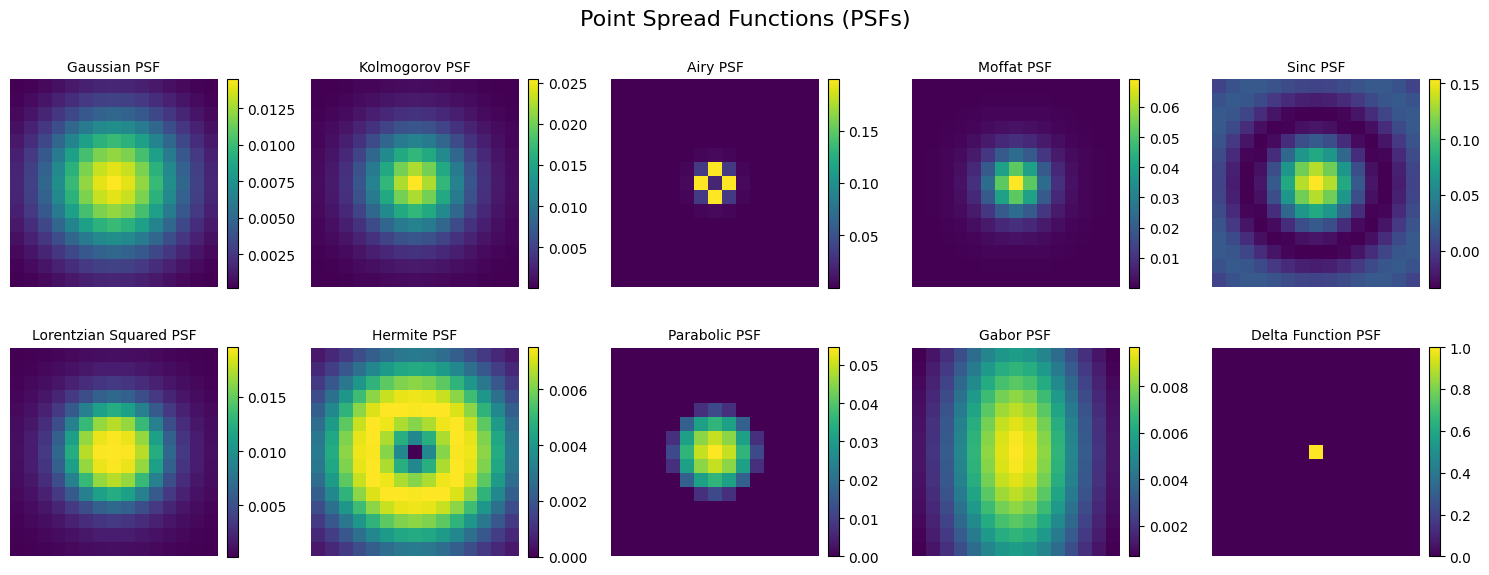

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image1, ms_image2, bands, title1, title2, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image1 : np.ndarray
        First multispectral image, shape: (H, W, num_bands).
    ms_image2 : np.ndarray
        Second multispectral image, shape: (H2, W2, num_bands).
    bands : tuple
        Band indices to use for RGB visualization (must be valid for both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands.
    ikonos_bands : np.ndarray
        Array of shape (num_bands, 3) with [center_nm, low_edge_nm, high_edge_nm] per band.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image1.shape[2]
    assert ms_image2.shape[2] == num_bands, "Both MSI images must have the same number of bands"

    # Pick labels and colors based on number of bands
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")

    # Create figure with 3 subplots (2 for images, 1 for SRF)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot first image
    if num_bands == 1:
        axs[0].imshow(ms_image1[:, :, 0], cmap='gray')
        axs[0].set_title(title1 + " (Panchromatic)")
    else:
        rgb1 = get_rgb(ms_image1, bands)
        axs[0].imshow(rgb1)
        axs[0].set_title(title1)
    axs[0].axis('off')

    # Plot second image
    if num_bands == 1:
        axs[1].imshow(ms_image2[:, :, 0], cmap='gray')
        axs[1].set_title(title2 + " (Panchromatic)")
    else:
        rgb2 = get_rgb(ms_image2, bands)
        axs[1].imshow(rgb2)
        axs[1].set_title(title2)
    axs[1].axis('off')

    # Plot SRF
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]
        axs[2].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Spectral Response')
    axs[2].set_title('Spectral Response Functions (SRF)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Pavia University HSI

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_University_data.mat')

In [9]:
def split_train_test(image, split_index):
    return image[:split_index], image[split_index:]

# Split HR MSI (same resolution, just varying bands)
def split_msi(msi_image):
    return split_train_test(msi_image, 480)

# Split LR HSI based on downsampling factor
def split_lr_hsi(hsi_image, downsample_factor):
    split_index = int(480 / downsample_factor)
    return split_train_test(hsi_image, split_index)

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth train shape:  (480, 320, 103)
Ground truth test shape:  (128, 320, 103)


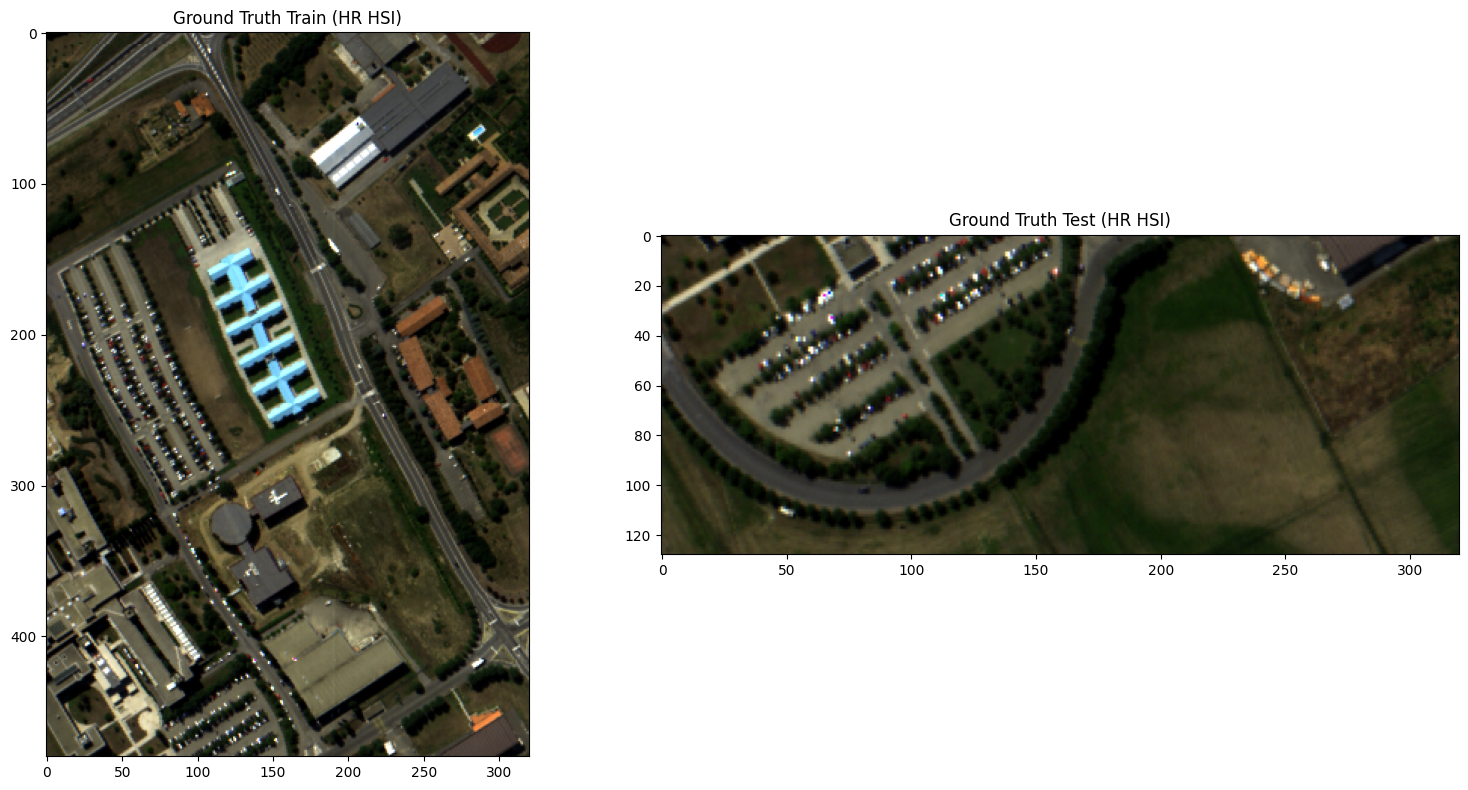

MSI train shape:  (480, 320, 1)
MSI test shape:  (128, 320, 1)


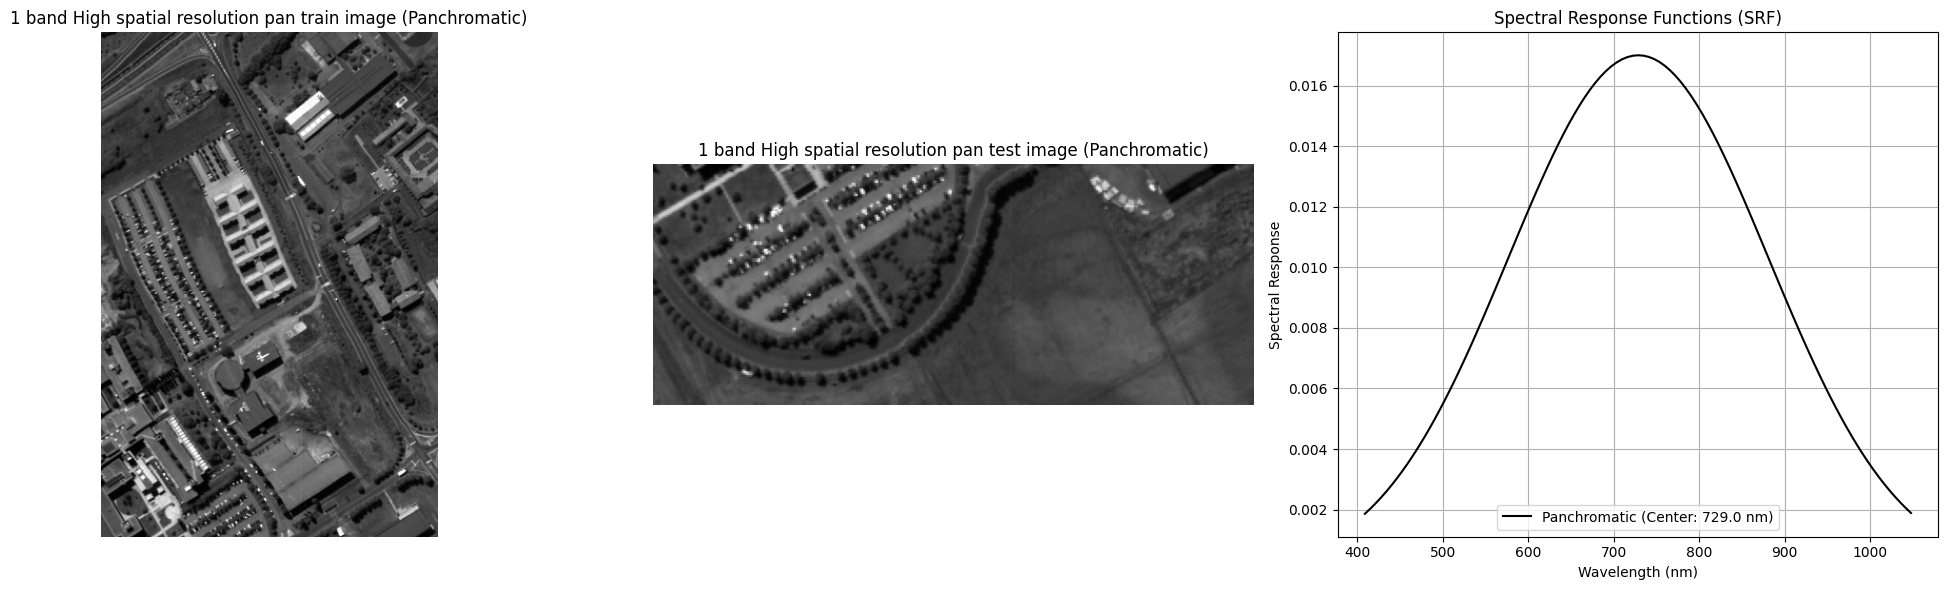

MSI train shape:  (480, 320, 3)
MSI test shape:  (128, 320, 3)


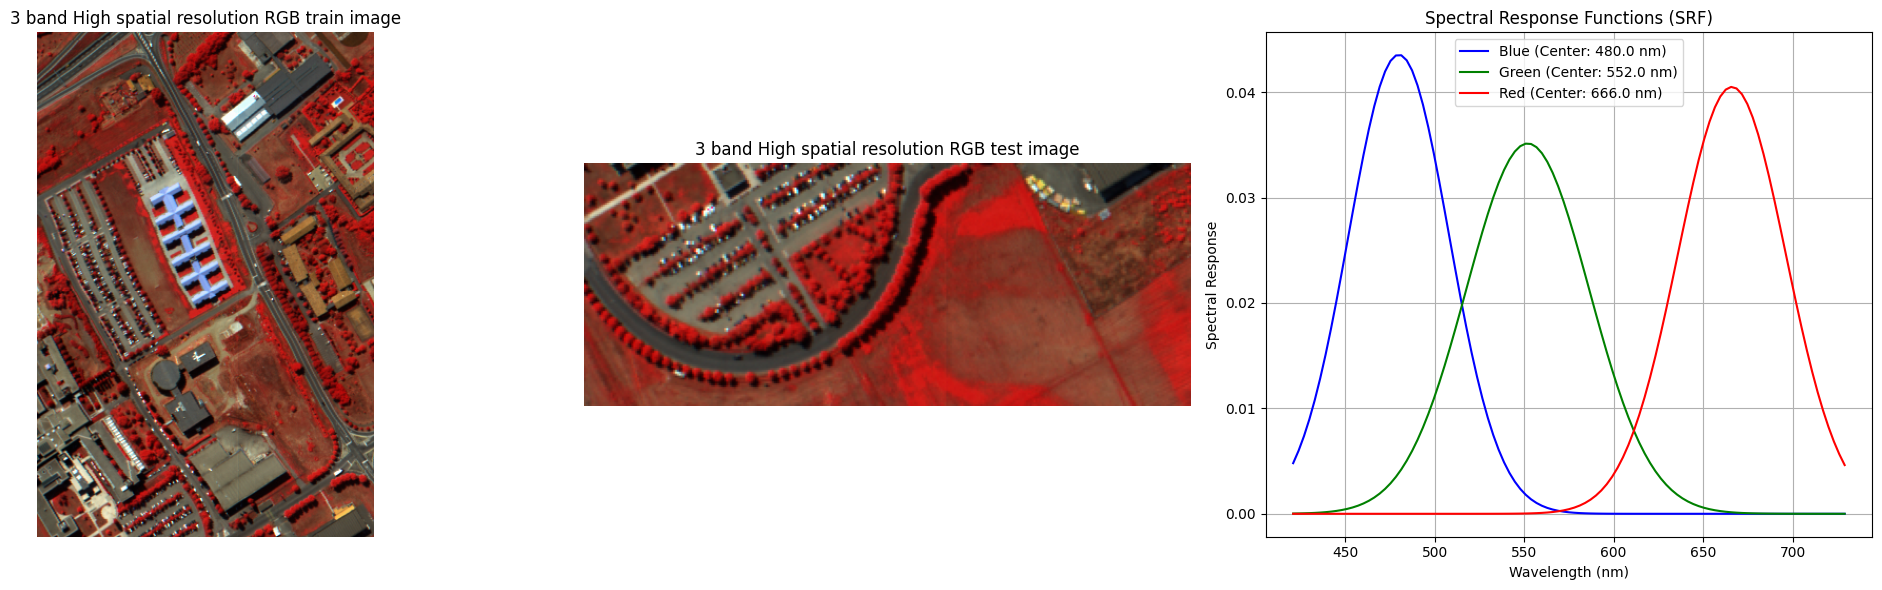

MSI train shape:  (480, 320, 4)
MSI test shape:  (128, 320, 4)


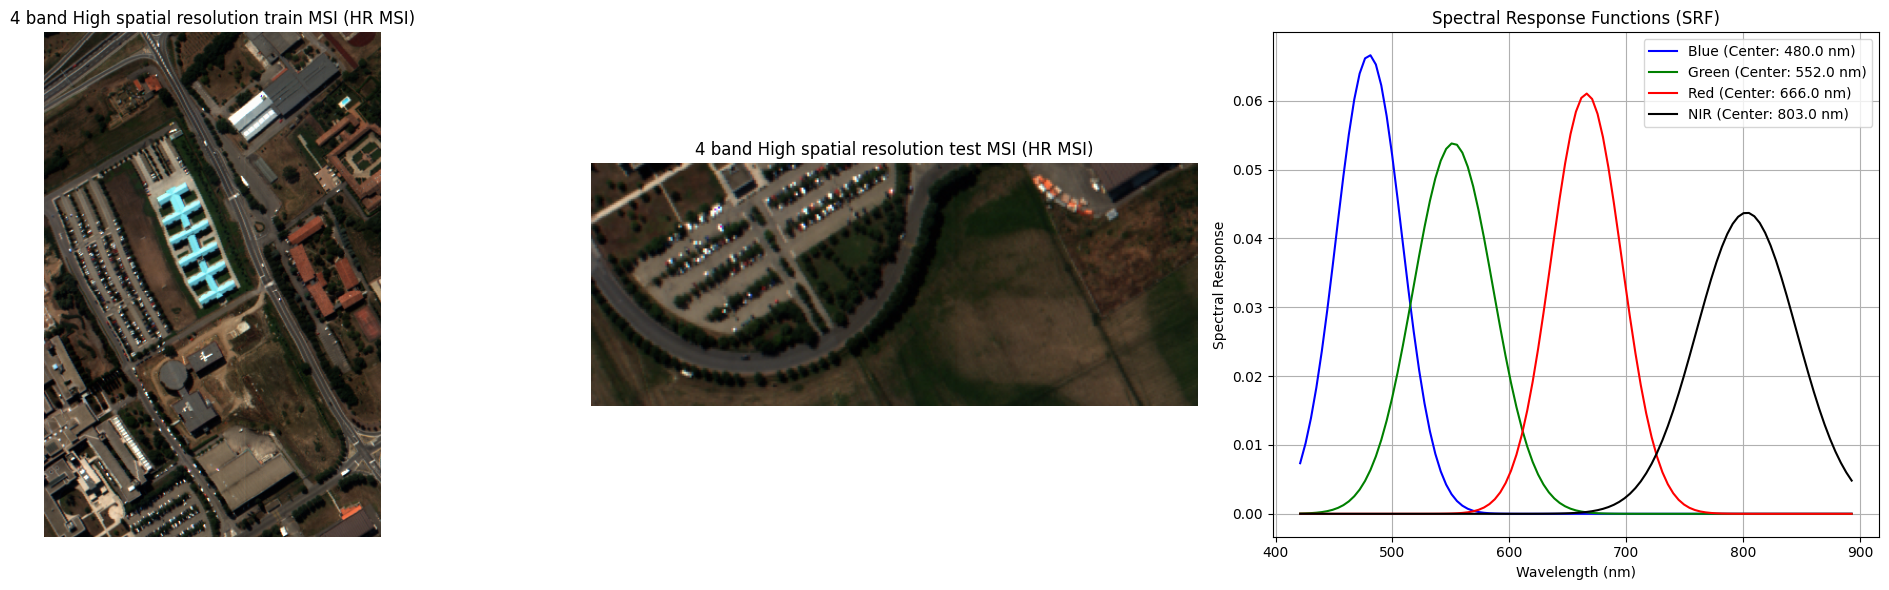

MSI train shape:  (480, 320, 8)
MSI test shape:  (128, 320, 8)


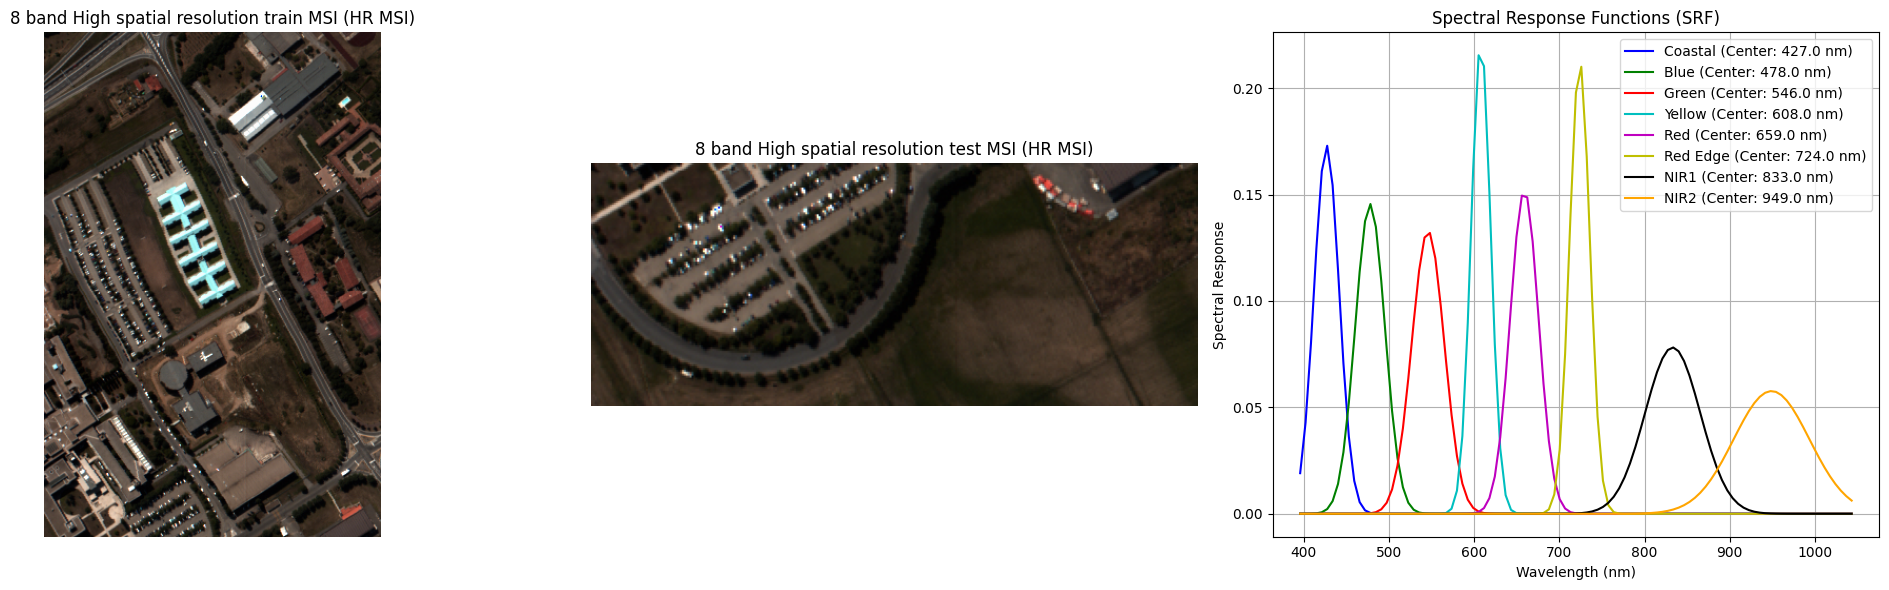

MSI train shape:  (480, 320, 16)
MSI test shape:  (128, 320, 16)


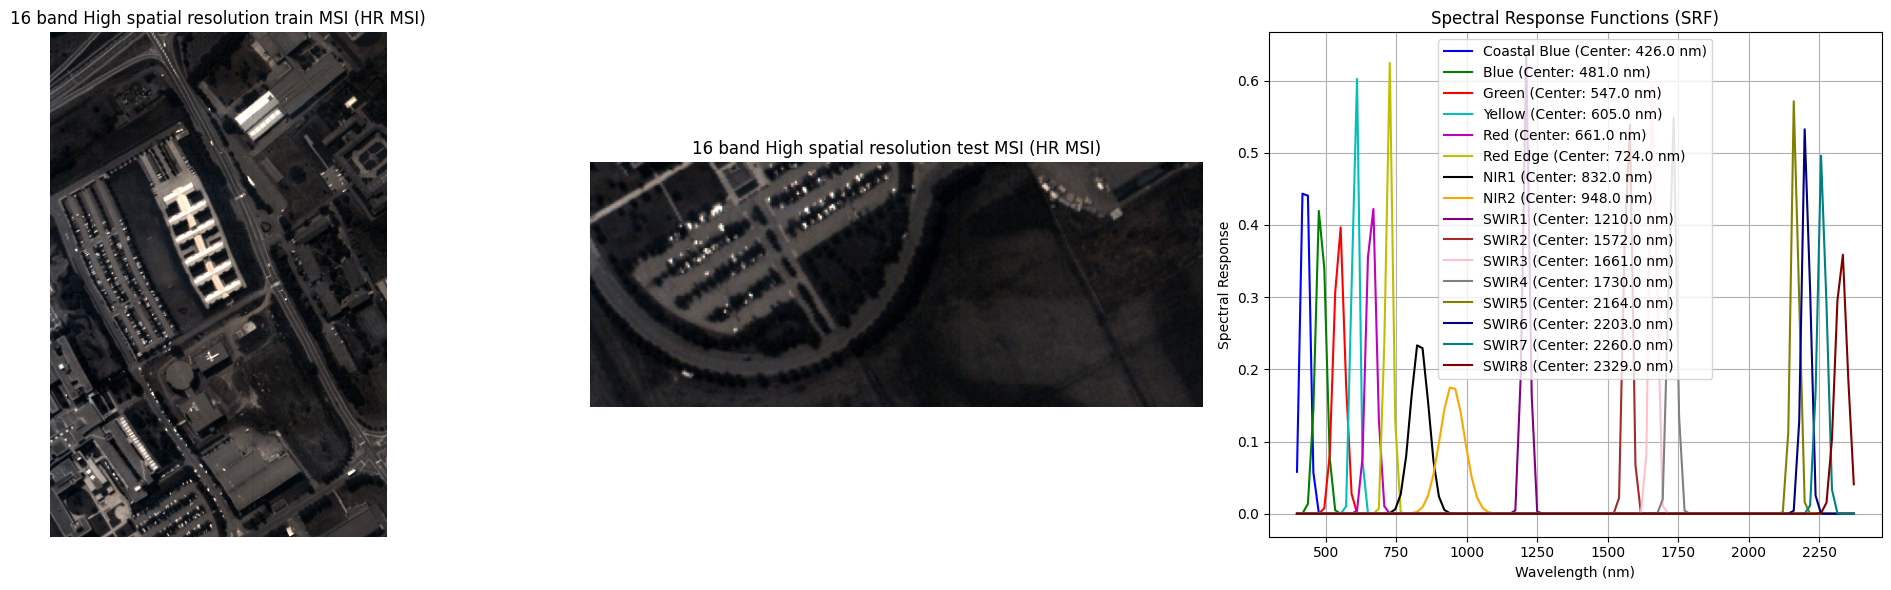

In [10]:
pavia_university = sio.loadmat(mat_file_path)
pavia_university_image = pavia_university['paviaU']
pavia_university_image = pavia_university_image[:608, :320, :]

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_university_image)
I_REF_train, I_REF_test = split_msi(I_REF)
print("Ground truth train shape: ", I_REF_train.shape)
print("Ground truth test shape: ", I_REF_test.shape)
visualize_hsi(I_REF_train, I_REF_test, (50,35,15), "Ground Truth Train (HR HSI)", "Ground Truth Test (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=1, fwhm_factor=4.2)
I_MS_1_train, I_MS_1_test = split_msi(I_MS_1)
print("MSI train shape: ", I_MS_1_train.shape)
print("MSI test shape: ", I_MS_1_test.shape)
plot_multispectral_with_srf(I_MS_1_train, I_MS_1_test, None, "1 band High spatial resolution pan train image", "1 band High spatial resolution pan test image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=3, fwhm_factor=4.2)
I_MS_3_train, I_MS_3_test = split_msi(I_MS_3)
print("MSI train shape: ", I_MS_3_train.shape)
print("MSI test shape: ", I_MS_3_test.shape)
plot_multispectral_with_srf(I_MS_3_train, I_MS_3_test, (2,1,0), "3 band High spatial resolution RGB train image", "3 band High spatial resolution RGB test image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=4, fwhm_factor=4.2)
I_MS_4_train, I_MS_4_test = split_msi(I_MS_4)
print("MSI train shape: ", I_MS_4_train.shape)
print("MSI test shape: ", I_MS_4_test.shape)
plot_multispectral_with_srf(I_MS_4_train, I_MS_4_test, (2,1,0), "4 band High spatial resolution train MSI (HR MSI)", "4 band High spatial resolution test MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=8, fwhm_factor=4.2)
I_MS_8_train, I_MS_8_test = split_msi(I_MS_8)
print("MSI train shape: ", I_MS_8_train.shape)
print("MSI test shape: ", I_MS_8_test.shape)
plot_multispectral_with_srf(I_MS_8_train, I_MS_8_test, (4,2,1), "8 band High spatial resolution train MSI (HR MSI)", "8 band High spatial resolution test MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=16, fwhm_factor=4.2)
I_MS_16_train, I_MS_16_test = split_msi(I_MS_16)
print("MSI train shape: ", I_MS_16_train.shape)
print("MSI test shape: ", I_MS_16_test.shape)
plot_multispectral_with_srf(I_MS_16_train, I_MS_16_test, (4,2,1), "16 band High spatial resolution train MSI (HR MSI)", "16 band High spatial resolution test MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


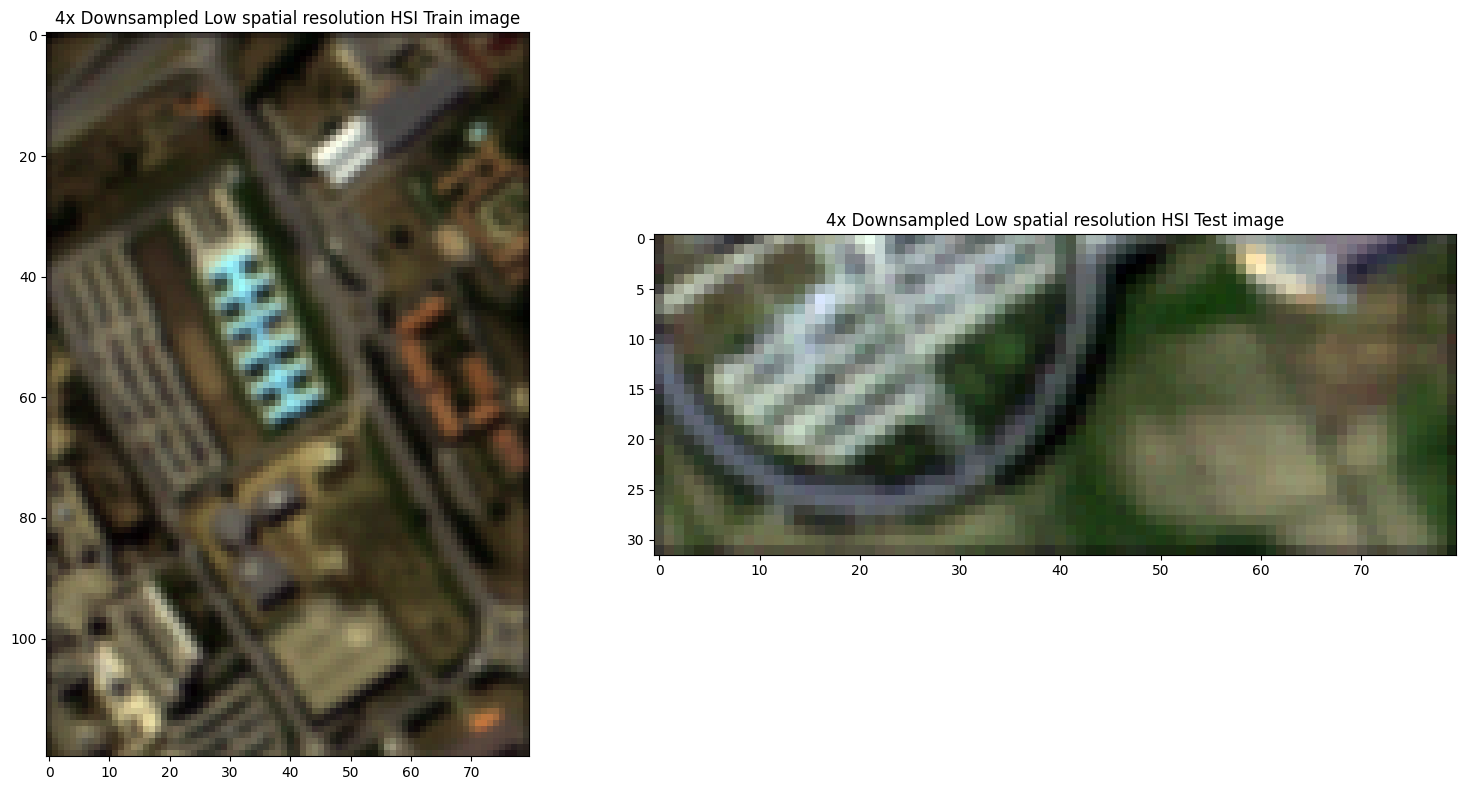

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


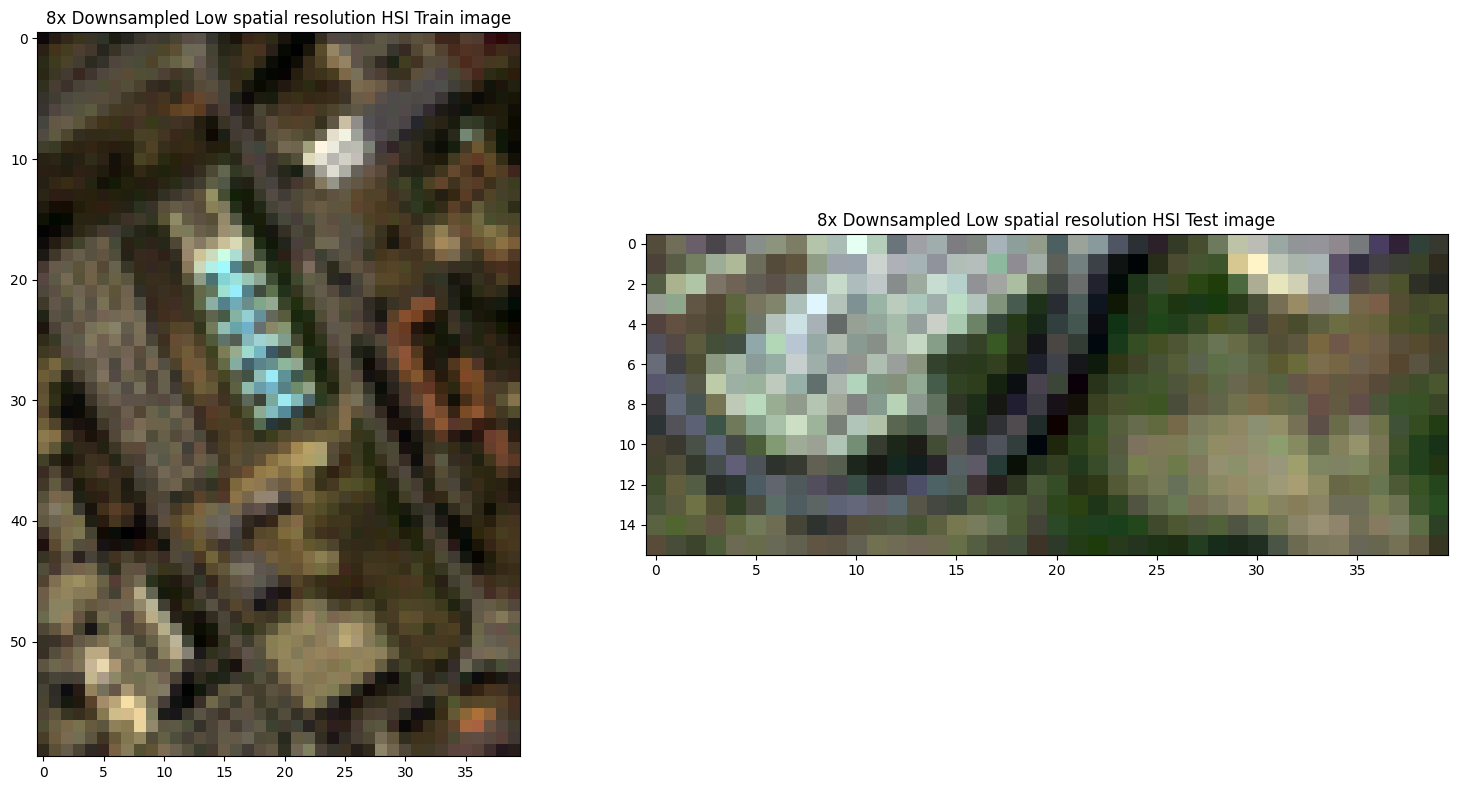

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


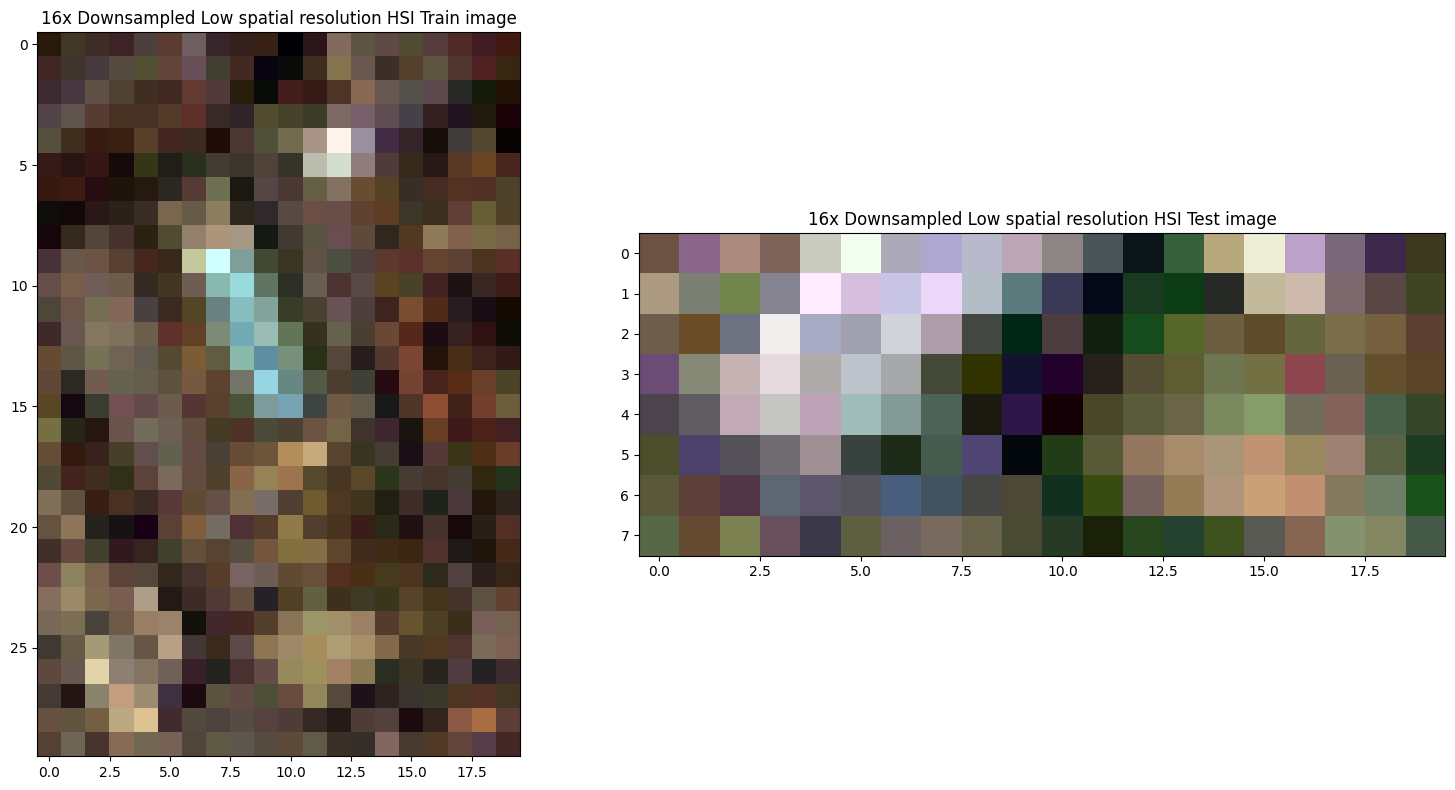

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


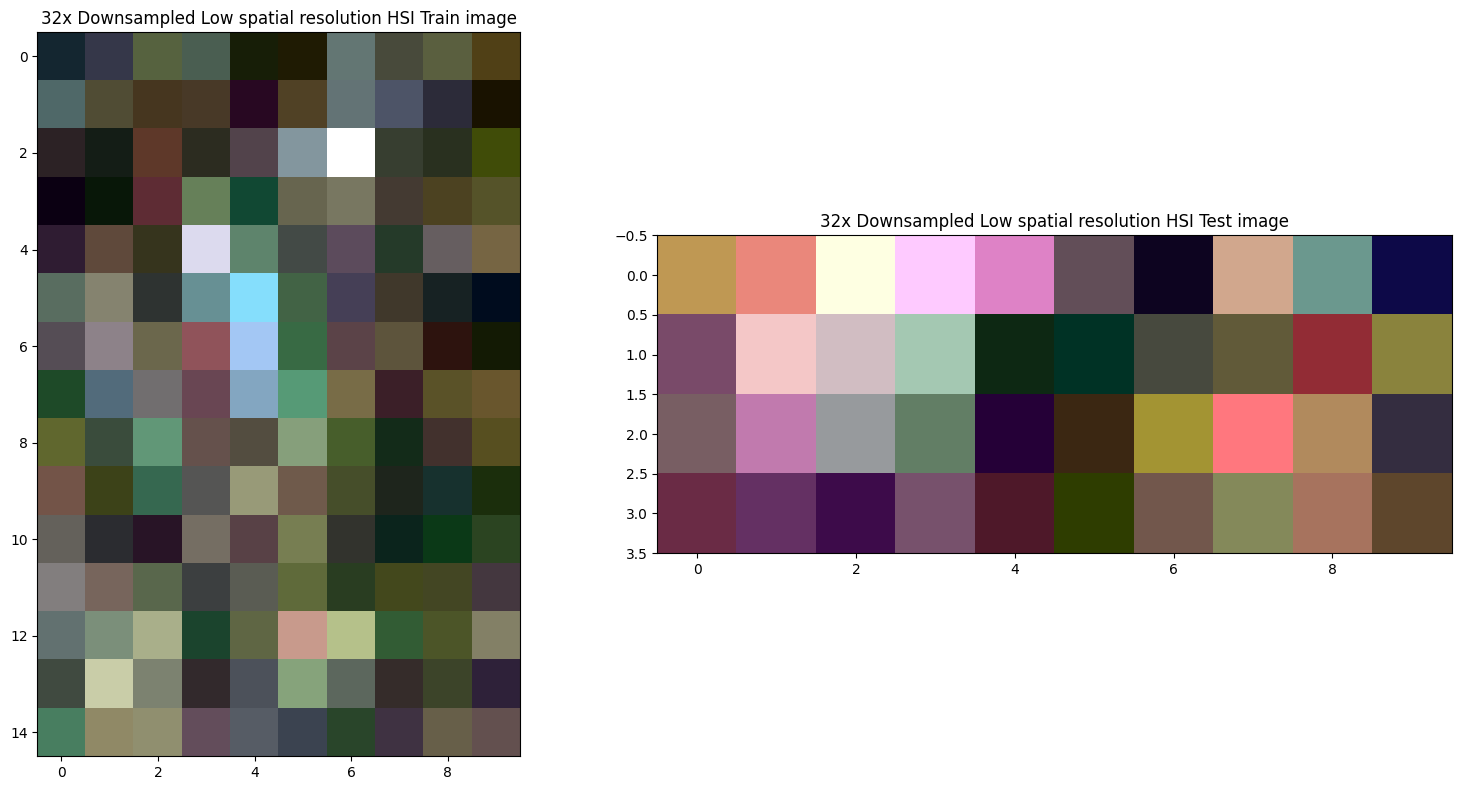

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(pavia_university_image, gaus_psf, 4, 35)
I_HS_4_train_gaus, I_HS_4_test_gaus = split_lr_hsi(I_HS_4_gaus, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_gaus.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_gaus.shape)
visualize_hsi(I_HS_4_train_gaus, I_HS_4_test_gaus, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_university_image, gaus_psf, 8, 30)
I_HS_8_train_gaus, I_HS_8_test_gaus = split_lr_hsi(I_HS_8_gaus, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_gaus.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_gaus.shape)
visualize_hsi(I_HS_8_train_gaus, I_HS_8_test_gaus, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(pavia_university_image, gaus_psf, 16, 25)
I_HS_16_train_gaus, I_HS_16_test_gaus = split_lr_hsi(I_HS_16_gaus, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_gaus.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_gaus.shape)
visualize_hsi(I_HS_16_train_gaus, I_HS_16_test_gaus, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(pavia_university_image, gaus_psf, 32, 20)
I_HS_32_train_gaus, I_HS_32_test_gaus = split_lr_hsi(I_HS_32_gaus, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_gaus.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_gaus.shape)
visualize_hsi(I_HS_32_train_gaus, I_HS_32_test_gaus, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


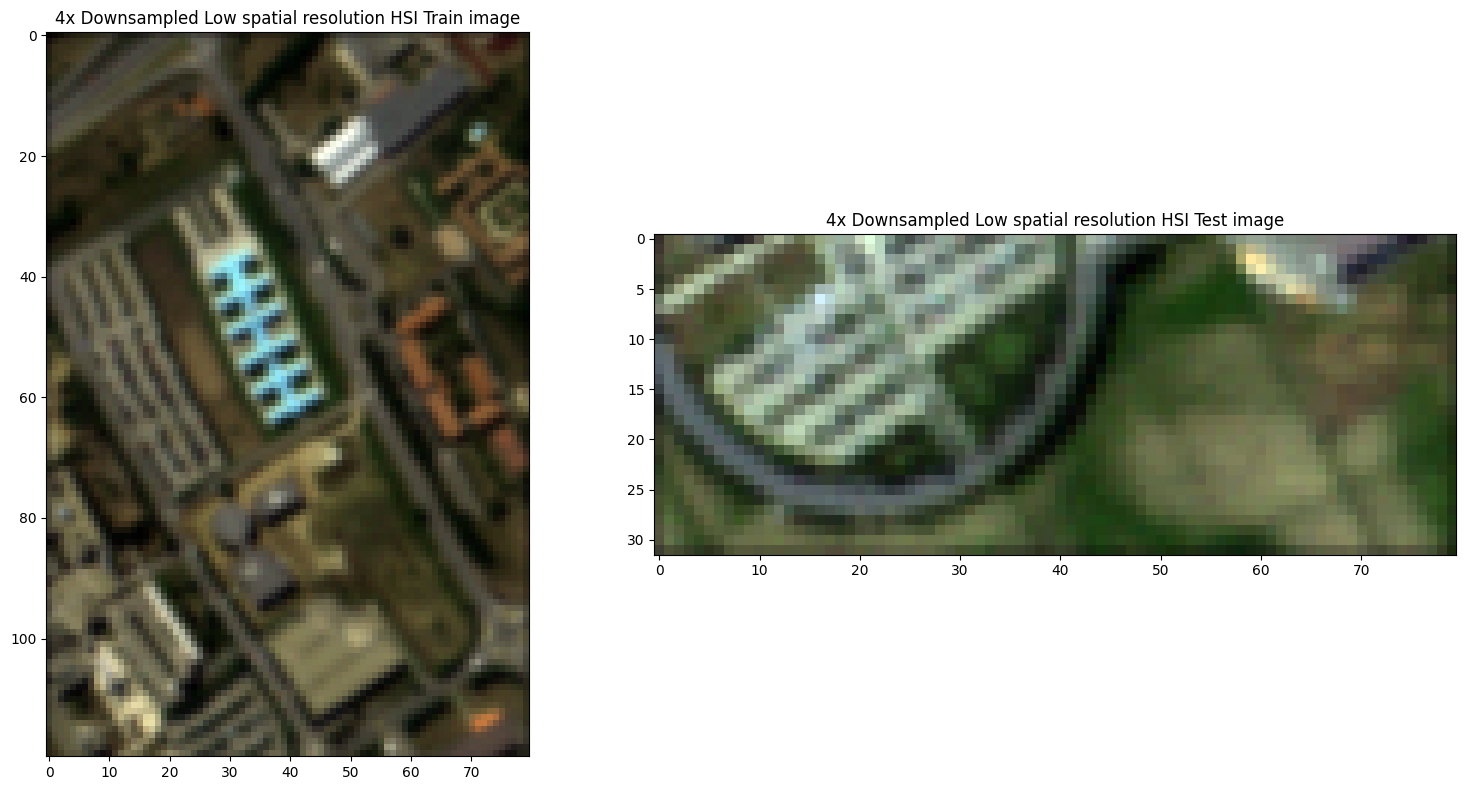

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


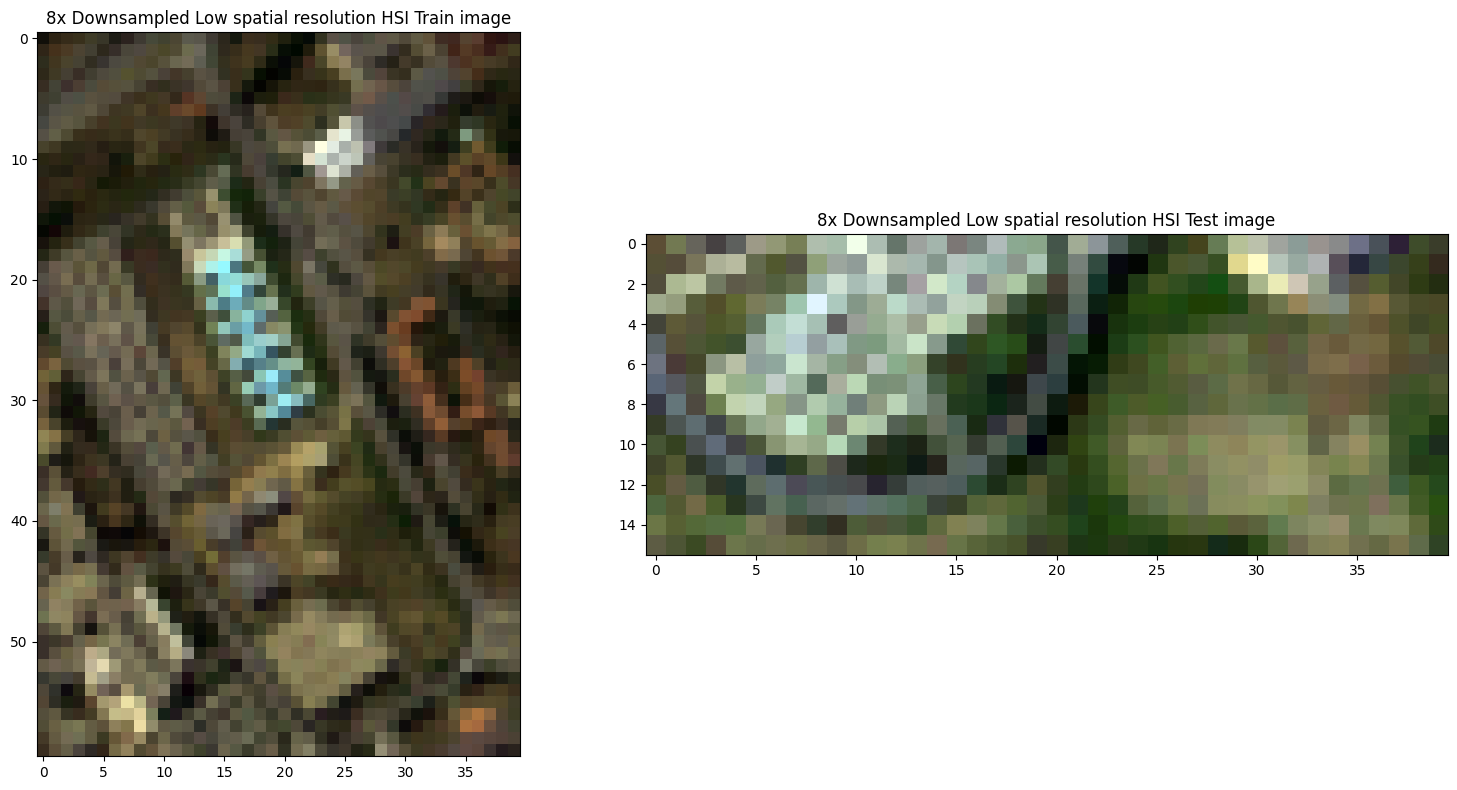

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


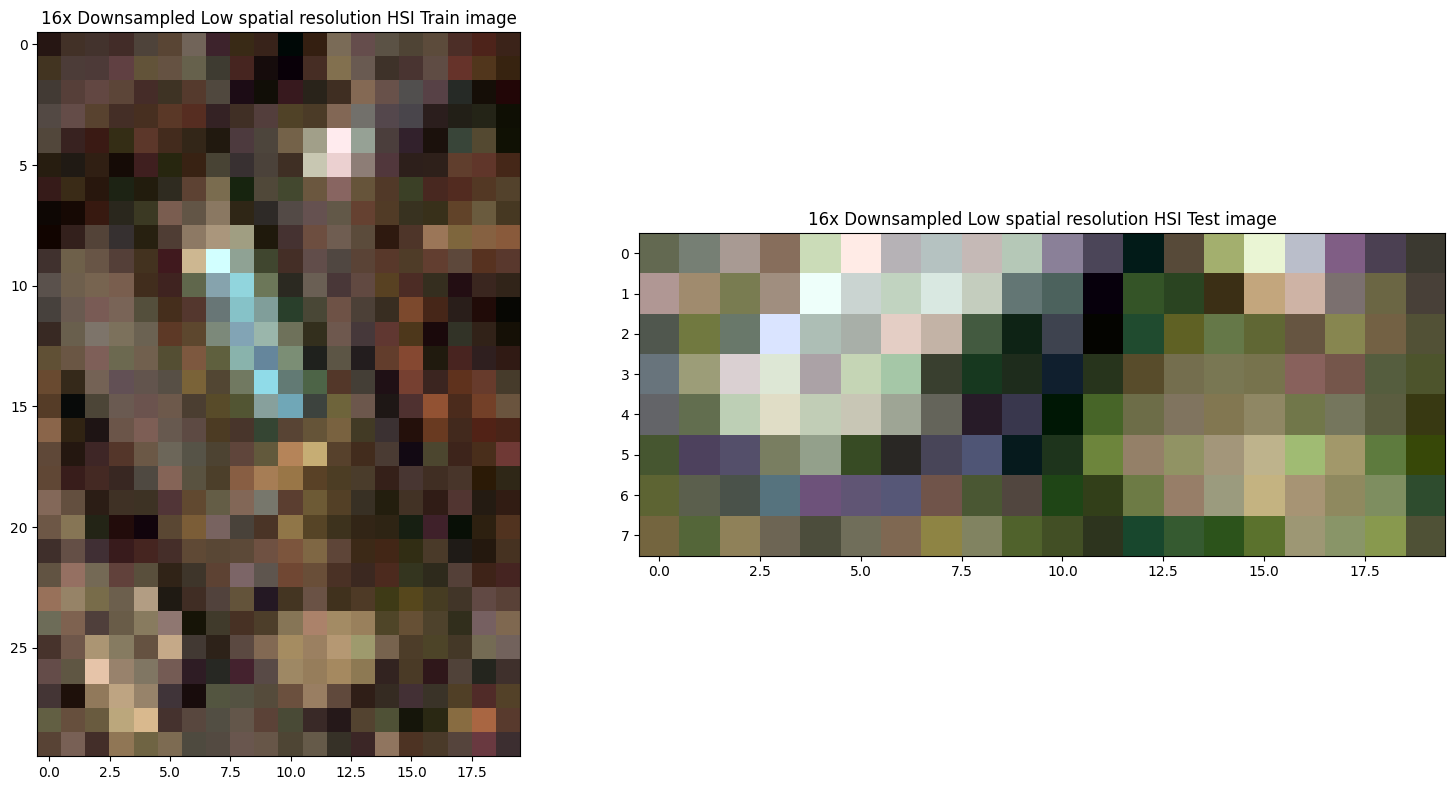

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


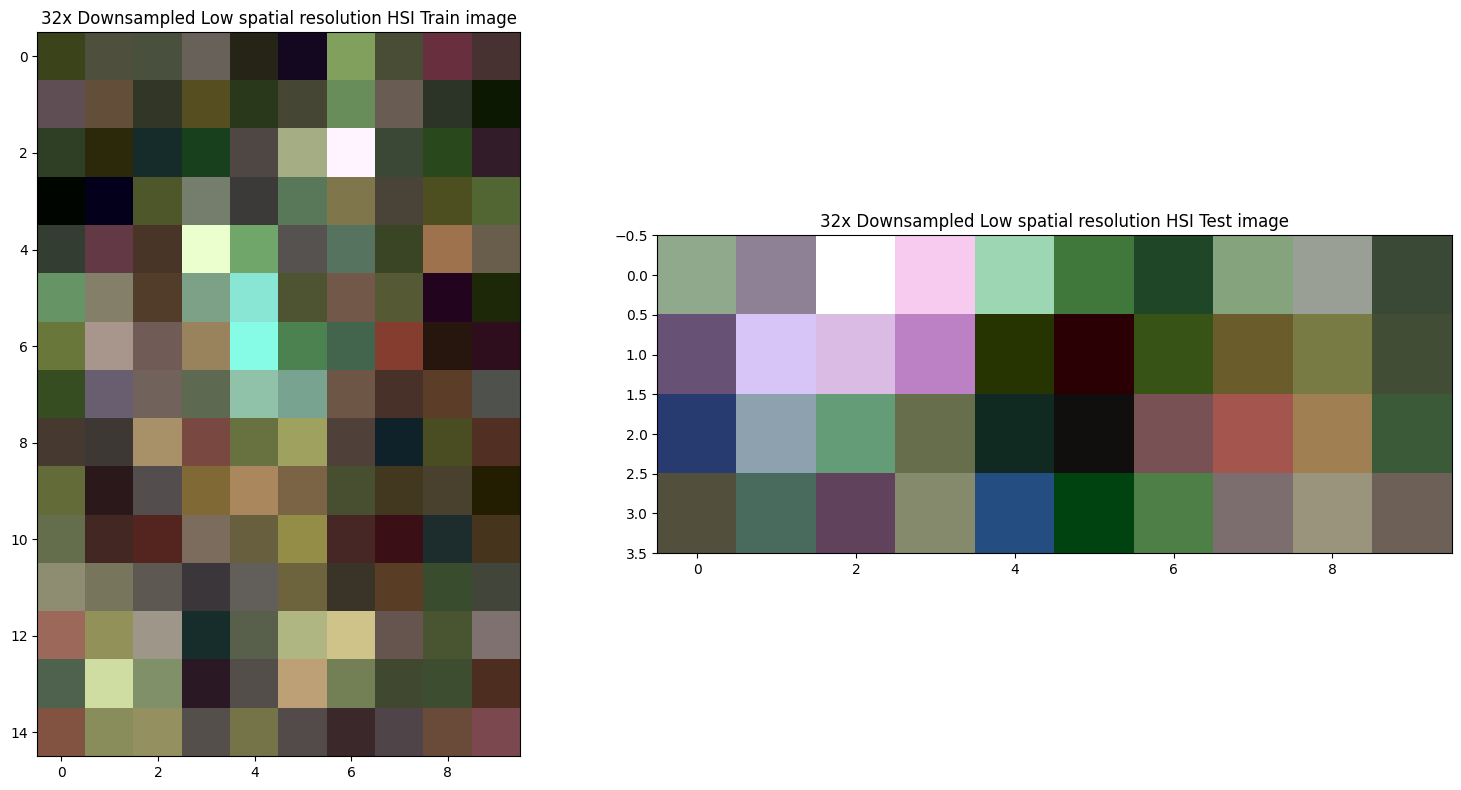

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(pavia_university_image, kol_psf, 4, 35)
I_HS_4_train_kol, I_HS_4_test_kol = split_lr_hsi(I_HS_4_kol, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_kol.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_kol.shape)
visualize_hsi(I_HS_4_train_kol, I_HS_4_test_kol, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(pavia_university_image, kol_psf, 8, 30)
I_HS_8_train_kol, I_HS_8_test_kol = split_lr_hsi(I_HS_8_kol, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_kol.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_kol.shape)
visualize_hsi(I_HS_8_train_kol, I_HS_8_test_kol, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(pavia_university_image, kol_psf, 16, 25)
I_HS_16_train_kol, I_HS_16_test_kol = split_lr_hsi(I_HS_16_kol, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_kol.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_kol.shape)
visualize_hsi(I_HS_16_train_kol, I_HS_16_test_kol, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(pavia_university_image, kol_psf, 32, 20)
I_HS_32_train_kol, I_HS_32_test_kol = split_lr_hsi(I_HS_32_kol, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_kol.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_kol.shape)
visualize_hsi(I_HS_32_train_kol, I_HS_32_test_kol, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Airy PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


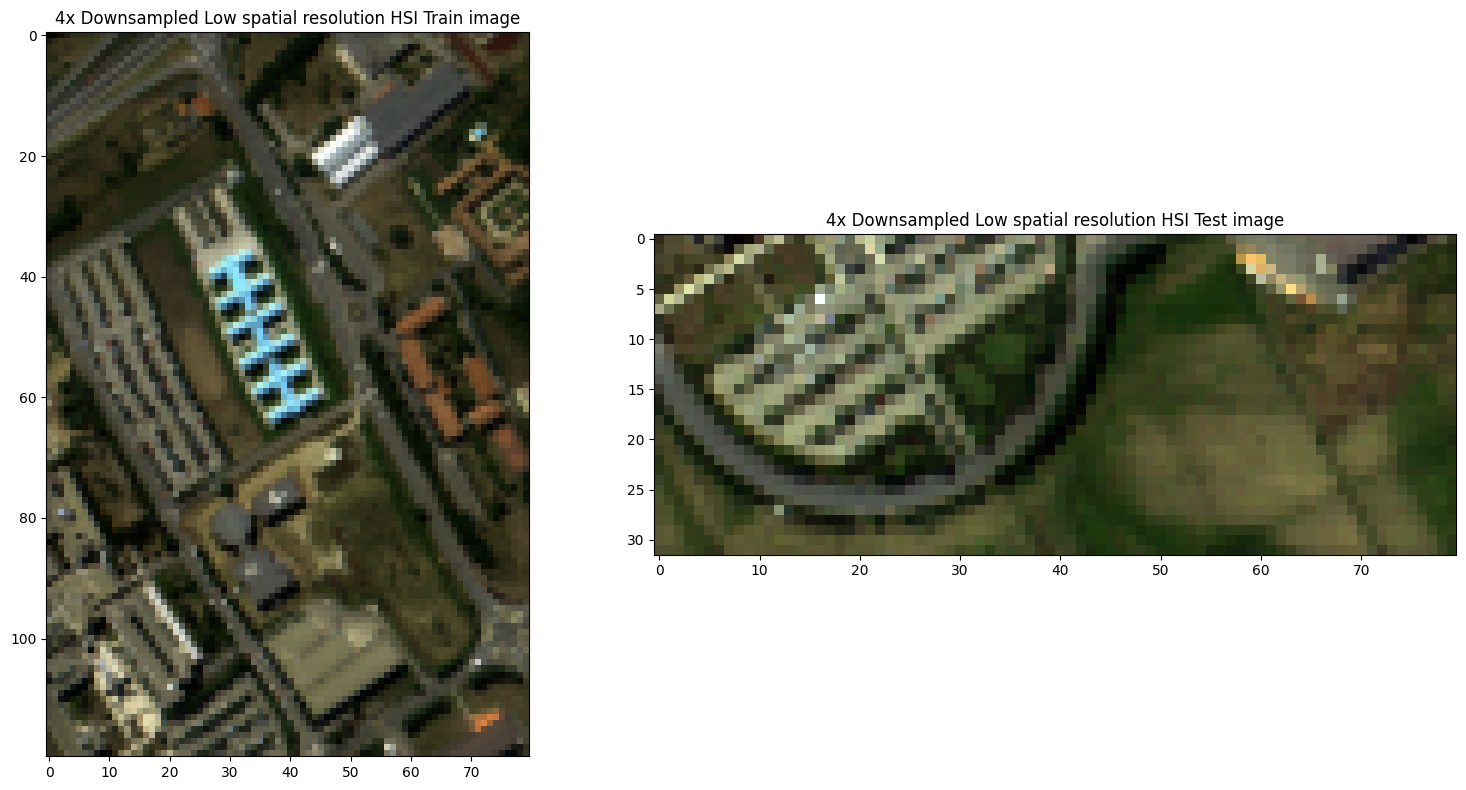

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


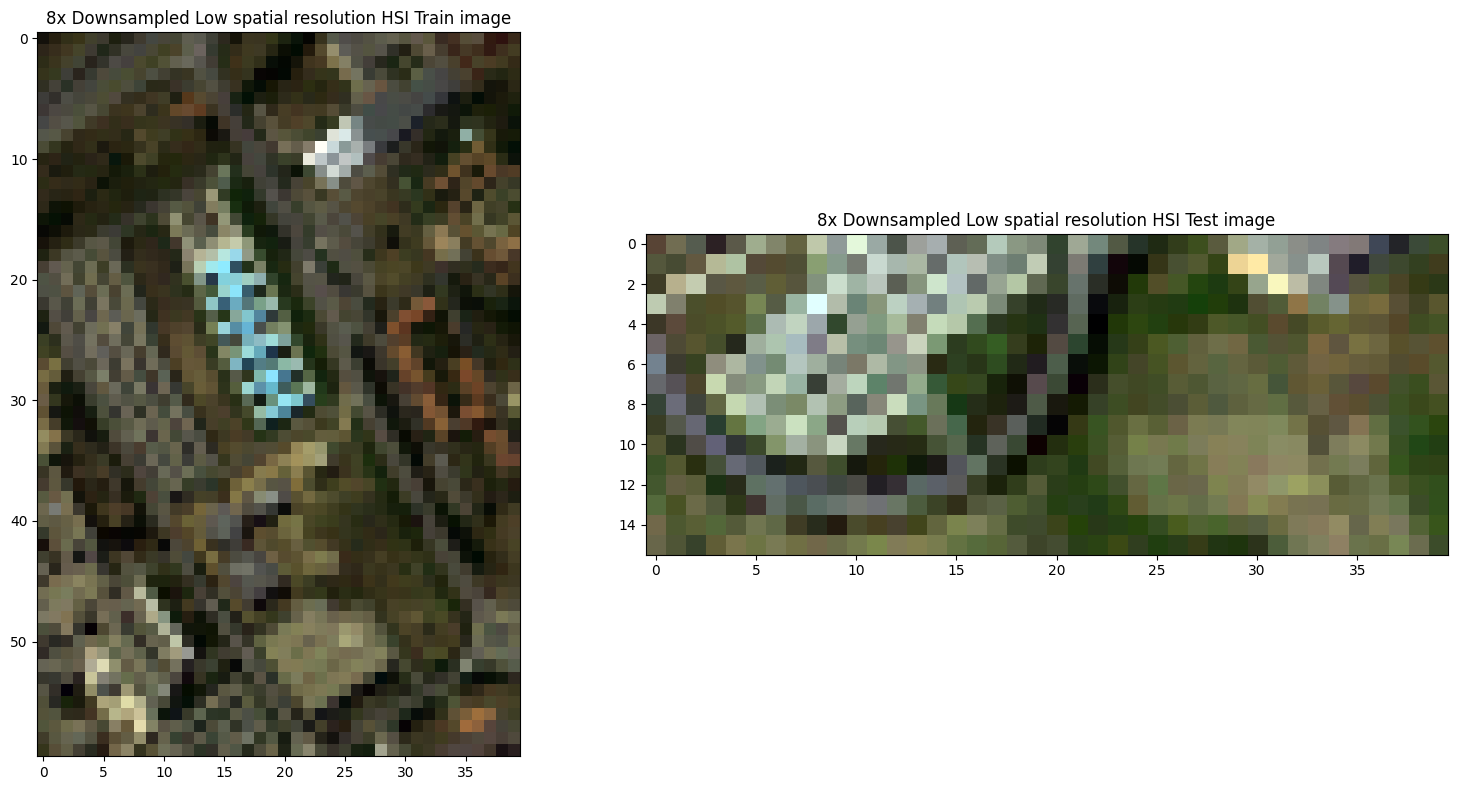

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


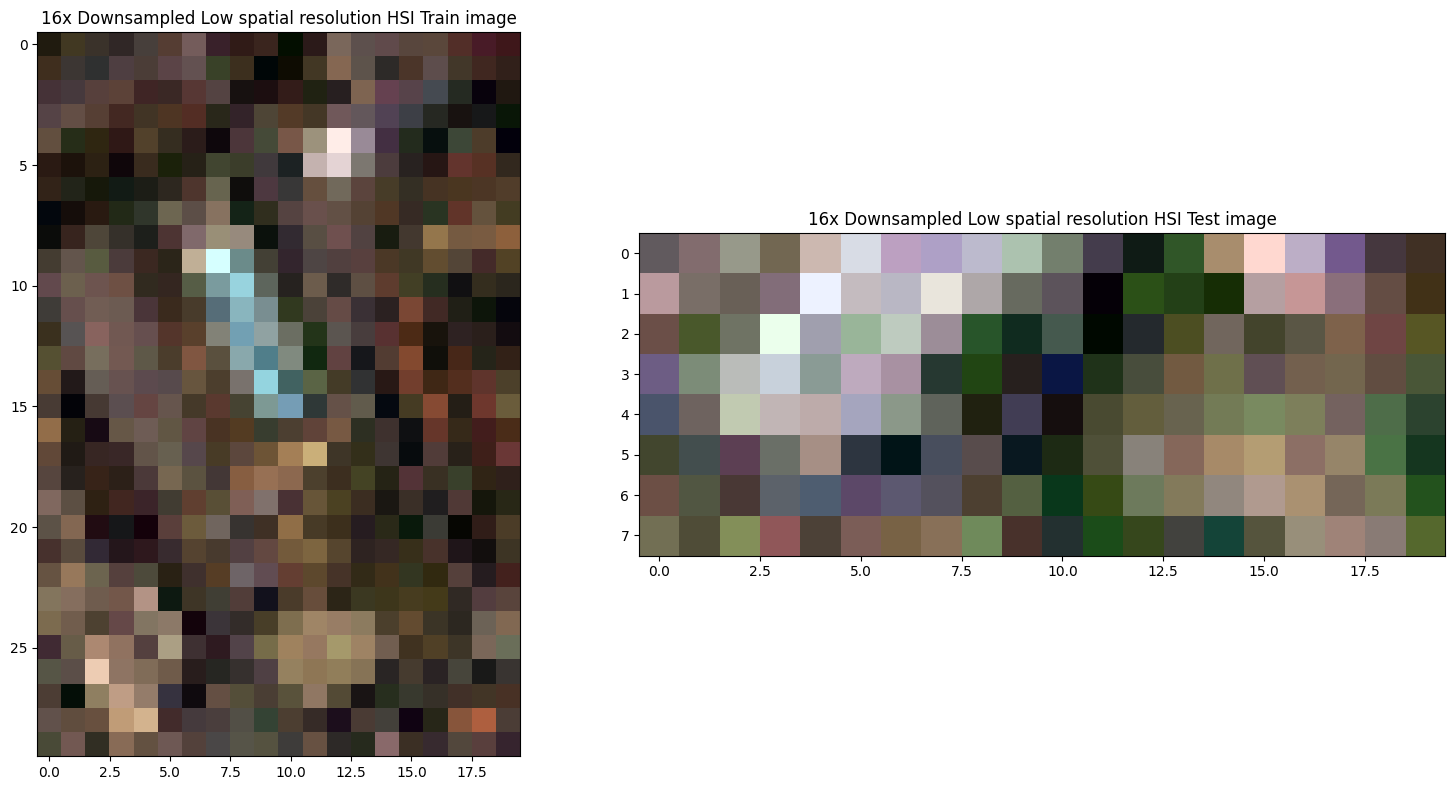

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


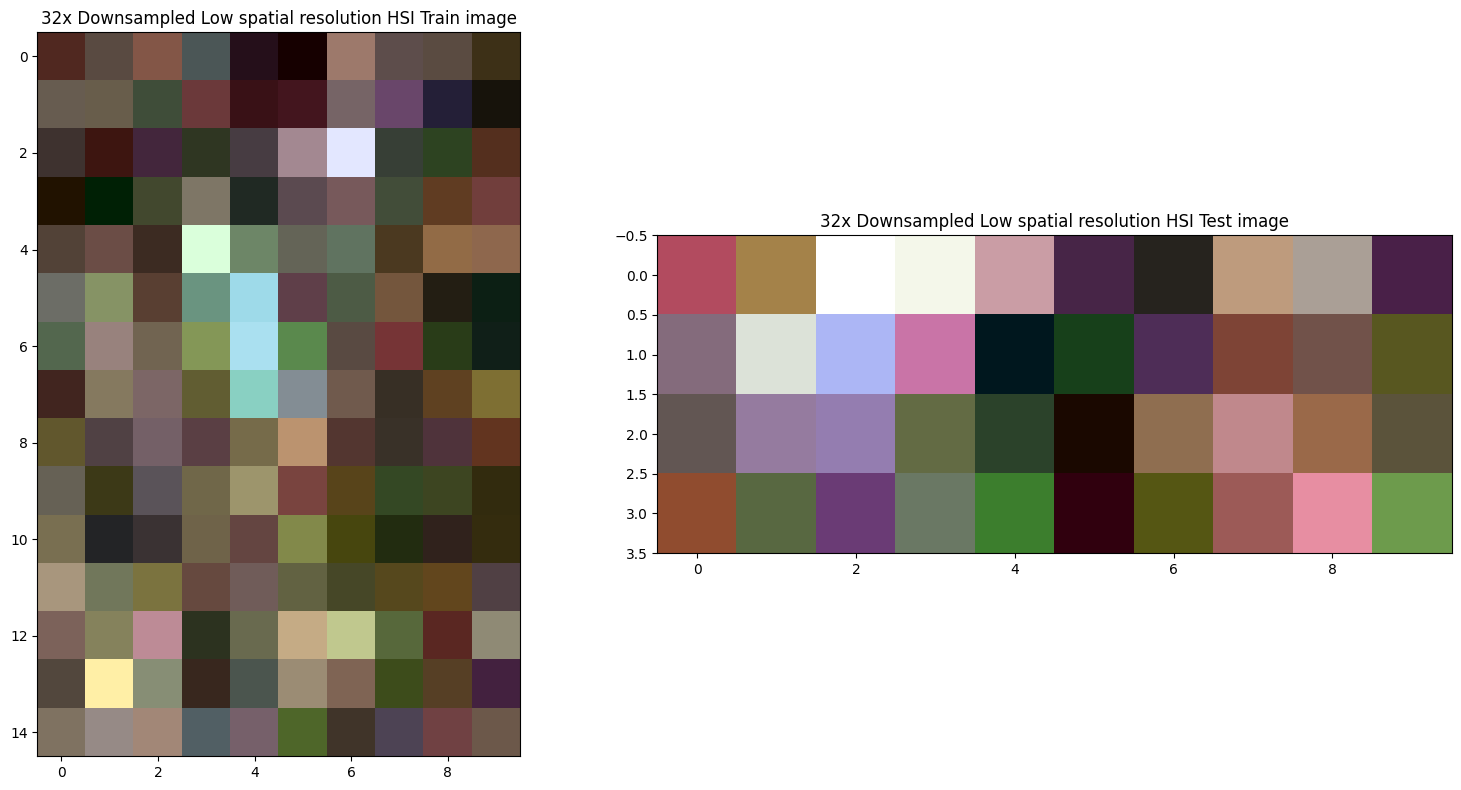

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(pavia_university_image, air_psf, 4, 35)
I_HS_4_train_air, I_HS_4_test_air = split_lr_hsi(I_HS_4_air, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_air.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_air.shape)
visualize_hsi(I_HS_4_train_air, I_HS_4_test_air, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(pavia_university_image, air_psf, 8, 30)
I_HS_8_train_air, I_HS_8_test_air = split_lr_hsi(I_HS_8_air, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_air.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_air.shape)
visualize_hsi(I_HS_8_train_air, I_HS_8_test_air, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(pavia_university_image, air_psf, 16, 25)
I_HS_16_train_air, I_HS_16_test_air = split_lr_hsi(I_HS_16_air, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_air.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_air.shape)
visualize_hsi(I_HS_16_train_air, I_HS_16_test_air, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(pavia_university_image, air_psf, 32, 20)
I_HS_32_train_air, I_HS_32_test_air = split_lr_hsi(I_HS_32_air, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_air.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_air.shape)
visualize_hsi(I_HS_32_train_air, I_HS_32_test_air, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Moffat PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


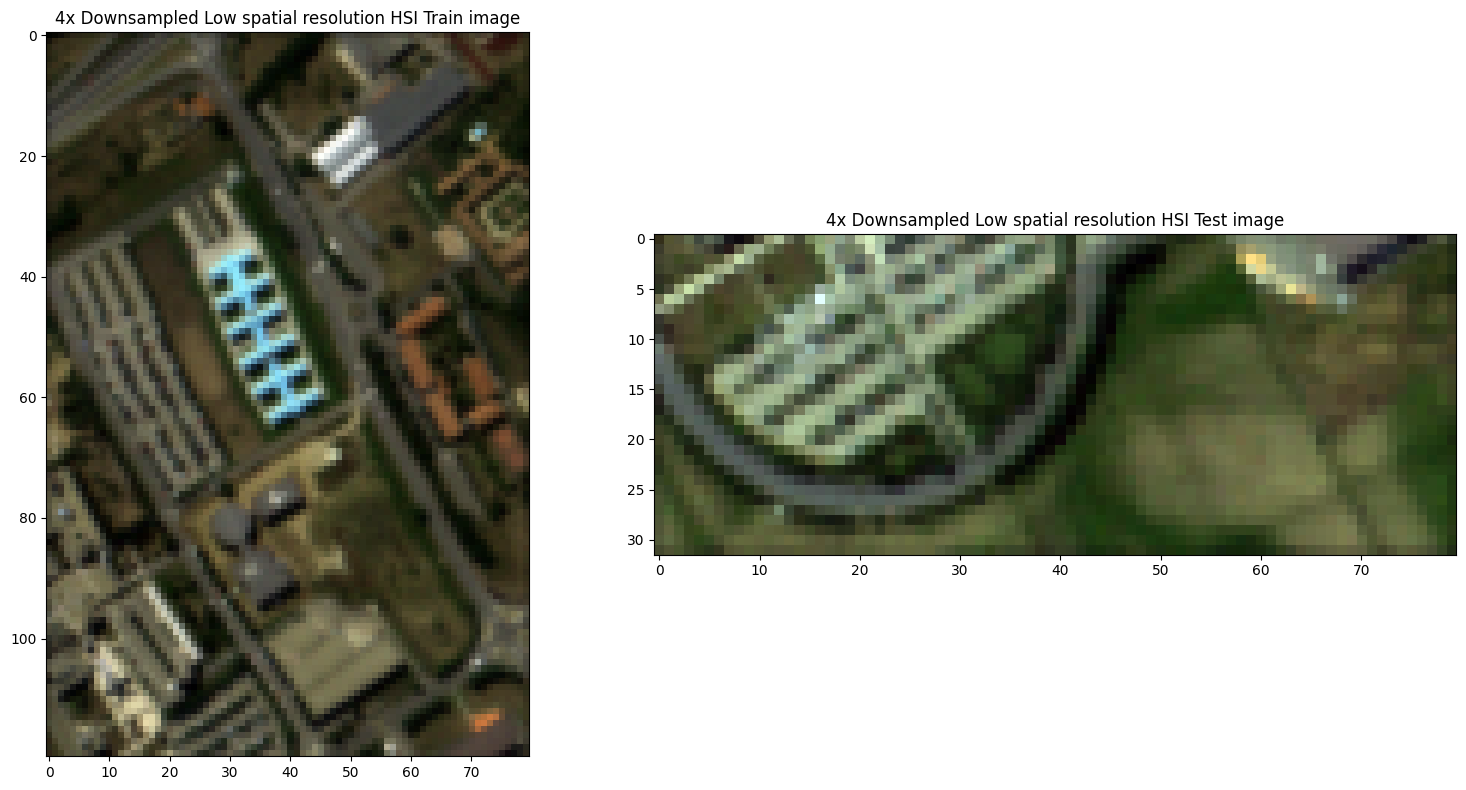

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


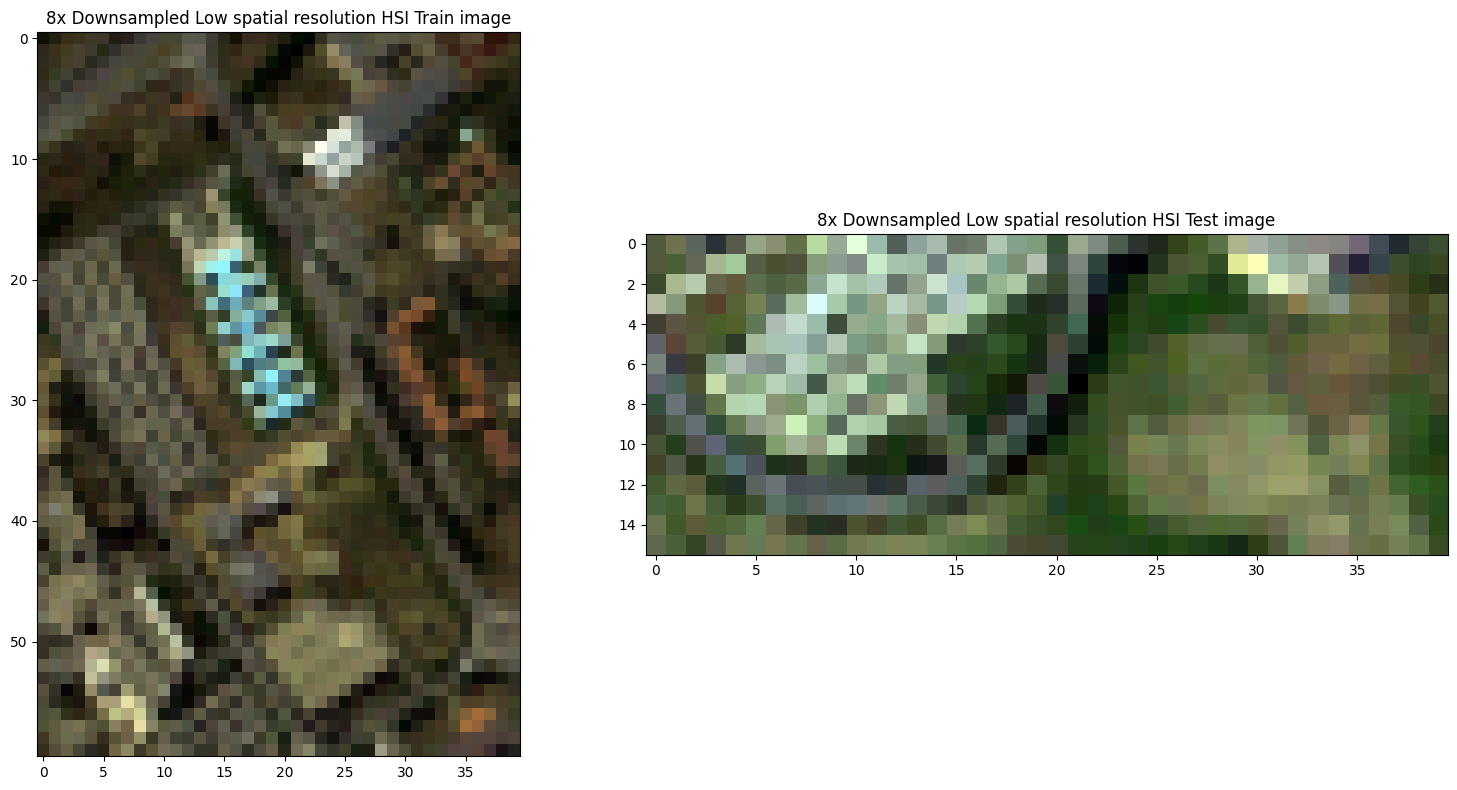

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


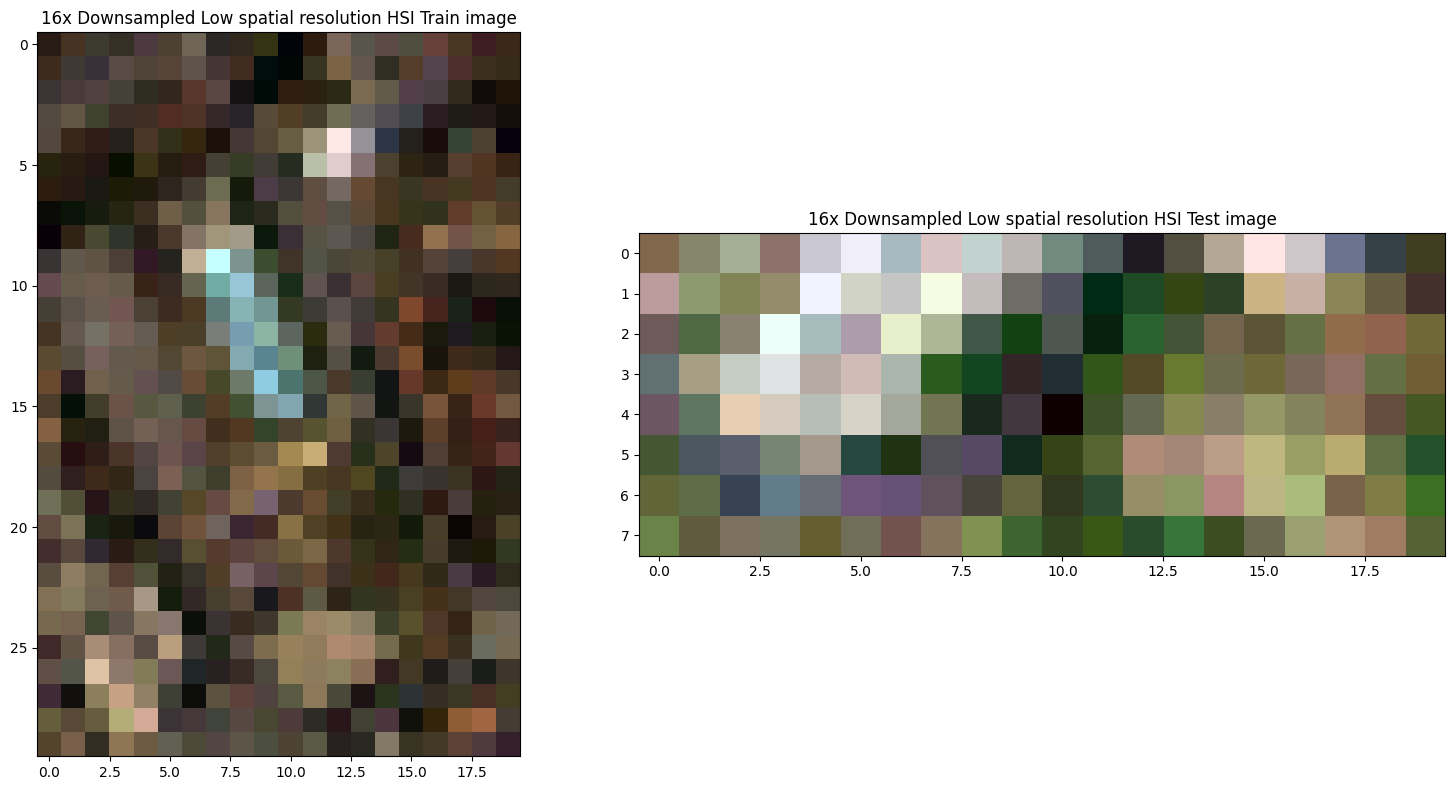

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


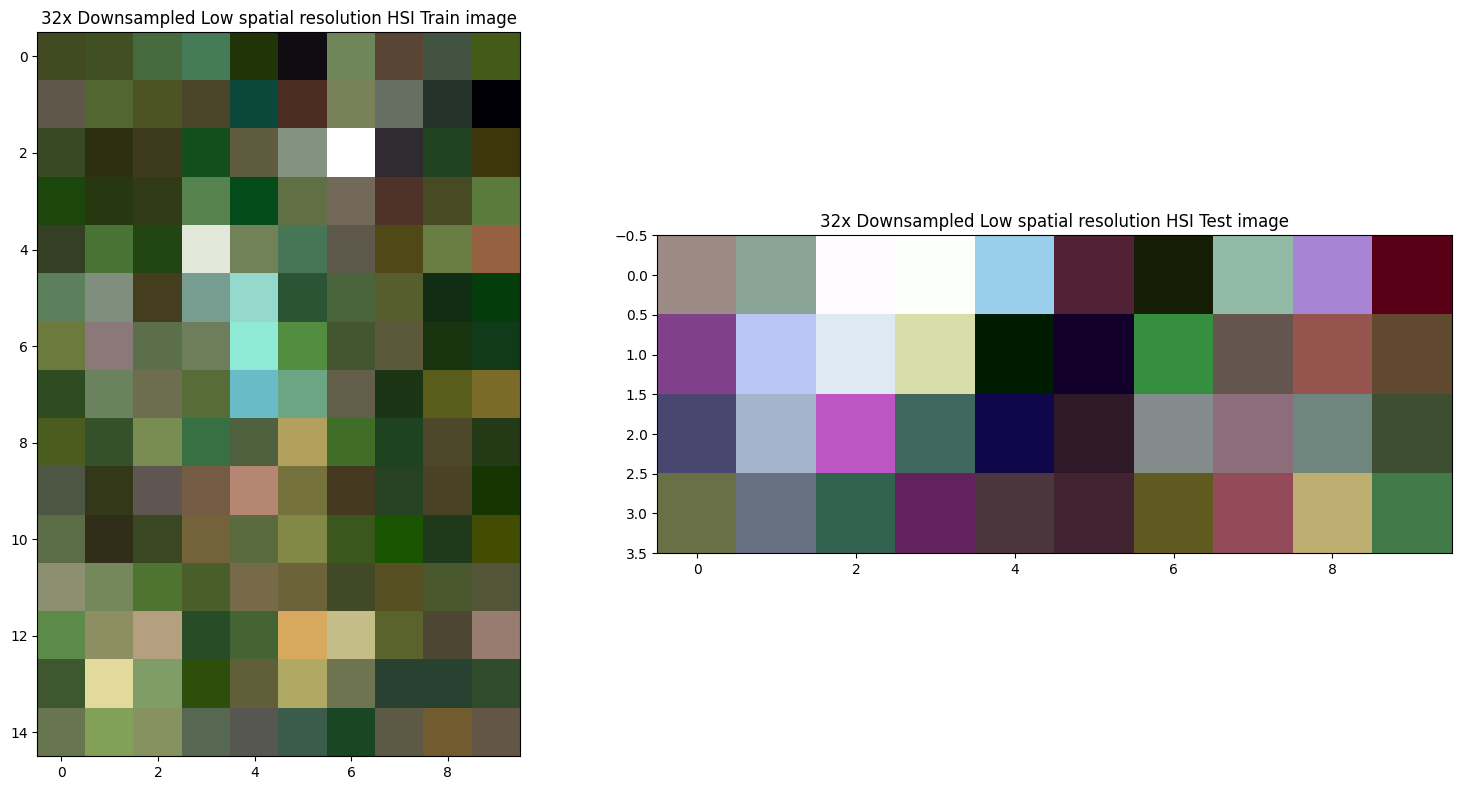

In [14]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(pavia_university_image, mof_psf, 4, 35)
I_HS_4_train_mof, I_HS_4_test_mof = split_lr_hsi(I_HS_4_mof, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_mof.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_mof.shape)
visualize_hsi(I_HS_4_train_mof, I_HS_4_test_mof, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(pavia_university_image, mof_psf, 8, 30)
I_HS_8_train_mof, I_HS_8_test_mof = split_lr_hsi(I_HS_8_mof, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_mof.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_mof.shape)
visualize_hsi(I_HS_8_train_mof, I_HS_8_test_mof, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(pavia_university_image, mof_psf, 16, 25)
I_HS_16_train_mof, I_HS_16_test_mof = split_lr_hsi(I_HS_16_mof, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_mof.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_mof.shape)
visualize_hsi(I_HS_16_train_mof, I_HS_16_test_mof, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(pavia_university_image, mof_psf, 32, 20)
I_HS_32_train_mof, I_HS_32_test_mof = split_lr_hsi(I_HS_32_mof, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_mof.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_mof.shape)
visualize_hsi(I_HS_32_train_mof, I_HS_32_test_mof, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Sinc PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


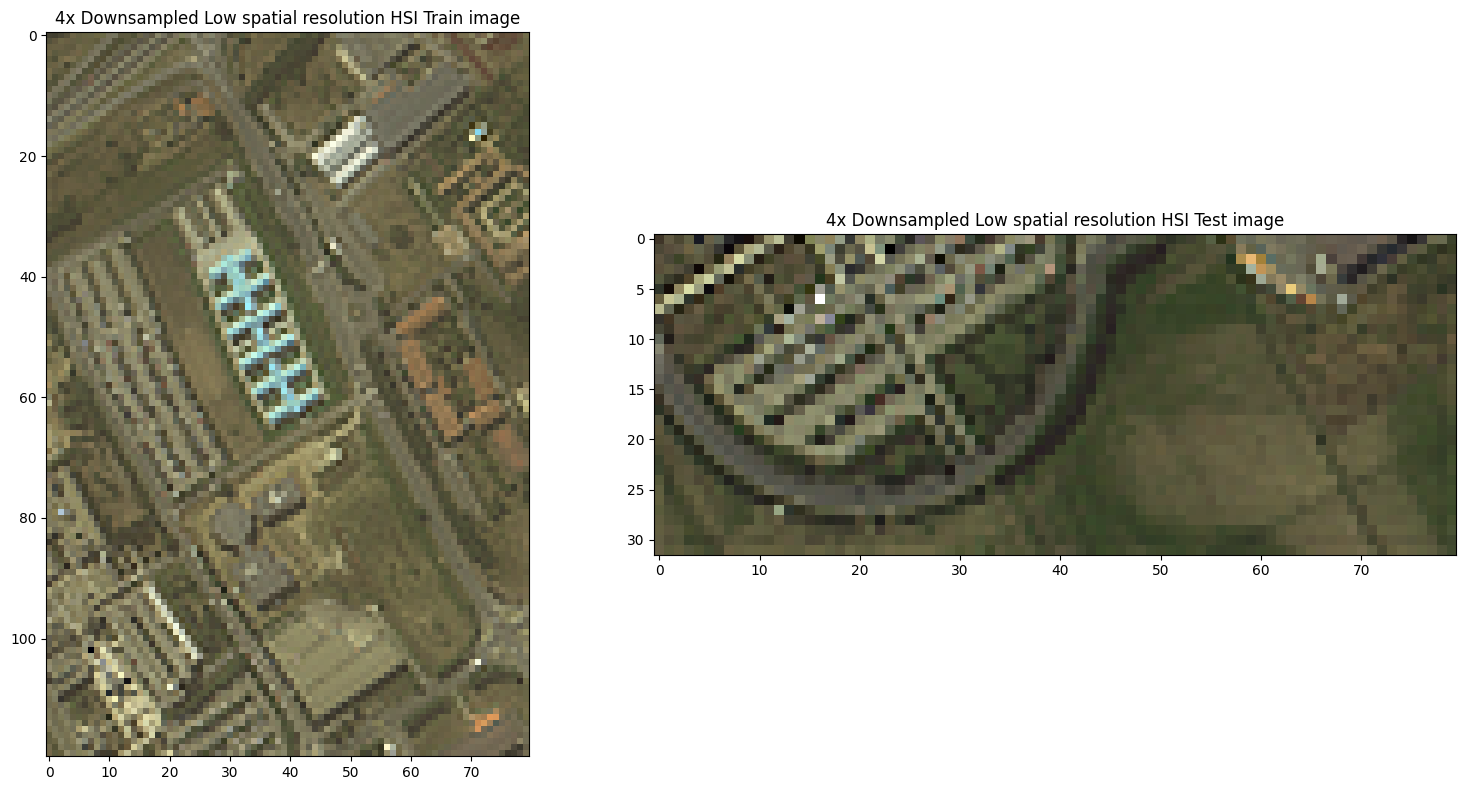

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


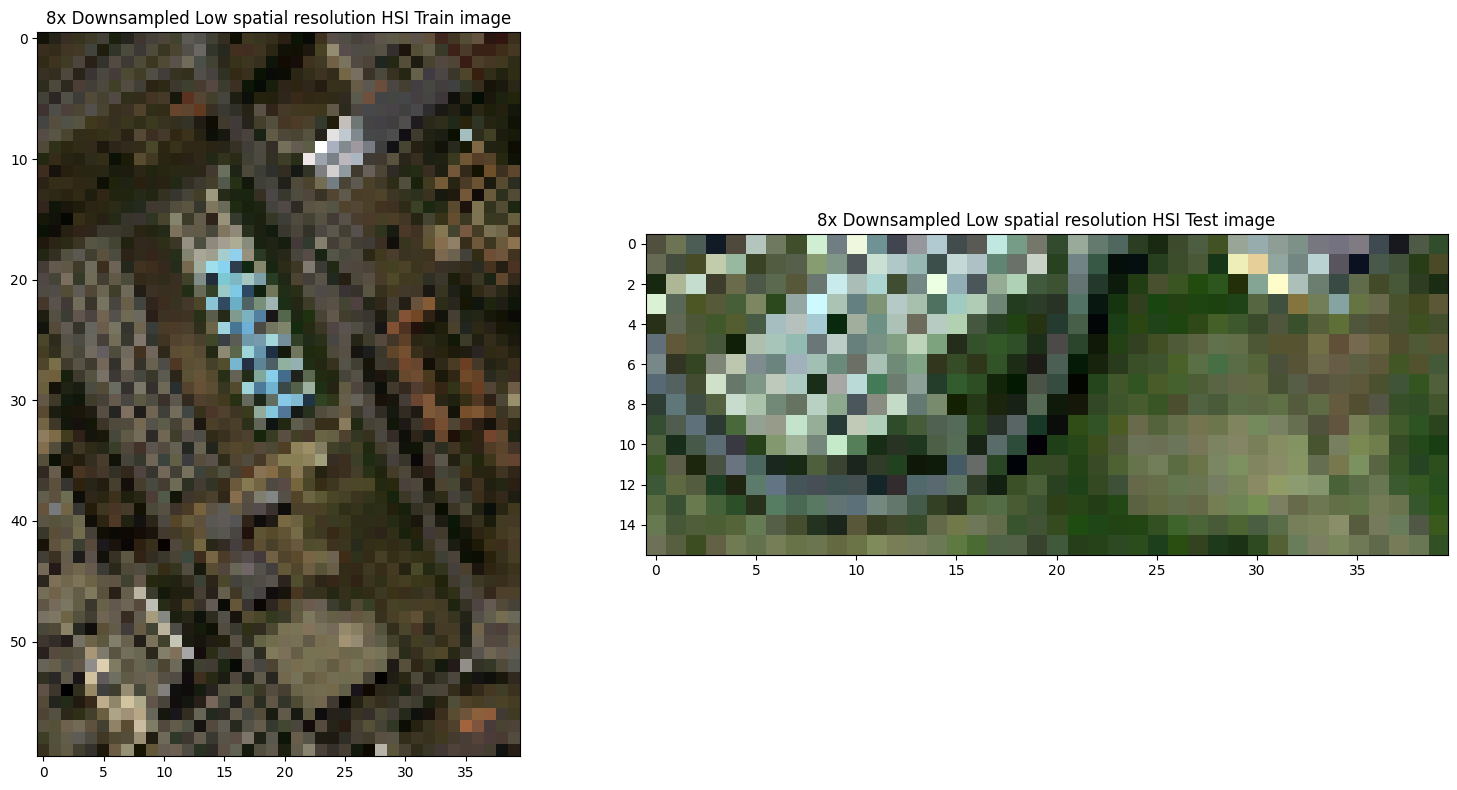

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


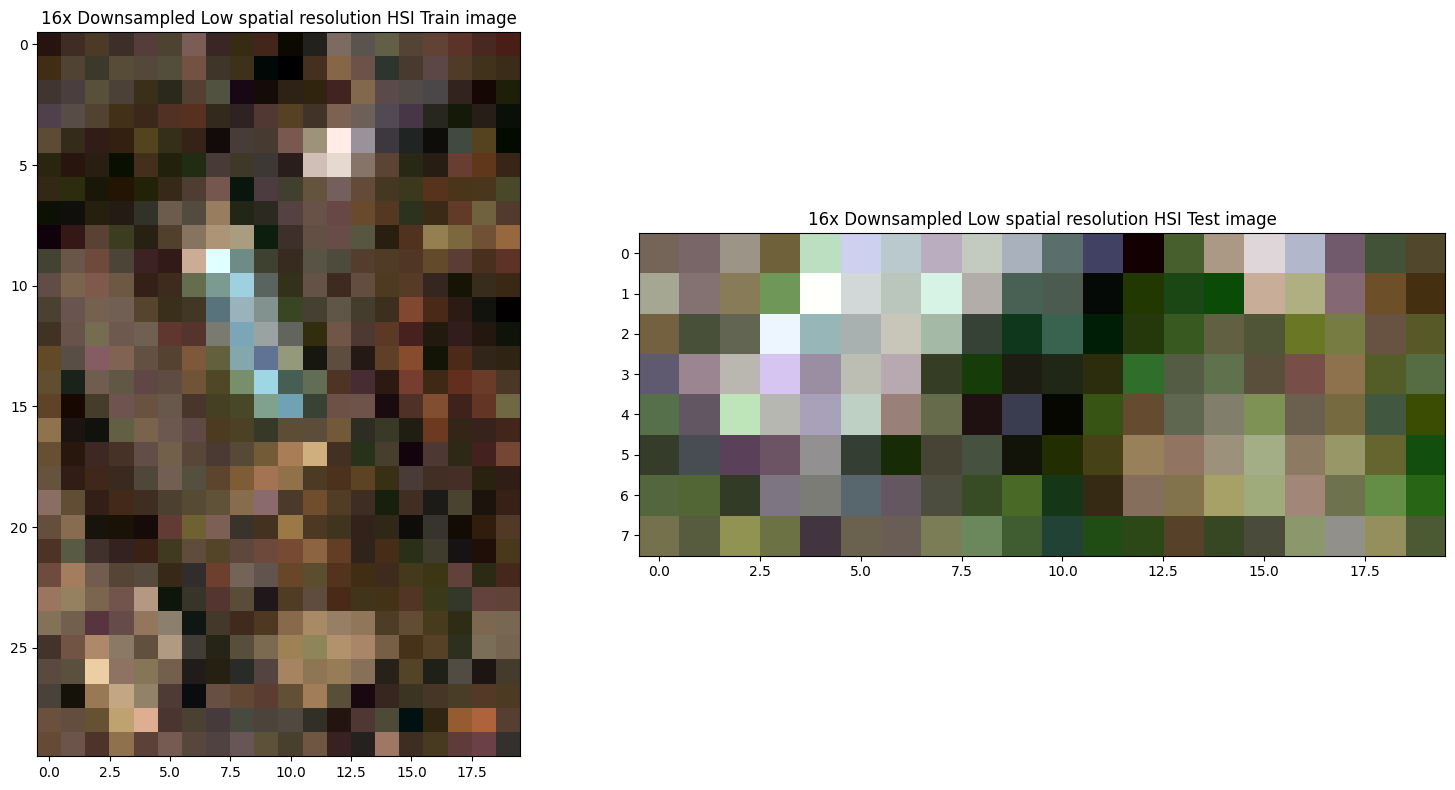

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


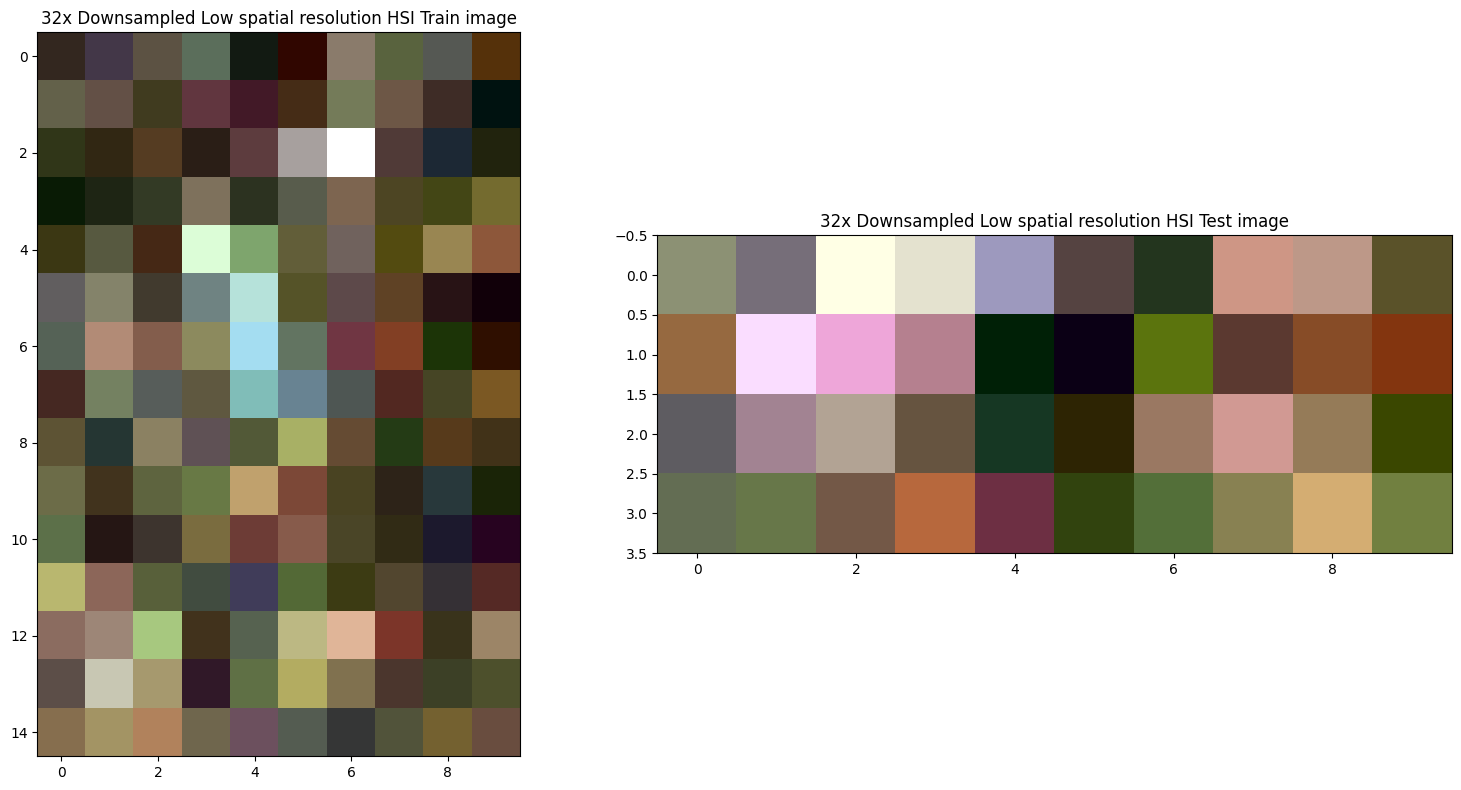

In [15]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(pavia_university_image, sinc_psf, 4, 35)
I_HS_4_train_sinc, I_HS_4_test_sinc = split_lr_hsi(I_HS_4_sinc, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_sinc.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_sinc.shape)
visualize_hsi(I_HS_4_train_sinc, I_HS_4_test_sinc, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(pavia_university_image, sinc_psf, 8, 30)
I_HS_8_train_sinc, I_HS_8_test_sinc = split_lr_hsi(I_HS_8_sinc, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_sinc.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_sinc.shape)
visualize_hsi(I_HS_8_train_sinc, I_HS_8_test_sinc, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(pavia_university_image, sinc_psf, 16, 25)
I_HS_16_train_sinc, I_HS_16_test_sinc = split_lr_hsi(I_HS_16_sinc, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_sinc.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_sinc.shape)
visualize_hsi(I_HS_16_train_sinc, I_HS_16_test_sinc, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(pavia_university_image, sinc_psf, 32, 20)
I_HS_32_train_sinc, I_HS_32_test_sinc = split_lr_hsi(I_HS_32_sinc, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_sinc.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_sinc.shape)
visualize_hsi(I_HS_32_train_sinc, I_HS_32_test_sinc, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


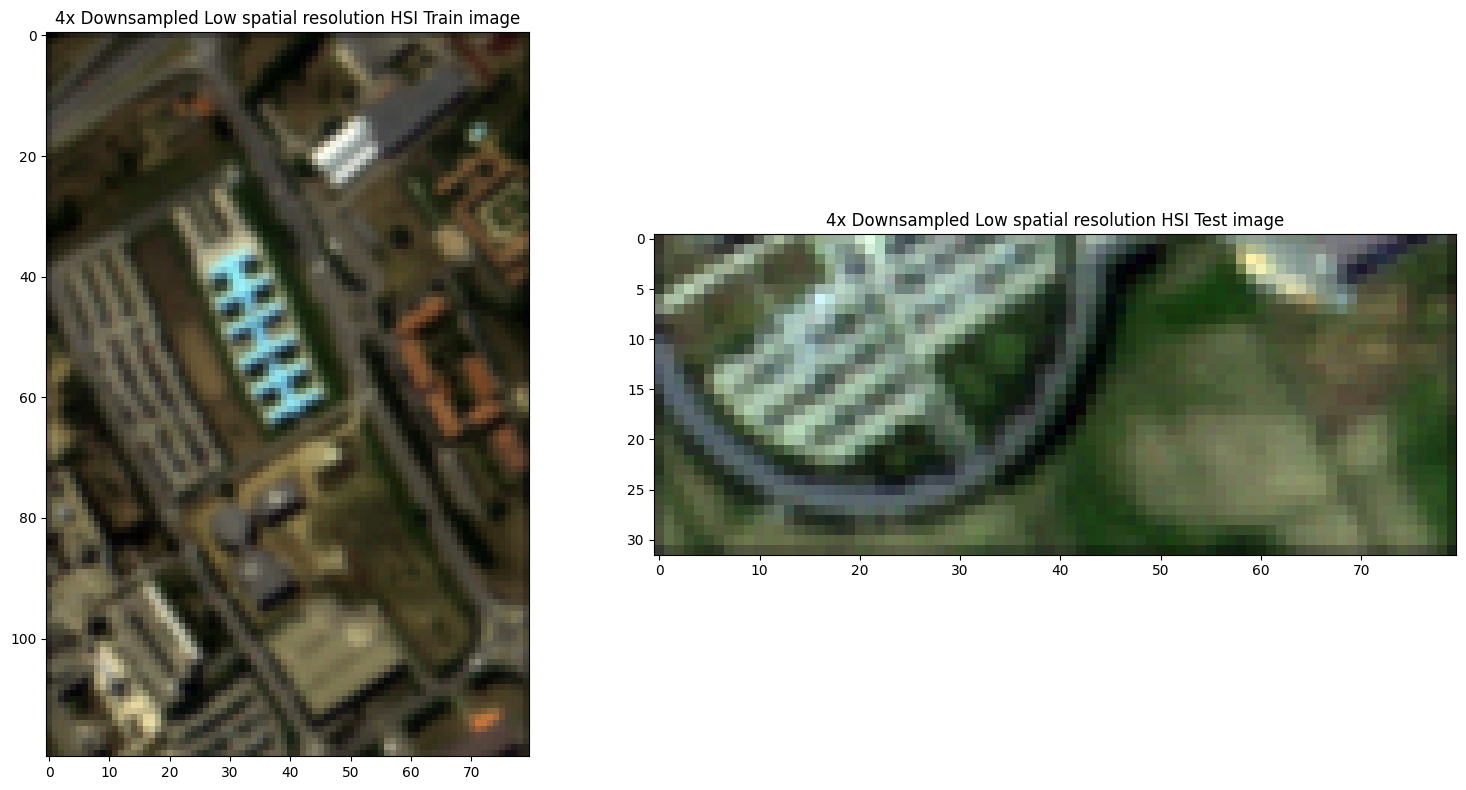

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


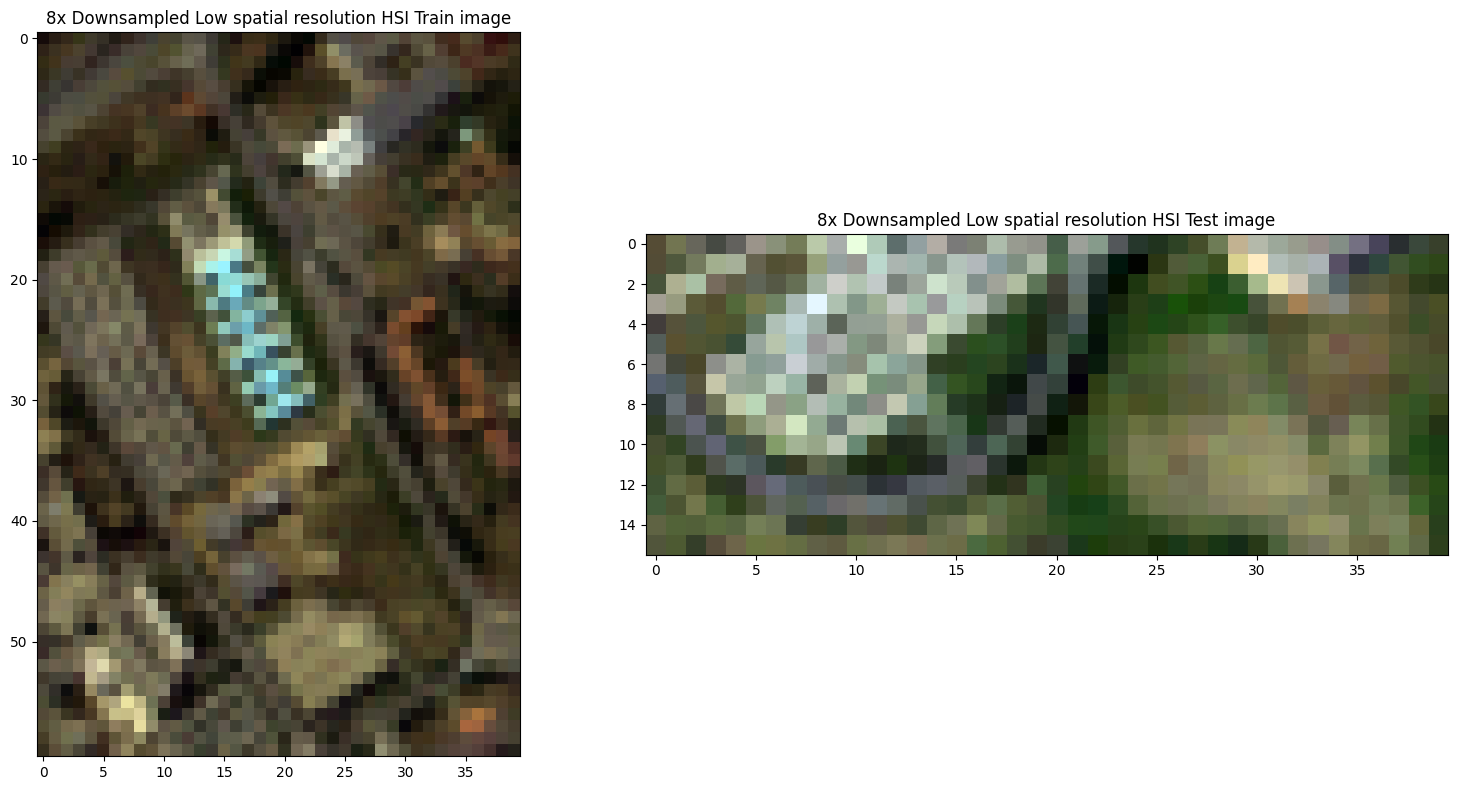

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


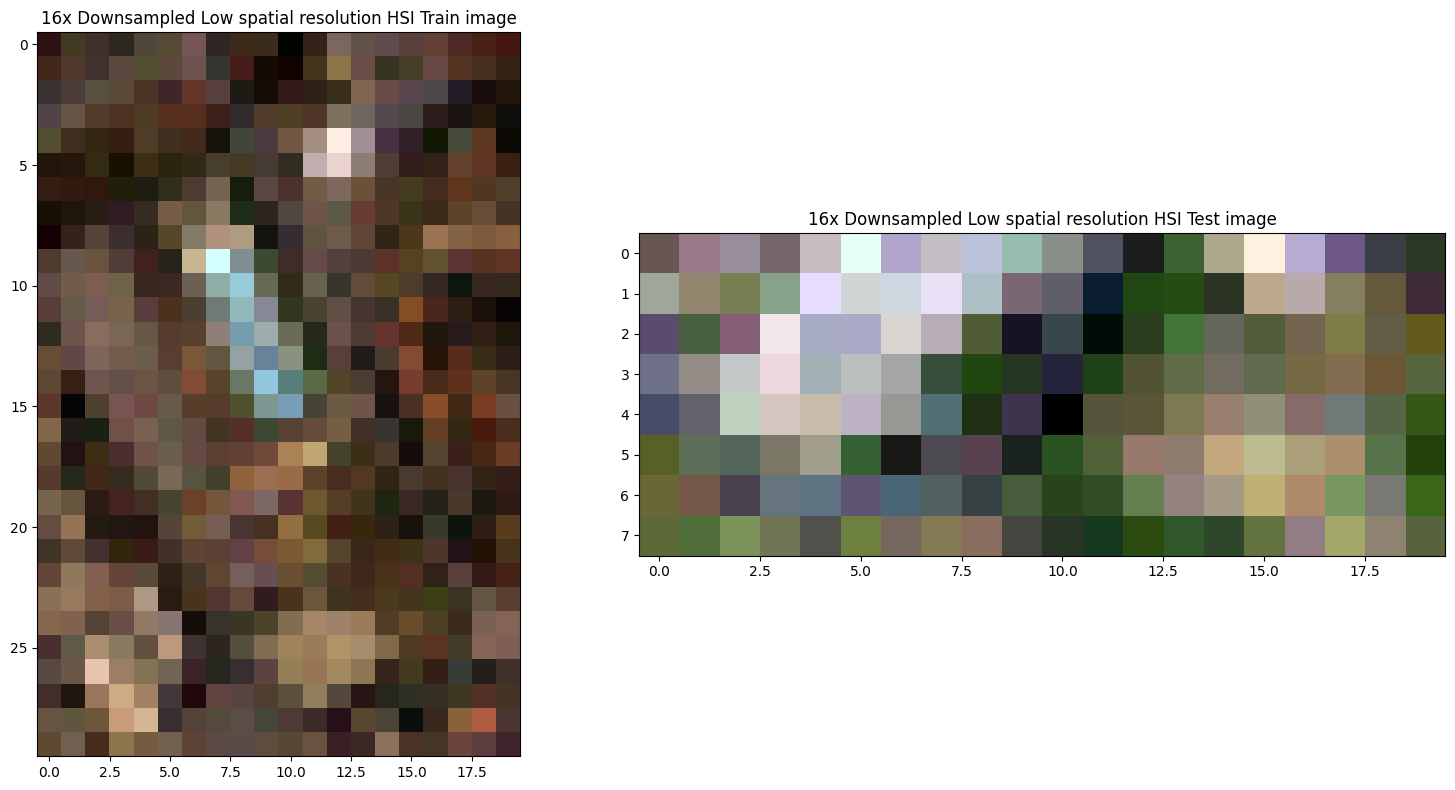

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


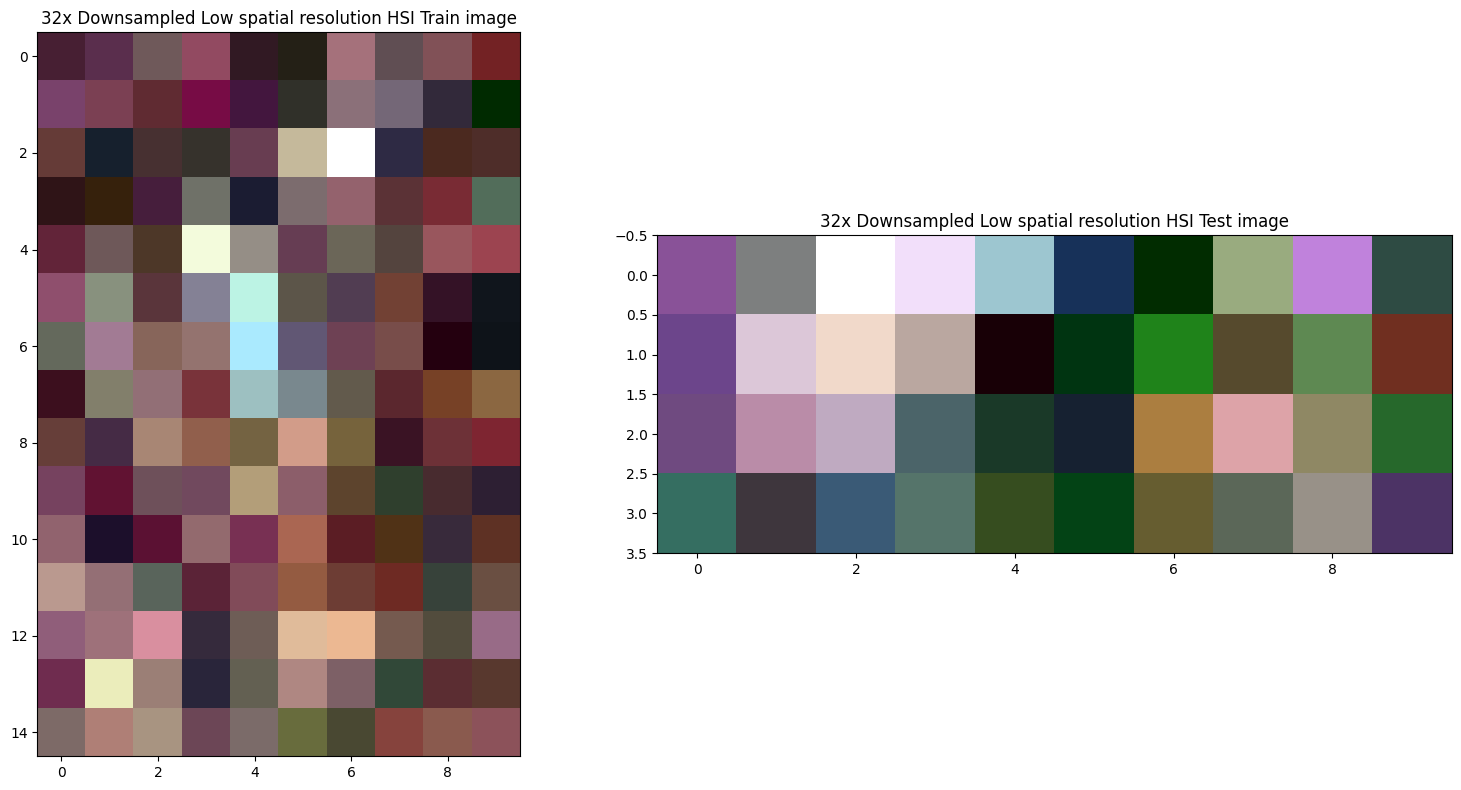

In [16]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 4, 35)
I_HS_4_train_lor_sq, I_HS_4_test_lor_sq = split_lr_hsi(I_HS_4_lor_sq, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_lor_sq.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_lor_sq.shape)
visualize_hsi(I_HS_4_train_lor_sq, I_HS_4_test_lor_sq, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 8, 30)
I_HS_8_train_lor_sq, I_HS_8_test_lor_sq = split_lr_hsi(I_HS_8_lor_sq, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_lor_sq.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_lor_sq.shape)
visualize_hsi(I_HS_8_train_lor_sq, I_HS_8_test_lor_sq, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 16, 25)
I_HS_16_train_lor_sq, I_HS_16_test_lor_sq = split_lr_hsi(I_HS_16_lor_sq, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_lor_sq.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_lor_sq.shape)
visualize_hsi(I_HS_16_train_lor_sq, I_HS_16_test_lor_sq, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 32, 20)
I_HS_32_train_lor_sq, I_HS_32_test_lor_sq = split_lr_hsi(I_HS_32_lor_sq, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_lor_sq.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_lor_sq.shape)
visualize_hsi(I_HS_32_train_lor_sq, I_HS_32_test_lor_sq, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Hermite PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


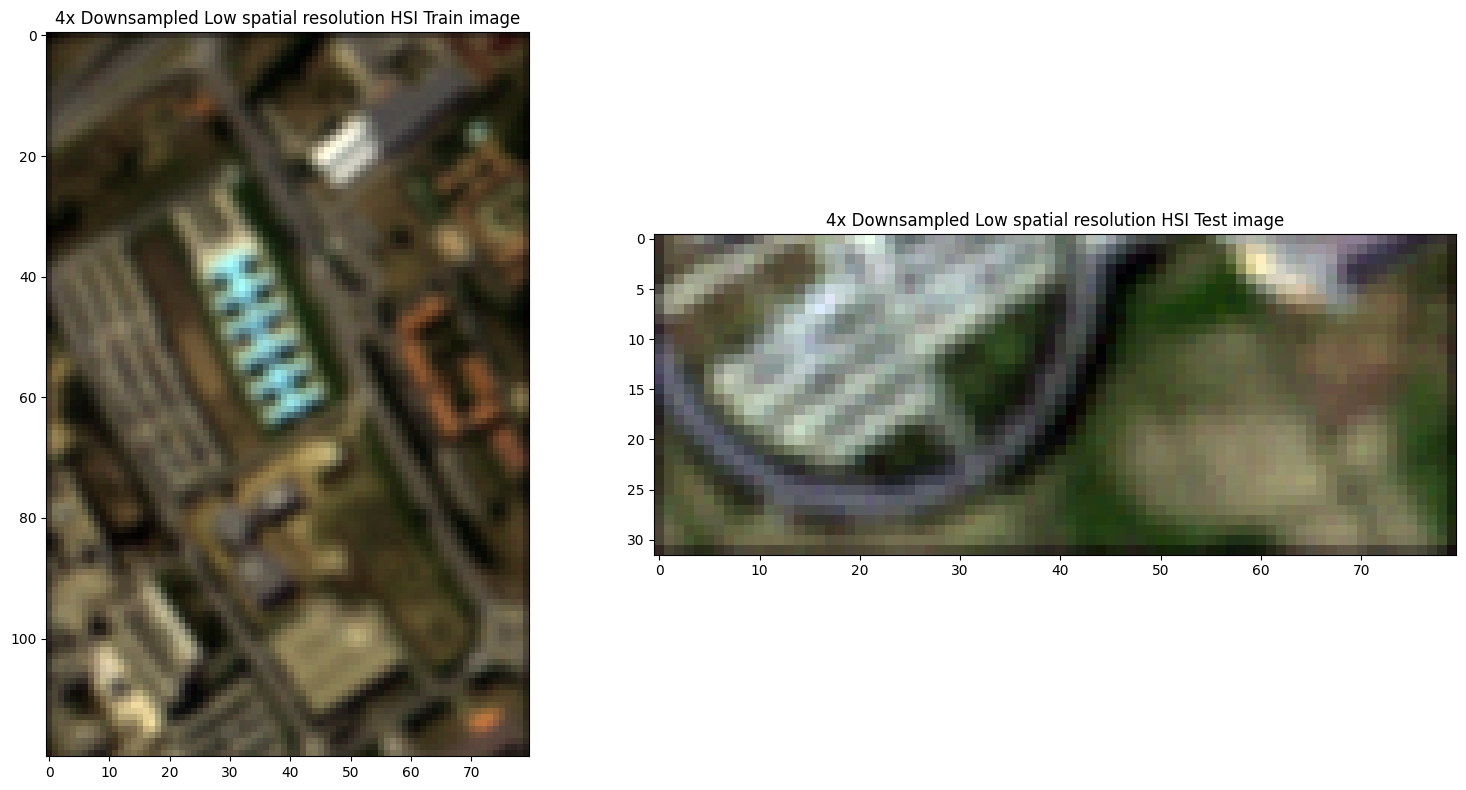

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


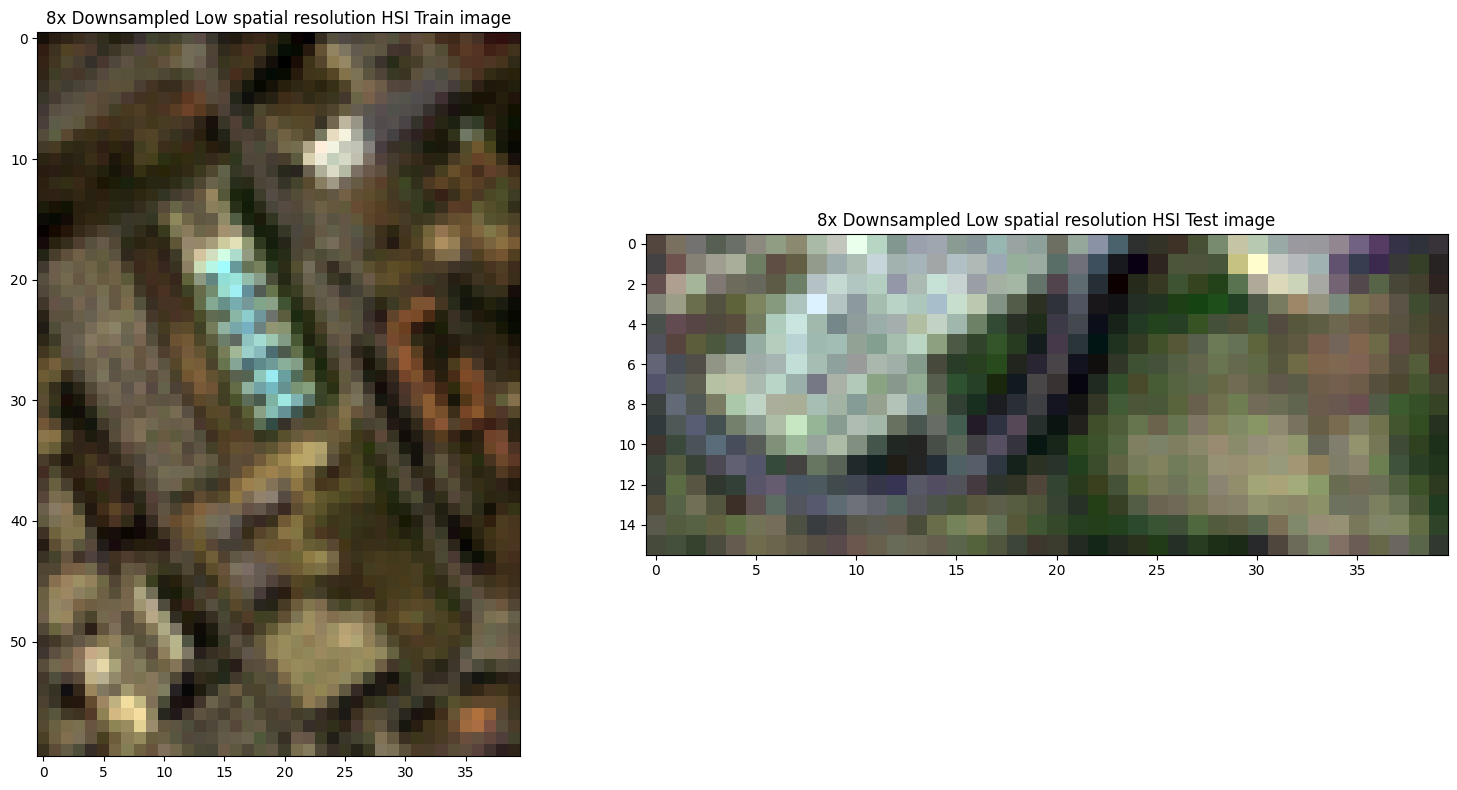

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


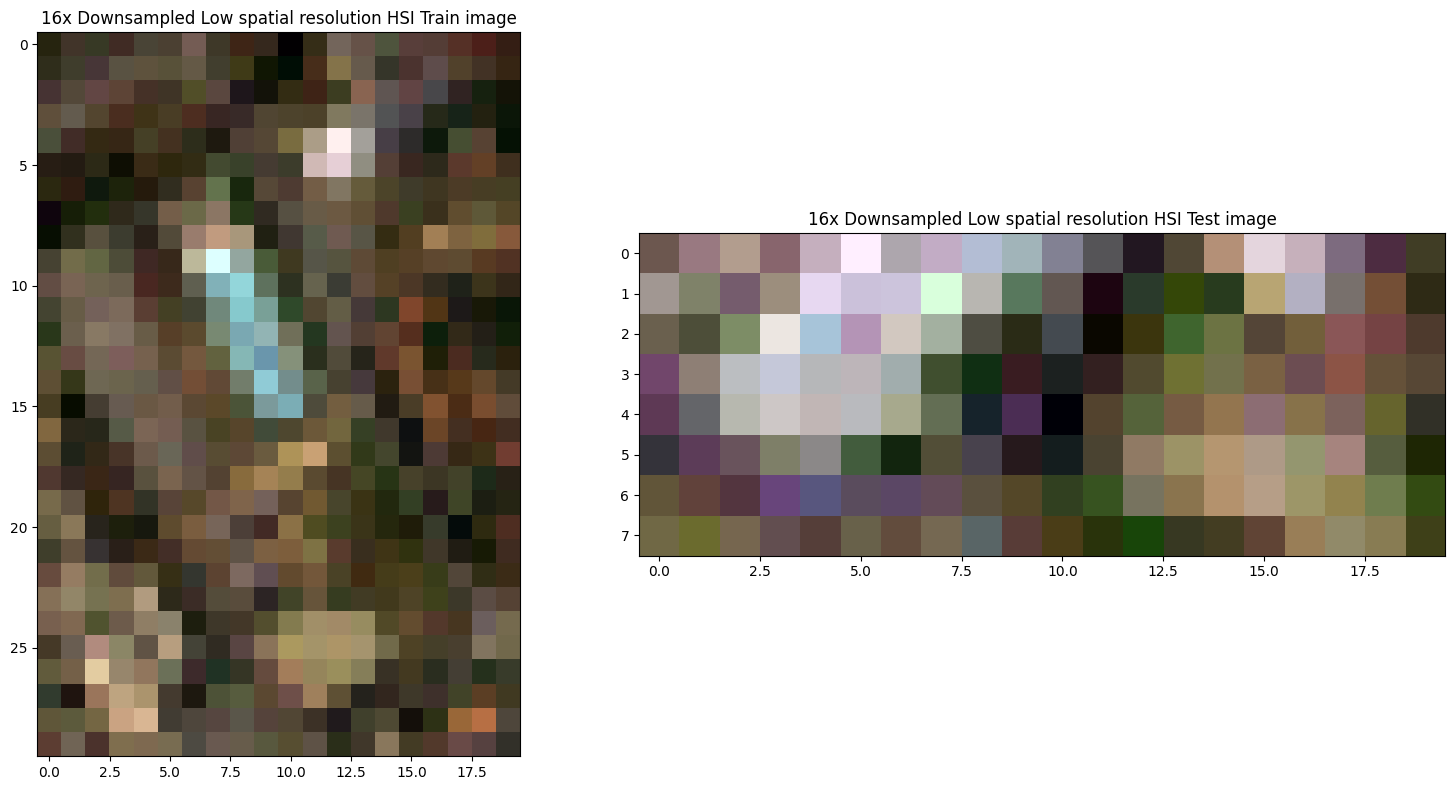

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


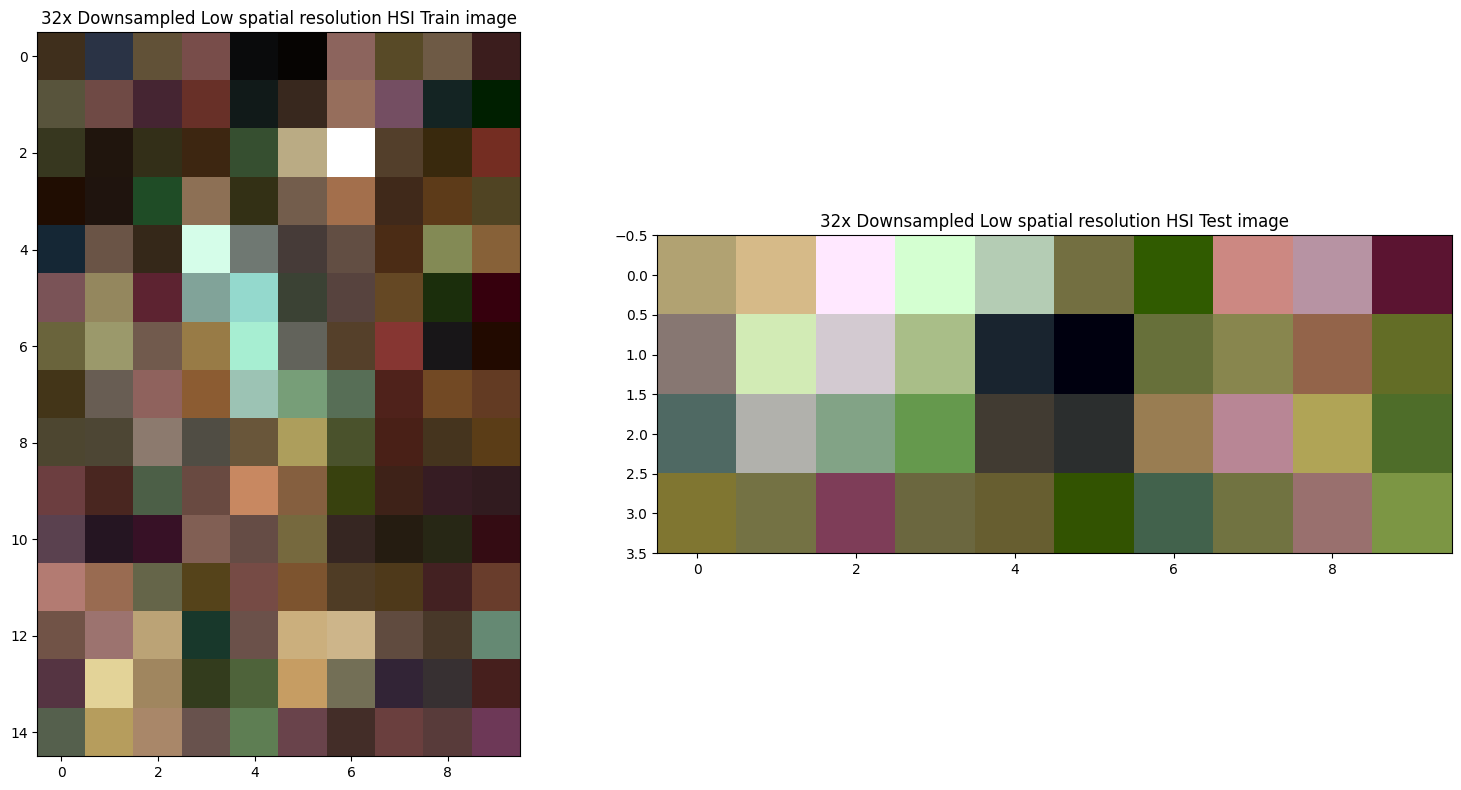

In [17]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(pavia_university_image, her_psf, 4, 35)
I_HS_4_train_her, I_HS_4_test_her = split_lr_hsi(I_HS_4_her, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_her.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_her.shape)
visualize_hsi(I_HS_4_train_her, I_HS_4_test_her, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(pavia_university_image, her_psf, 8, 30)
I_HS_8_train_her, I_HS_8_test_her = split_lr_hsi(I_HS_8_her, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_her.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_her.shape)
visualize_hsi(I_HS_8_train_her, I_HS_8_test_her, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(pavia_university_image, her_psf, 16, 25)
I_HS_16_train_her, I_HS_16_test_her = split_lr_hsi(I_HS_16_her, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_her.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_her.shape)
visualize_hsi(I_HS_16_train_her, I_HS_16_test_her, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(pavia_university_image, her_psf, 32, 20)
I_HS_32_train_her, I_HS_32_test_her = split_lr_hsi(I_HS_32_her, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_her.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_her.shape)
visualize_hsi(I_HS_32_train_her, I_HS_32_test_her, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Parabolic PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


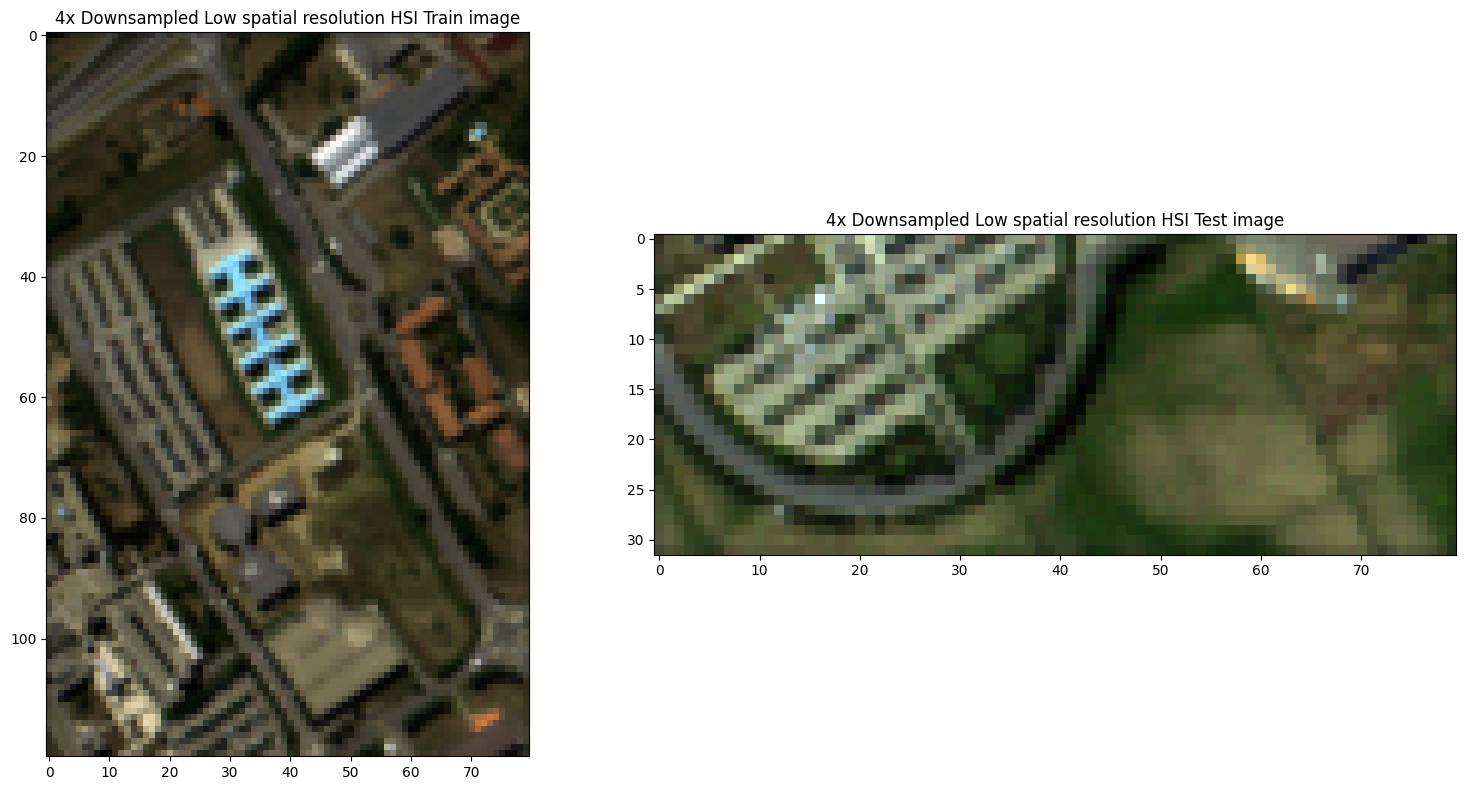

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


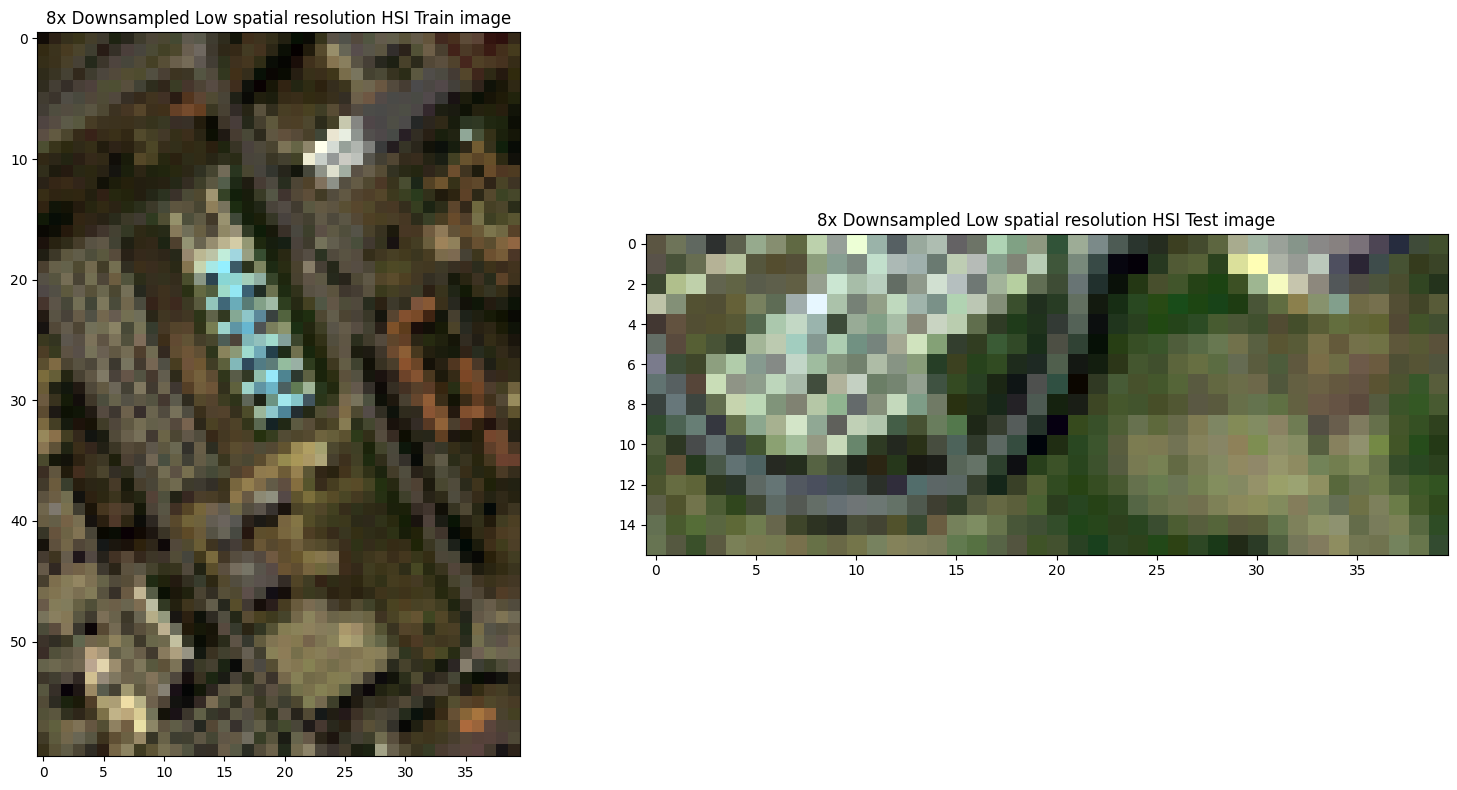

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


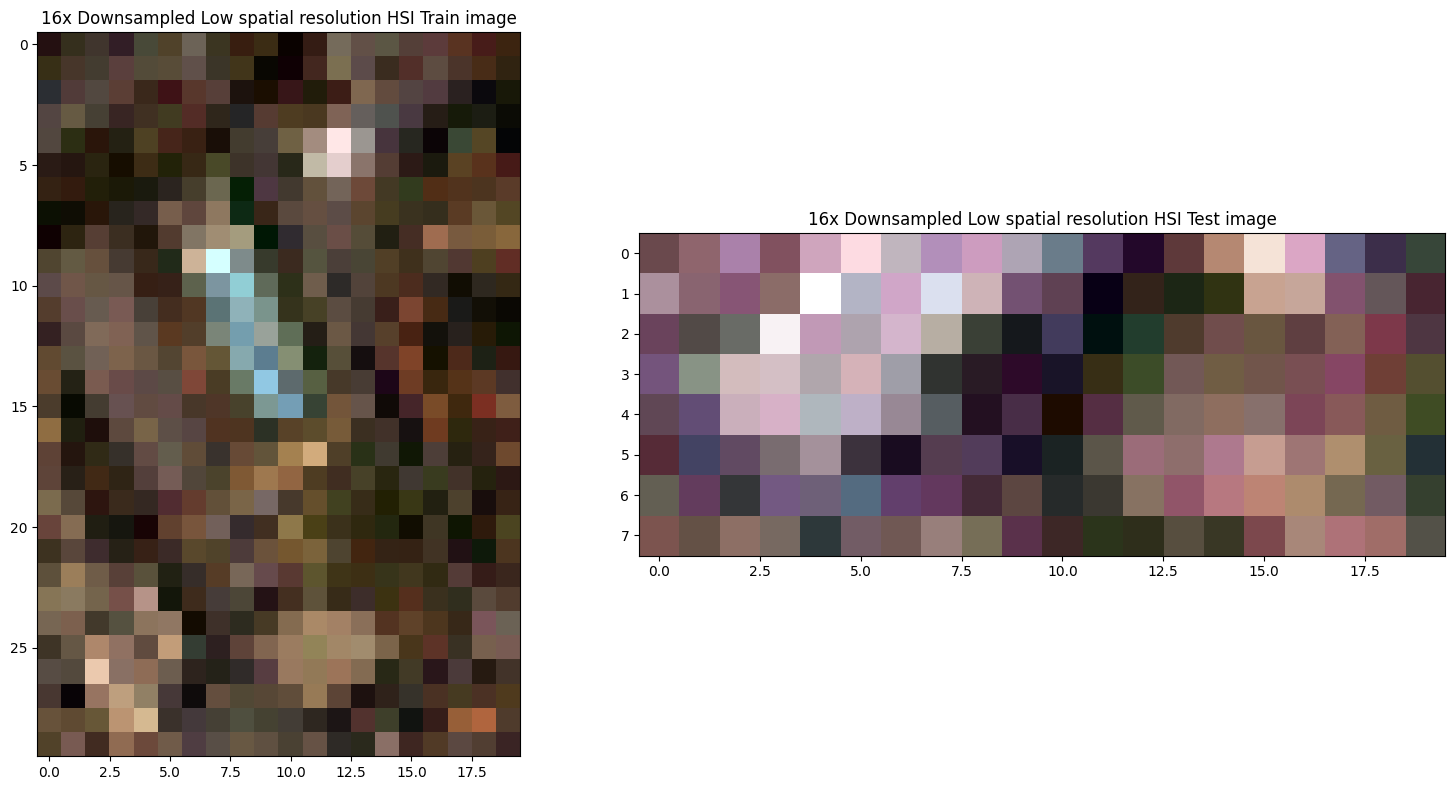

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


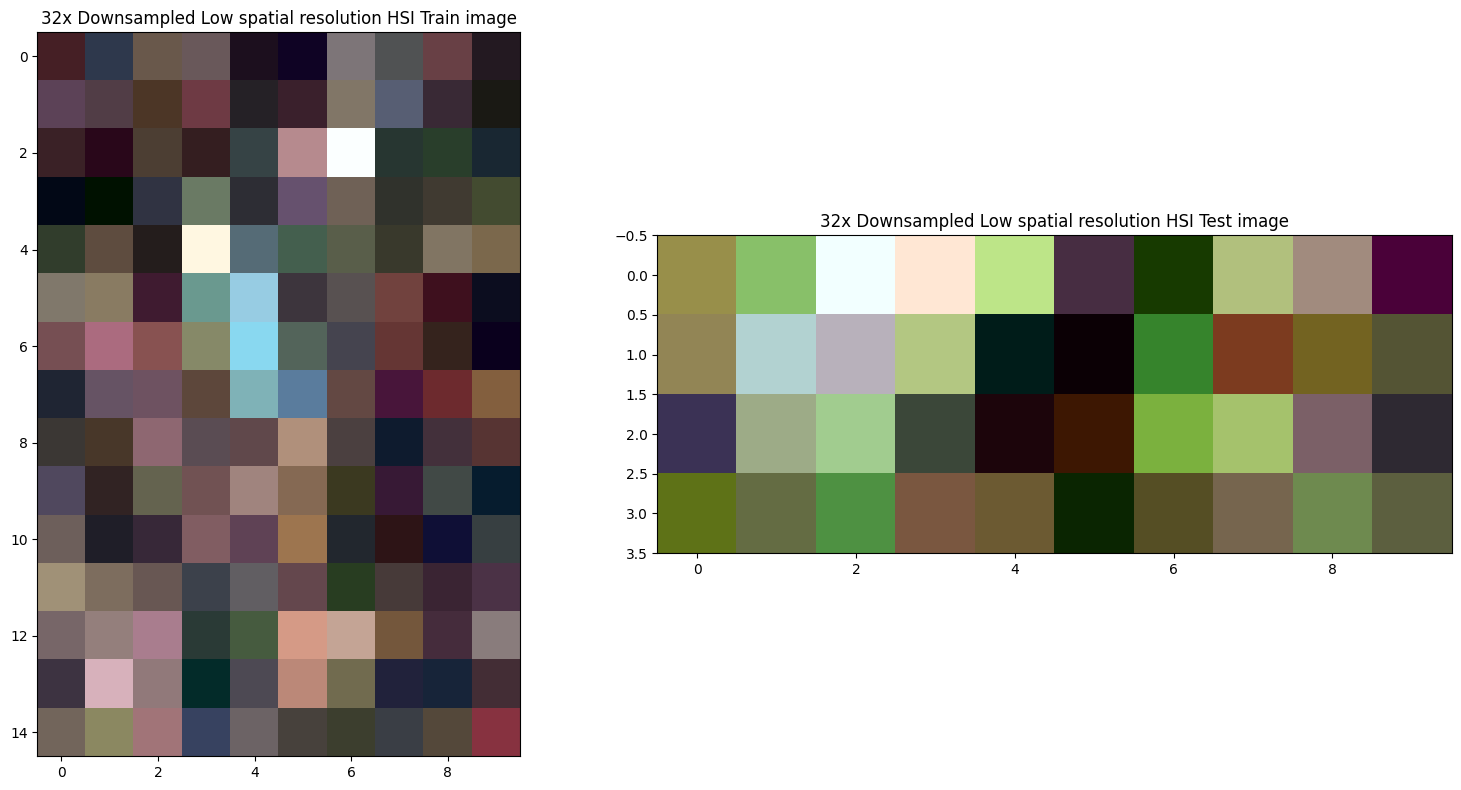

In [18]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(pavia_university_image, par_psf, 4, 35)
I_HS_4_train_par, I_HS_4_test_par = split_lr_hsi(I_HS_4_par, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_par.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_par.shape)
visualize_hsi(I_HS_4_train_par, I_HS_4_test_par, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(pavia_university_image, par_psf, 8, 30)
I_HS_8_train_par, I_HS_8_test_par = split_lr_hsi(I_HS_8_par, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_par.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_par.shape)
visualize_hsi(I_HS_8_train_par, I_HS_8_test_par, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(pavia_university_image, par_psf, 16, 25)
I_HS_16_train_par, I_HS_16_test_par = split_lr_hsi(I_HS_16_par, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_par.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_par.shape)
visualize_hsi(I_HS_16_train_par, I_HS_16_test_par, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(pavia_university_image, par_psf, 32, 20)
I_HS_32_train_par, I_HS_32_test_par = split_lr_hsi(I_HS_32_par, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_par.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_par.shape)
visualize_hsi(I_HS_32_train_par, I_HS_32_test_par, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Gabor PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


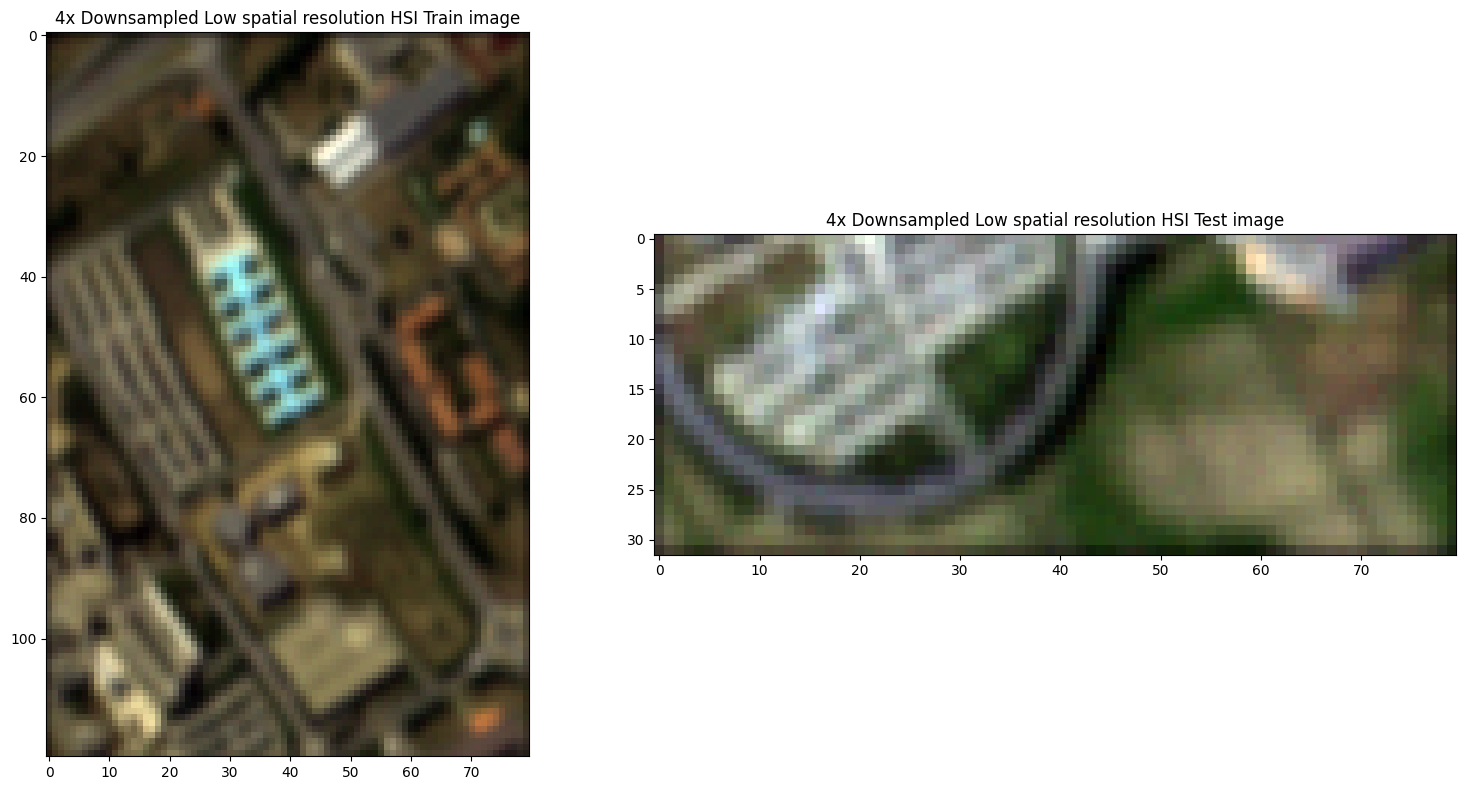

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


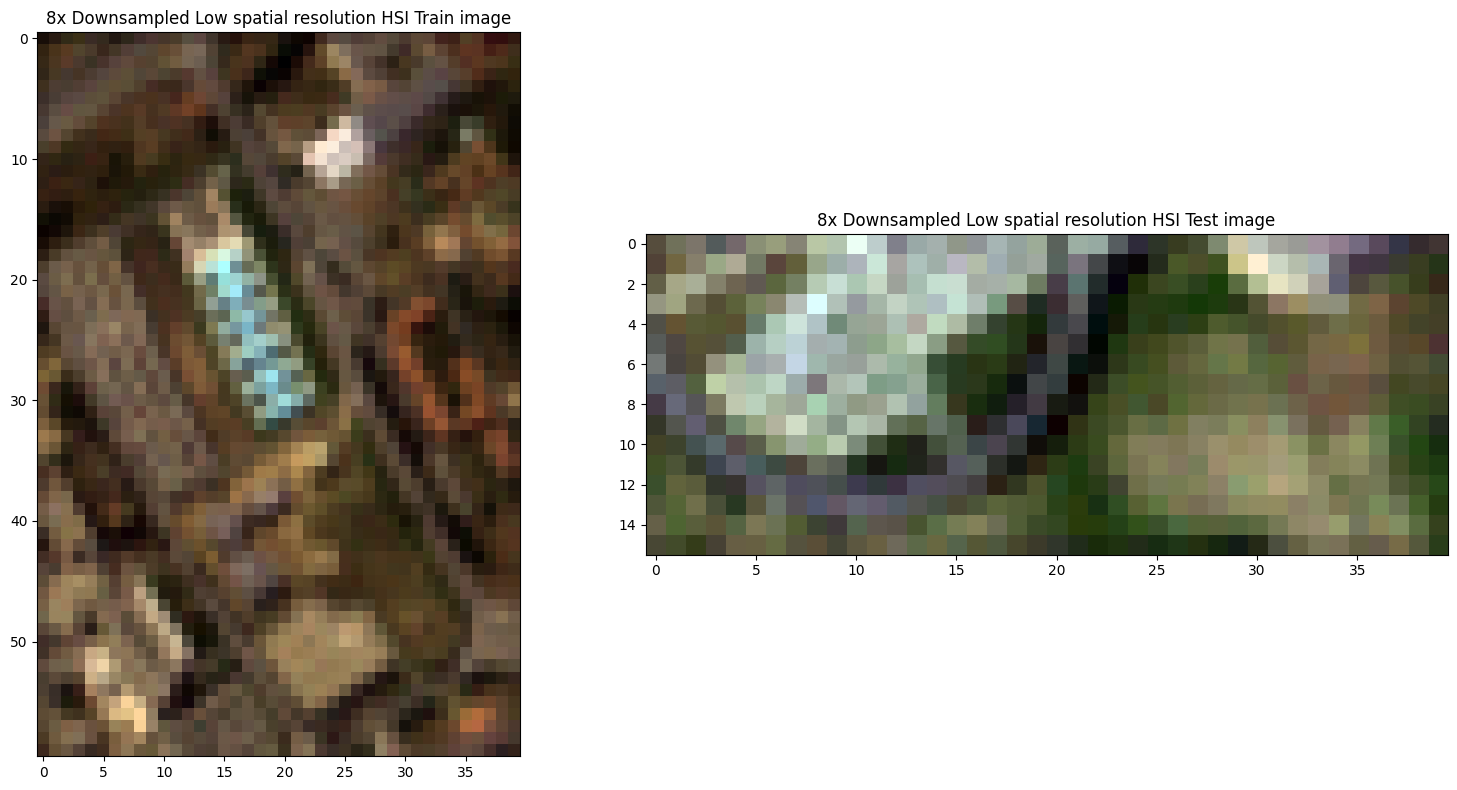

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


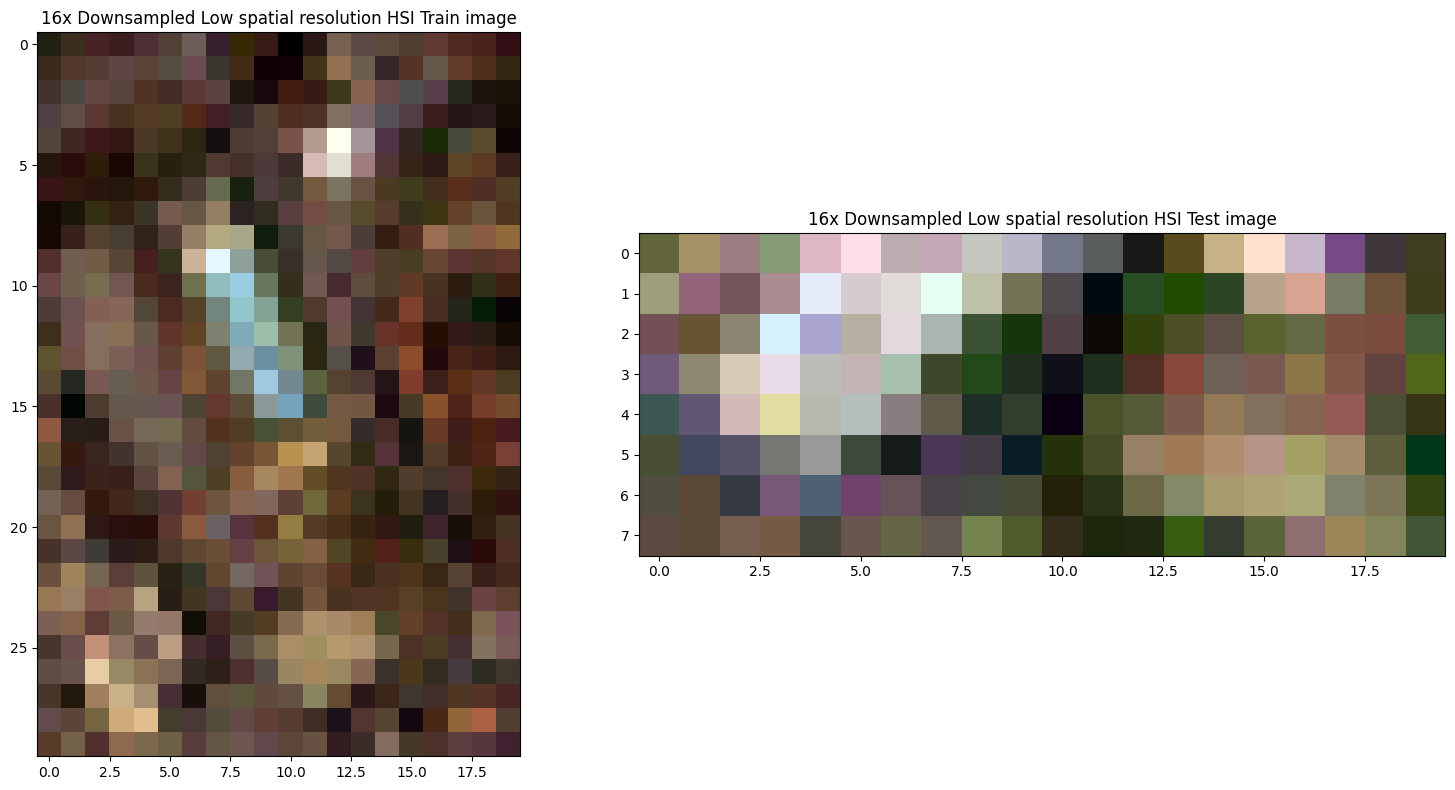

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


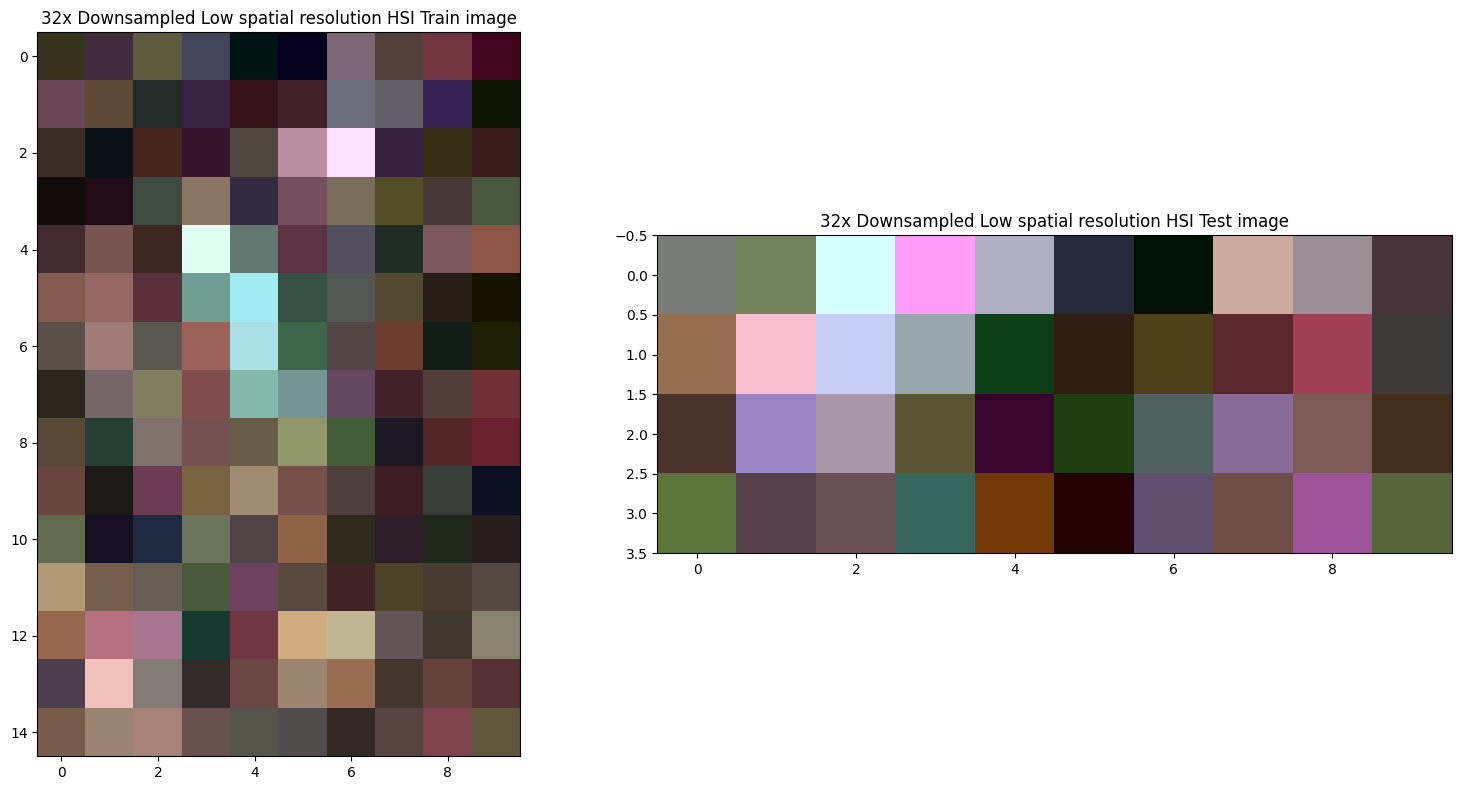

In [19]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(pavia_university_image, gab_psf, 4, 35)
I_HS_4_train_gab, I_HS_4_test_gab = split_lr_hsi(I_HS_4_gab, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_gab.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_gab.shape)
visualize_hsi(I_HS_4_train_gab, I_HS_4_test_gab, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(pavia_university_image, gab_psf, 8, 30)
I_HS_8_train_gab, I_HS_8_test_gab = split_lr_hsi(I_HS_8_gab, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_gab.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_gab.shape)
visualize_hsi(I_HS_8_train_gab, I_HS_8_test_gab, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(pavia_university_image, gab_psf, 16, 25)
I_HS_16_train_gab, I_HS_16_test_gab = split_lr_hsi(I_HS_16_gab, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_gab.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_gab.shape)
visualize_hsi(I_HS_16_train_gab, I_HS_16_test_gab, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(pavia_university_image, gab_psf, 32, 20)
I_HS_32_train_gab, I_HS_32_test_gab = split_lr_hsi(I_HS_32_gab, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_gab.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_gab.shape)
visualize_hsi(I_HS_32_train_gab, I_HS_32_test_gab, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Delta PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


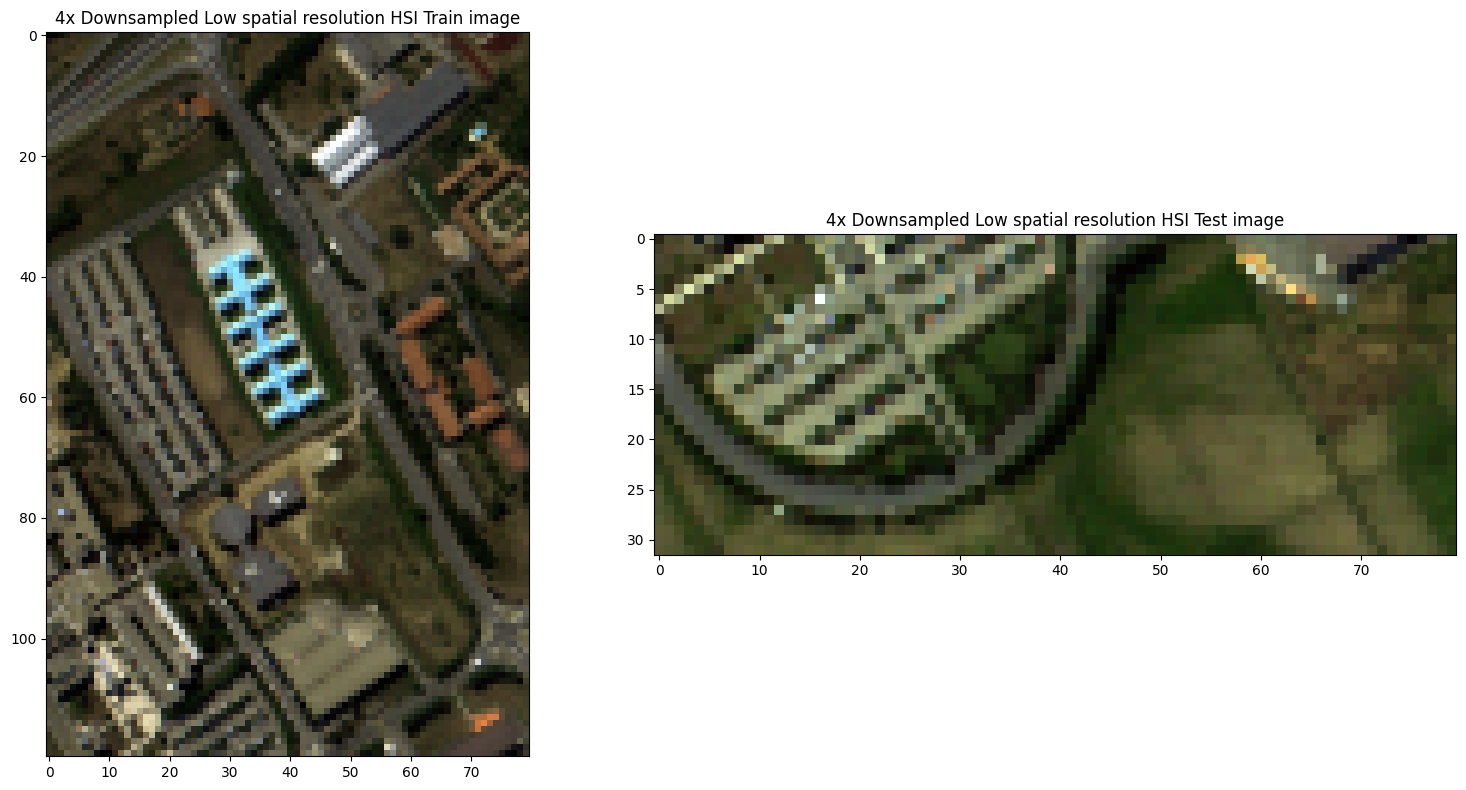

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


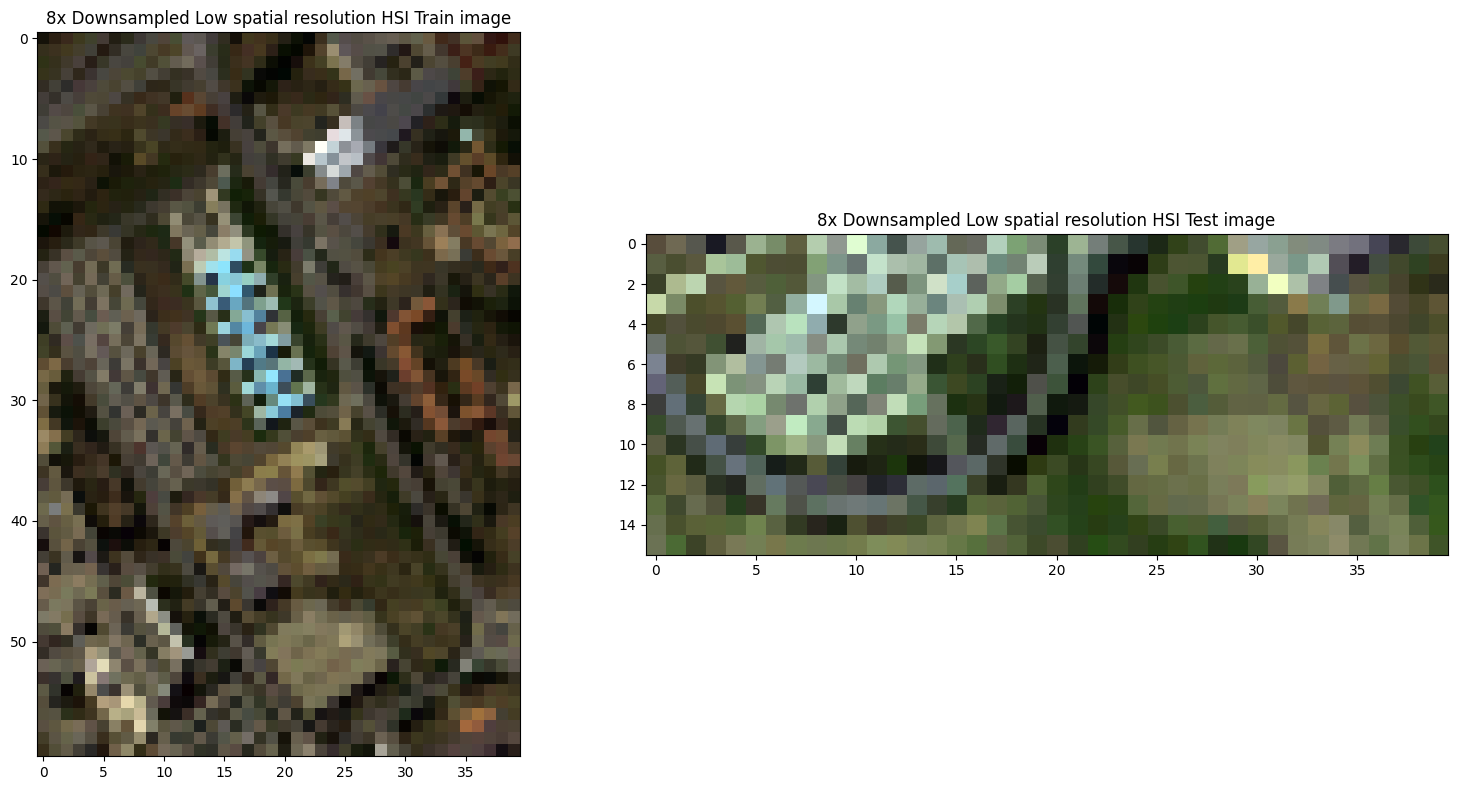

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


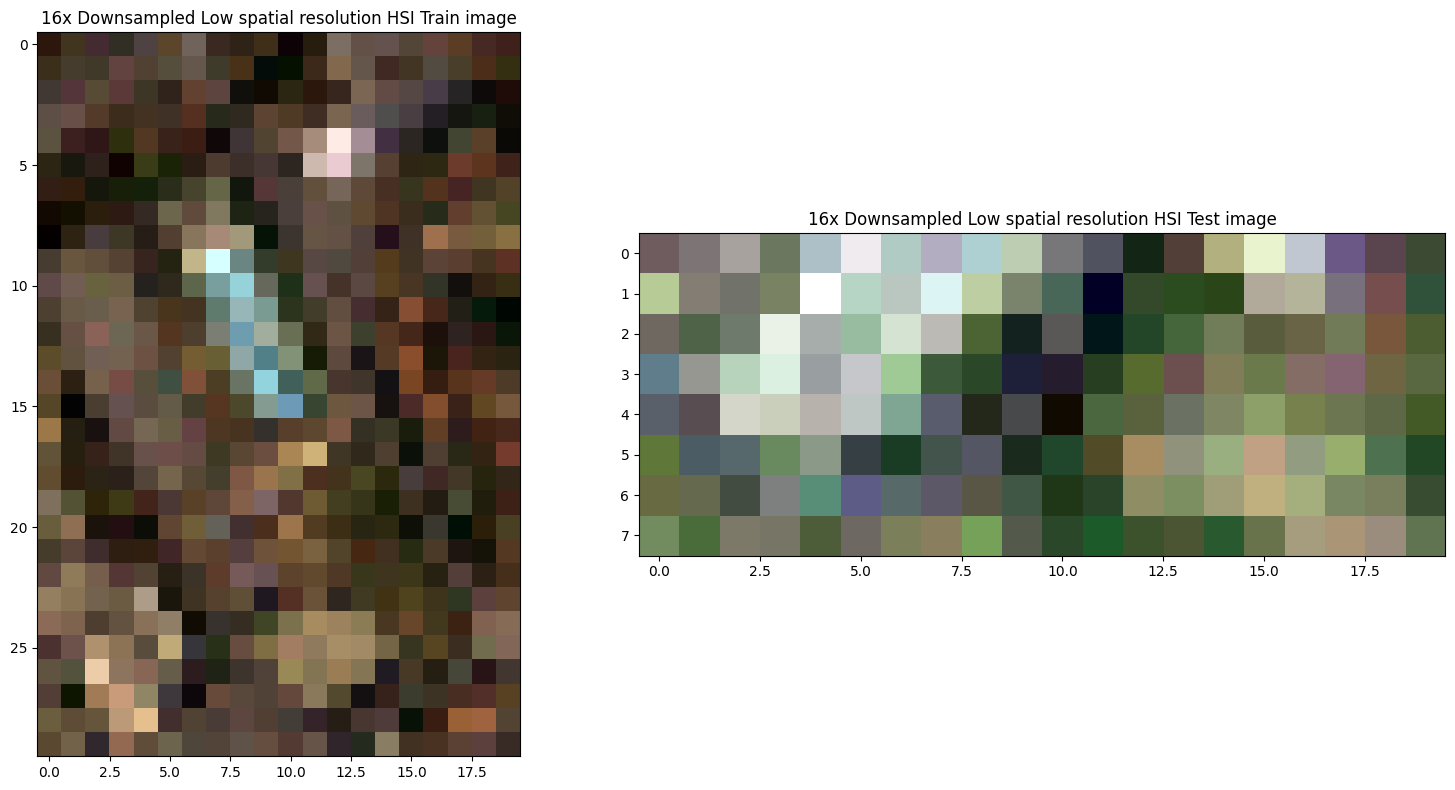

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


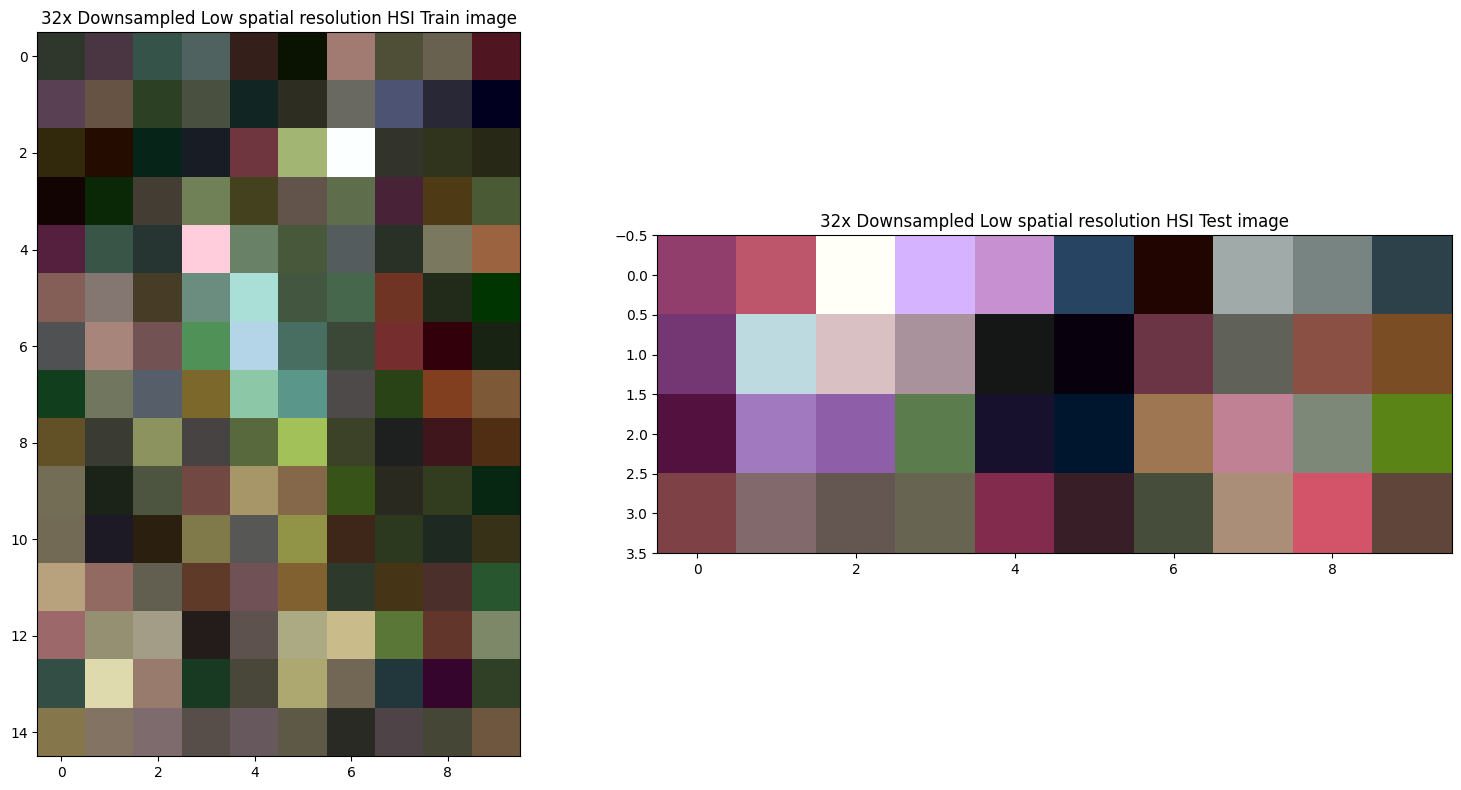

In [20]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(pavia_university_image, delta_psf, 4, 35)
I_HS_4_train_delta, I_HS_4_test_delta = split_lr_hsi(I_HS_4_delta, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_delta.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_delta.shape)
visualize_hsi(I_HS_4_train_delta, I_HS_4_test_delta, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(pavia_university_image, delta_psf, 8, 30)
I_HS_8_train_delta, I_HS_8_test_delta = split_lr_hsi(I_HS_8_delta, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_delta.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_delta.shape)
visualize_hsi(I_HS_8_train_delta, I_HS_8_test_delta, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(pavia_university_image, delta_psf, 16, 25)
I_HS_16_train_delta, I_HS_16_test_delta = split_lr_hsi(I_HS_16_delta, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_delta.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_delta.shape)
visualize_hsi(I_HS_16_train_delta, I_HS_16_test_delta, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(pavia_university_image, delta_psf, 32, 20)
I_HS_32_train_delta, I_HS_32_test_delta = split_lr_hsi(I_HS_32_delta, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_delta.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_delta.shape)
visualize_hsi(I_HS_32_train_delta, I_HS_32_test_delta, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

MIMO-SST: Multi-Input Multi-Output Spatial-Spectral Transformer for Hyperspectral and Multispectral Image Fusion implementation from their GitHub

In [21]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [22]:
def make_patches(hr_hsi, hr_msi, lr_hsi,
                 patch_hr=32, scale=8):
    """
    hr_hsi : (H,W,C_hsi)
    hr_msi : (H,W,C_msi)  # same spatial size as hr_hsi
    lr_hsi : (H/scale,W/scale,C_hsi)

    Returns three numpy arrays in (N,C,H,W) order.
    """
    stride_hr = patch_hr                 # non-overlapping patches
    stride_lr = patch_hr // scale

    def extract(img, p, s):
        H,W,C = img.shape
        out = []
        for y in range(0, H-p+1, s):
            for x in range(0, W-p+1, s):
                out.append(img[y:y+p, x:x+p, :])
        return np.stack(out)

    HR_HSI = extract(hr_hsi, patch_hr, stride_hr).transpose(0,3,1,2)
    HR_MSI = extract(hr_msi, patch_hr, stride_hr).transpose(0,3,1,2)
    LR_HSI = extract(lr_hsi, patch_hr//scale, stride_lr).transpose(0,3,1,2)

    return HR_MSI.astype(np.float32), LR_HSI.astype(np.float32), HR_HSI.astype(np.float32)


class PatchDS(torch.utils.data.Dataset):
    def __init__(self, msi, lr, gt):
        self.msi, self.lr, self.gt = map(torch.tensor, (msi, lr, gt))
    def __len__(self):  return self.msi.size(0)
    def __getitem__(self, i):  return (self.msi[i], self.lr[i], self.gt[i])

In [23]:
# ---------------------------------------------------------------------------
#  small util: inverse of nn.PixelShuffle (compatible with old PyTorch)
# ---------------------------------------------------------------------------

def pixel_unshuffle(x: torch.Tensor, r: int) -> torch.Tensor:
    """Downsamples (B,C,H,W) by factor *r* using standard pixel‑unshuffle."""
    if hasattr(F, "pixel_unshuffle"):
        return F.pixel_unshuffle(x, r)
    b, c, h, w = x.shape
    assert h % r == 0 and w % r == 0, "H and W must be divisible by r"
    x = x.view(b, c, h // r, r, w // r, r)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    return x.view(b, c * r * r, h // r, w // r)

# ---------------------------------------------------------------------------
#  Helpers: reshape, (Bias‑)Free LayerNorm                                    
# ---------------------------------------------------------------------------

def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x, h, w):
    return rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super().__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma + 1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super().__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias   = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mu    = x.mean(-1, keepdim=True)
        sigma = x.var (-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma + 1e-5) * self.weight + self.bias

class LayerNorm(nn.Module):
    def __init__(self, dim, layer_type: str = 'WithBias'):
        super().__init__()
        self.body = BiasFree_LayerNorm(dim) if layer_type == 'BiasFree' else WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

# ---------------------------------------------------------------------------
#  ECA block
# ---------------------------------------------------------------------------
class ECALayer1D(nn.Module):
    def __init__(self, channel: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv     = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size-1)//2, bias=False)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, x):  # x: (B, HW, C)
        y = self.avg_pool(x.transpose(-1, -2))
        y = self.conv(y.transpose(-1, -2))
        y = self.sigmoid(y)
        return x * y.expand_as(x)

# ---------------------------------------------------------------------------
#  Gated‑Dconv Feed‑Forward Network
# ---------------------------------------------------------------------------
class FeedForward(nn.Module):
    def __init__(self, dim: int, ffn_expansion_factor: float, act_layer=nn.GELU, use_eca: bool=False):
        super().__init__()
        hidden_features = dim  # original authors keep width = dim
        self.dwconv = nn.Sequential(
            nn.Conv2d(dim, hidden_features, 3, padding=1),
            act_layer())
        self.eca = ECALayer1D(hidden_features) if use_eca else nn.Identity()
        # second depth‑wise conv was disabled in the paper implementation

    def forward(self, x):
        x = self.dwconv(x)
        x = self.eca(x)
        return x

# ---------------------------------------------------------------------------
#  Multi‑DConv Transposed Self‑Attention variants (kept verbatim)            
# ---------------------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super().__init__()
        self.num_heads  = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv        = nn.Conv2d(dim, dim*3, 1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, 3, padding=1, groups=dim*3, bias=bias)
        self.project    = nn.Conv2d(dim, dim, 1, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = rearrange(q, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        k = rearrange(k, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        v = rearrange(v, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        q = F.normalize(q, dim=-1); k = F.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2,-1)) * self.temperature
        attn = attn.softmax(-1)
        out  = attn @ v
        out  = rearrange(out, 'b h c (y x) -> b (h c) y x', h=self.num_heads, y=h, x=w)
        return self.project(out)

class AttentionSpatio(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super().__init__()
        self.num_heads  = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv        = nn.Conv2d(dim, dim*3, 1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, 3, padding=1, groups=dim*3, bias=bias)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)
        q = rearrange(q, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        k = rearrange(k, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        v = rearrange(v, 'b (h c) y x -> b h c (y x)', h=self.num_heads)
        attn = (q / self.temperature) @ k.transpose(-2,-1)
        attn = attn.softmax(-1)
        out  = (attn @ v).view(b, c, h, w)
        return out

# ---------------------------------------------------------------------------
#  Transformer blocks (spectral & spatial)
# ---------------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_exp, bias, layer_type):
        super().__init__()
        self.norm1 = LayerNorm(dim, layer_type)
        self.attn  = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, layer_type)
        self.ffn   = FeedForward(dim, ffn_exp)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn (self.norm2(x))
        return x

class TransformerBlock1(nn.Module):
    """Cross‑branch mutual attention (as in original code)."""
    def __init__(self, dim, num_heads, ffn_exp, bias, layer_type):
        super().__init__()
        self.norm1 = LayerNorm(dim, layer_type)
        self.attn1 = Attention(dim, num_heads, bias)
        self.attn2 = Attention(dim, num_heads, bias)  # reused for cross‑branch
        self.norm2 = LayerNorm(dim, layer_type)
        self.ffn   = FeedForward(dim, ffn_exp)

    def forward(self, xx):
        x, y = xx
        x_kqv = self.attn1(self.norm1(x))  # returns B,C,H,W like original version
        y_kqv = self.attn1(self.norm1(y))
        # reuse heads: soft cross fusion (simplified)
        x = x + x_kqv
        y = y + y_kqv
        x = x + self.ffn(self.norm2(x))
        y = y + self.ffn(self.norm2(y))
        return x, y

# ---------------------------------------------------------------------------
#  Overlap patch embedding & resize ops
# ---------------------------------------------------------------------------
class OverlapPatchEmbed(nn.Module):
    def __init__(self, in_c, embed_dim, bias=False):
        super().__init__()
        self.proj = nn.Conv2d(in_c, embed_dim, 3, padding=1, bias=bias)
    def forward(self, x):
        return self.proj(x)

class Downsample(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.conv = nn.Conv2d(n_feat, n_feat//2, 3, padding=1, bias=False)
    def forward(self, x):
        return pixel_unshuffle(self.conv(x), 2)

class Upsample(nn.Module):
    def __init__(self, n_feat):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat*2, 3, padding=1, bias=False),
            nn.PixelShuffle(2))
    def forward(self, x):
        return self.body(x)

# ---------------------------------------------------------------------------
#  Main network – **now fully flexible**                                     
# ---------------------------------------------------------------------------
class Net(nn.Module):
    def __init__(self, scale: int = 8, msi_channels: int = 3, hsi_channels: int = 31):
        """Create a network that works for arbitrary scale (2^n) & channel counts."""
        super().__init__()
        assert scale & (scale - 1) == 0, "scale must be a power‑of‑two"

        dim = 48
        ffn_exp = 2.66
        bias    = False
        layer_t = 'WithBias'

        # stems: map raw MSI / upscaled HSI → 48‑channel space
        self.conv_msi_64 = nn.Conv2d(msi_channels, dim, 3, padding=1)
        self.conv_hsi_64 = nn.Conv2d(hsi_channels, dim, 3, padding=1)

        # patch embedding expects concatenated [X,Y,msi,hsi]
        inp_channels = dim*2 + msi_channels + hsi_channels  # 96 + C_msi + C_hsi
        self.patch_embed = OverlapPatchEmbed(inp_channels, dim)

        # shallow mutual encoder (1 block, can be increased)
        self.encoder_level11 = nn.Sequential(
            TransformerBlock1(dim, 1, ffn_exp, bias, layer_t))

        # hierarchy
        self.down1_2 = Downsample(dim)
        self.down2_3 = Downsample(dim*2)
        self.up3_2   = Upsample(dim*4)
        self.up2_1   = Upsample(dim*2)
        self.conv144_96  = nn.Conv2d(dim*3, dim*2, 3, padding=1)
        self.conv240_192 = nn.Conv2d(dim*5, dim*4, 3, padding=1)
        self.reduce_l2   = nn.Conv2d(dim*4, dim*2, 1, bias=bias)

        # outputs back to hyperspectral cube space
        self.conv96_out  = nn.Conv2d(dim*2, hsi_channels, 3, padding=1)
        self.conv192_out = nn.Conv2d(dim*4, hsi_channels, 3, padding=1)

        # fixed bilinear upsampler for LR‑HSI → HR grid
        self.upscale = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)
        self.relu = nn.ReLU(inplace=True)

    # ---------------------------------------------------------------------
    def _dual_encoder(self, msi, hsi):
        """Return fused feature map Z and two down‑scaled stacks Z1, Z2."""
        # level‑0 (HR)
        X = self.conv_msi_64(msi)
        Y = self.conv_hsi_64(hsi)
        X, Y = self.encoder_level11((X, Y))
        Z0 = torch.cat([X, Y, msi, hsi], dim=1)  # (B, 96+C_msi+C_hsi, H, W)

        # level‑1 (1/2)
        msi_1 = F.interpolate(msi, scale_factor=0.5, mode='bilinear', align_corners=False)
        hsi_1 = F.interpolate(hsi,  scale_factor=0.5, mode='bilinear', align_corners=False)
        X1 = self.conv_msi_64(msi_1)
        Y1 = self.conv_hsi_64(hsi_1)
        X1, Y1 = self.encoder_level11((X1, Y1))
        Z1 = torch.cat([X1, Y1, msi_1, hsi_1], dim=1)

        # level‑2 (1/4)
        msi_2 = F.interpolate(msi_1, scale_factor=0.5, mode='bilinear', align_corners=False)
        hsi_2 = F.interpolate(hsi_1, scale_factor=0.5, mode='bilinear', align_corners=False)
        X2 = self.conv_msi_64(msi_2)
        Y2 = self.conv_hsi_64(hsi_2)
        X2, Y2 = self.encoder_level11((X2, Y2))
        Z2 = torch.cat([X2, Y2, msi_2, hsi_2], dim=1)
        return (Z0, Z1, Z2, hsi_1, hsi_2)

    # ---------------------------------------------------------------------
    def forward(self, msi_hr, hsi_lr):
        # bring LR HSI to HR grid first
        hsi_hr = self.upscale(hsi_lr)

        Z0, Z1, Z2, hsi_1, hsi_2 = self._dual_encoder(msi_hr, hsi_hr)

        enc0 = self.patch_embed(Z0)              # (B,48,H,W)
        enc1 = self.patch_embed(Z1)              # (B,48,H/2,W/2)
        enc2 = self.patch_embed(Z2)              # (B,48,H/4,W/4)

        l2 = self.down1_2(enc0)
        l2 = self.conv144_96(torch.cat([l2, enc1], dim=1))   # (B,96,H/2,W/2)
        l3 = self.down2_3(l2)
        l3 = self.conv240_192(torch.cat([l3, enc2], dim=1))  # (B,192,H/4,W/4)

        # decoder & outputs
        out_q = self.conv192_out(l3) + hsi_2                    # quarter‑res
        d2    = self.up3_2(l3)
        d2    = self.reduce_l2(torch.cat([d2, l2], dim=1))      # (B,96,H/2,W/2)
        out_h = self.conv96_out(d2) + hsi_1                     # half‑res
        d1    = self.up2_1(d2)
        d1    = torch.cat([d1, enc0], dim=1)                    # (B,144,H,W)
        out_f = self.relu(self.conv96_out(d1) + hsi_hr)         # full‑res

        return out_q, out_h, out_f

Output file to save super-resolved images

In [24]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/MIMO"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
pavia_u_mimo_folder_path = os.path.join(normalized_target_path, 'Pavia_University')

# Create the folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_folder_path):
    os.makedirs(pavia_u_mimo_folder_path)

## Super Resolving HSI degraded with Gaussian PSF

In [25]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
pavia_u_mimo_gaus_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_gaus_folder_path):
    os.makedirs(pavia_u_mimo_gaus_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [26]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")

# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:38<00:00,  4.58epoch/s, avg_loss=2.9188e-02]


Training completed in  218.20 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0095 seconds
GPU memory consumed: 154.19 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [27]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:37<00:00,  4.61epoch/s, avg_loss=3.3677e-02]


Training completed in  217.10 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0087 seconds
GPU memory consumed: 152.12 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [28]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
   
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:36<00:00,  4.62epoch/s, avg_loss=3.9364e-02]


Training completed in  216.47 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0084 seconds
GPU memory consumed: 154.01 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [29]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:37<00:00,  4.60epoch/s, avg_loss=4.6385e-02]


Training completed in  217.21 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0078 seconds
GPU memory consumed: 152.61 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [30]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:36<00:00,  4.62epoch/s, avg_loss=5.1634e-02]


Training completed in  216.27 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0082 seconds
GPU memory consumed: 153.19 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [31]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:37<00:00,  4.59epoch/s, avg_loss=3.5573e-02]


Training completed in  217.88 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0080 seconds
GPU memory consumed: 153.23 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [32]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.51epoch/s, avg_loss=3.1933e-02]


Training completed in  221.58 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0069 seconds
GPU memory consumed: 154.77 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_gaus_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [33]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_gaus,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_gaus         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gaus_folder_path}/SR_Pavia_U_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_gaus_folder_path")

Training: 100%|██████████| 1000/1000 [03:45<00:00,  4.43epoch/s, avg_loss=3.0381e-02]


Training completed in  225.62 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0089 seconds
GPU memory consumed: 155.91 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov PSF

In [34]:
# Creating sub folder within which to save the super resolved images from Kolmogorov PSF degraded HSI
pavia_u_mimo_kol_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Kolmogorov_PSF')

# Create the Kolmogorov sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_kol_folder_path):
    os.makedirs(pavia_u_mimo_kol_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [35]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=2.9306e-02]


Training completed in  222.77 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0088 seconds
GPU memory consumed: 153.98 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [36]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=3.3198e-02]


Training completed in  219.77 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0079 seconds
GPU memory consumed: 152.11 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [37]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.8263e-02]


Training completed in  220.25 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0070 seconds
GPU memory consumed: 152.45 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [38]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=4.6177e-02]


Training completed in  219.66 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0077 seconds
GPU memory consumed: 152.02 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [39]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:38<00:00,  4.58epoch/s, avg_loss=5.1334e-02]


Training completed in  218.43 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0067 seconds
GPU memory consumed: 152.25 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [40]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=3.5710e-02]


Training completed in  219.59 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0068 seconds
GPU memory consumed: 152.38 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [41]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=3.1394e-02]


Training completed in  222.93 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0088 seconds
GPU memory consumed: 154.28 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_kol_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [42]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_kol,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_kol         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_kol_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40epoch/s, avg_loss=2.9588e-02]


Training completed in  227.27 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0088 seconds
GPU memory consumed: 154.91 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_kol_folder_path


## Super Resolving HSI degraded with Airy PSF

In [43]:
# Creating sub folder within which to save the super resolved images from Airy PSF degraded HSI
pavia_u_mimo_air_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Airy_PSF')

# Create the Airy sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_air_folder_path):
    os.makedirs(pavia_u_mimo_air_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [44]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=2.7387e-02]


Training completed in  223.29 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0069 seconds
GPU memory consumed: 153.65 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [45]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.2924e-02]


Training completed in  220.73 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0079 seconds
GPU memory consumed: 153.53 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [46]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.8504e-02]


Training completed in  220.24 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0070 seconds
GPU memory consumed: 151.63 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [47]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=4.6303e-02]


Training completed in  220.63 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0077 seconds
GPU memory consumed: 153.34 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [48]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.56epoch/s, avg_loss=4.7689e-02]


Training completed in  219.19 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0079 seconds
GPU memory consumed: 151.77 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [49]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.4588e-02]


Training completed in  221.34 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0088 seconds
GPU memory consumed: 153.69 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [50]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.47epoch/s, avg_loss=3.0948e-02]


Training completed in  223.94 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0079 seconds
GPU memory consumed: 153.59 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_air_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [51]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_air,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_air         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_air_folder_path}/SR_Pavia_U_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_air_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40epoch/s, avg_loss=2.8995e-02]


Training completed in  227.18 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0070 seconds
GPU memory consumed: 154.84 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_air_folder_path


## Super Resolving HSI degraded with Moffat PSF

In [52]:
# Creating sub folder within which to save the super resolved images from Moffat PSF degraded HSI
pavia_u_mimo_mof_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Moffat_PSF')

# Create the Moffat sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_mof_folder_path):
    os.makedirs(pavia_u_mimo_mof_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [53]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds") 
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.48epoch/s, avg_loss=2.8116e-02]


Training completed in  222.99 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0071 seconds
GPU memory consumed: 152.79 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [54]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.3236e-02]


Training completed in  221.07 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0078 seconds
GPU memory consumed: 155.38 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [55]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.8239e-02]


Training completed in  220.58 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0078 seconds
GPU memory consumed: 151.93 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [56]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=4.6767e-02]


Training completed in  220.66 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0086 seconds
GPU memory consumed: 153.05 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [57]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.56epoch/s, avg_loss=4.9313e-02]


Training completed in  219.36 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0083 seconds
GPU memory consumed: 152.01 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [58]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.5052e-02]


Training completed in  220.29 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0086 seconds
GPU memory consumed: 152.02 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [59]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:44<00:00,  4.46epoch/s, avg_loss=3.1666e-02]


Training completed in  224.45 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0082 seconds
GPU memory consumed: 155.50 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_mof_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [60]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_mof,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_mof         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_mof_folder_path}/SR_Pavia_U_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_mof_folder_path")

Training: 100%|██████████| 1000/1000 [03:46<00:00,  4.41epoch/s, avg_loss=2.9313e-02]


Training completed in  226.86 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0080 seconds
GPU memory consumed: 155.89 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_mof_folder_path


## Super Resolving HSI degraded with Sinc PSF

In [61]:
# Creating sub folder within which to save the super resolved images from Sinc PSF degraded HSI
pavia_u_mimo_sinc_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Sinc_PSF')

# Create the Sinc sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_sinc_folder_path):
    os.makedirs(pavia_u_mimo_sinc_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [62]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_sinc        

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=2.7795e-02]


Training completed in  222.81 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0081 seconds
GPU memory consumed: 152.85 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [63]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.3139e-02]


Training completed in  220.74 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0076 seconds
GPU memory consumed: 152.65 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [64]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_sinc      

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=3.8428e-02]


Training completed in  219.71 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0069 seconds
GPU memory consumed: 153.65 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [65]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=4.6579e-02]


Training completed in  219.61 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0084 seconds
GPU memory consumed: 152.18 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [66]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.56epoch/s, avg_loss=5.0141e-02]


Training completed in  219.50 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0067 seconds
GPU memory consumed: 153.59 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [67]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.5096e-02]


Training completed in  220.46 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0069 seconds
GPU memory consumed: 152.28 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [68]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=3.1608e-02]


Training completed in  223.09 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0069 seconds
GPU memory consumed: 153.57 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_sinc_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [69]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_sinc,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_sinc         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_sinc_folder_path}/SR_Pavia_U_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_sinc_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.39epoch/s, avg_loss=2.9630e-02]


Training completed in  227.66 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0078 seconds
GPU memory consumed: 154.60 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared PSF

In [70]:
# Creating sub folder within which to save the super resolved images from Lorentzian Squared PSF degraded HSI
pavia_u_mimo_lor_sq_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Lorentzian_Squared_PSF')

# Create the Lorentzian Squared sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_lor_sq_folder_path):
    os.makedirs(pavia_u_mimo_lor_sq_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [71]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=2.9140e-02]


Training completed in  222.84 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0084 seconds
GPU memory consumed: 152.76 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [72]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.3779e-02]


Training completed in  220.49 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0075 seconds
GPU memory consumed: 152.97 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [73]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.8383e-02]


Training completed in  220.81 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0072 seconds
GPU memory consumed: 153.69 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [74]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=4.6747e-02]


Training completed in  220.70 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0069 seconds
GPU memory consumed: 153.30 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [75]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:38<00:00,  4.57epoch/s, avg_loss=4.9452e-02]


Training completed in  218.82 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0077 seconds
GPU memory consumed: 152.71 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [76]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.5494e-02]


Training completed in  220.86 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0078 seconds
GPU memory consumed: 153.09 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [77]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
    
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=3.1475e-02]


Training completed in  223.02 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0069 seconds
GPU memory consumed: 152.36 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [78]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_lor_sq,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_lor_sq         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40epoch/s, avg_loss=2.9624e-02]


Training completed in  227.25 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0085 seconds
GPU memory consumed: 155.57 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_lor_sq_folder_path


## Super Resolving HSI degraded with Hermite PSF

In [79]:
# Creating sub folder within which to save the super resolved images from Hermite PSF degraded HSI
pavia_u_mimo_her_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Hermite_PSF')

# Create the Hermite sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_her_folder_path):
    os.makedirs(pavia_u_mimo_her_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [80]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.47epoch/s, avg_loss=3.0128e-02]


Training completed in  223.61 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0079 seconds
GPU memory consumed: 152.42 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [81]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.3853e-02]


Training completed in  221.47 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0081 seconds
GPU memory consumed: 152.41 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [82]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.9090e-02]


Training completed in  220.06 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0069 seconds
GPU memory consumed: 150.53 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [83]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=4.6101e-02]


Training completed in  220.79 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0078 seconds
GPU memory consumed: 152.79 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [84]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.57epoch/s, avg_loss=5.3170e-02]


Training completed in  219.00 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0079 seconds
GPU memory consumed: 153.71 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [85]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.5576e-02]


Training completed in  220.34 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0084 seconds
GPU memory consumed: 152.29 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [86]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=3.1898e-02]


Training completed in  222.75 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0082 seconds
GPU memory consumed: 152.90 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_her_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [87]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_her,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_her         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_her_folder_path}/SR_Pavia_U_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_her_folder_path")

Training: 100%|██████████| 1000/1000 [03:46<00:00,  4.41epoch/s, avg_loss=3.0447e-02]


Training completed in  226.95 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0075 seconds
GPU memory consumed: 154.92 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_her_folder_path


## Super Resolving HSI degraded with Parabolic PSF

In [88]:
# Creating sub folder within which to save the super resolved images from Parabolic PSF degraded HSI
pavia_u_mimo_par_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Parabolic_PSF')

# Create the Parabolic sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_par_folder_path):
    os.makedirs(pavia_u_mimo_par_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [89]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=2.7828e-02]


Training completed in  223.13 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0072 seconds
GPU memory consumed: 152.75 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [90]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.3285e-02]


Training completed in  221.44 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0090 seconds
GPU memory consumed: 153.00 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [91]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.8571e-02]


Training completed in  220.72 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0081 seconds
GPU memory consumed: 153.72 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [92]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=4.7266e-02]


Training completed in  220.03 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0081 seconds
GPU memory consumed: 153.97 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [93]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55epoch/s, avg_loss=5.0065e-02]


Training completed in  219.97 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0072 seconds
GPU memory consumed: 152.65 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [94]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.4815e-02]


Training completed in  221.20 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0081 seconds
GPU memory consumed: 152.09 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [95]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=3.1215e-02]


Training completed in  223.46 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0069 seconds
GPU memory consumed: 152.70 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_par_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [96]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_par,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_par         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_par_folder_path}/SR_Pavia_U_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_par_folder_path")

Training: 100%|██████████| 1000/1000 [03:46<00:00,  4.41epoch/s, avg_loss=2.9618e-02]


Training completed in  226.81 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0079 seconds
GPU memory consumed: 155.18 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_par_folder_path


## Super Resolving HSI degraded with Gabor PSF

In [97]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_mimo_gab_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Gabor_PSF')

# Create the Gabor sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_gab_folder_path):
    os.makedirs(pavia_u_mimo_gab_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [98]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_gab        

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=2.9968e-02]


Training completed in  223.04 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0072 seconds
GPU memory consumed: 152.81 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [99]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.51epoch/s, avg_loss=3.3915e-02]


Training completed in  221.49 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0080 seconds
GPU memory consumed: 151.96 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [100]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_gab      

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=3.9164e-02]


Training completed in  220.25 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0074 seconds
GPU memory consumed: 153.96 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [101]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=4.6444e-02]


Training completed in  220.11 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0073 seconds
GPU memory consumed: 152.26 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [102]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.54epoch/s, avg_loss=5.1709e-02]


Training completed in  220.19 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0081 seconds
GPU memory consumed: 152.39 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [103]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.5649e-02]


Training completed in  221.25 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0069 seconds
GPU memory consumed: 153.28 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [104]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:42<00:00,  4.49epoch/s, avg_loss=3.2999e-02]


Training completed in  222.86 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0094 seconds
GPU memory consumed: 152.49 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_gab_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [105]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_gab,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_gab         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_gab_folder_path}/SR_Pavia_U_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_gab_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40epoch/s, avg_loss=2.9832e-02]


Training completed in  227.06 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0078 seconds
GPU memory consumed: 156.15 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_gab_folder_path


## Super Resolving HSI degraded with Delta PSF

In [106]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_mimo_delta_folder_path = os.path.join(pavia_u_mimo_folder_path, 'Delta_PSF')

# Create the Gabor sub folder if it doesn't exist
if not os.path.exists(pavia_u_mimo_delta_folder_path):
    os.makedirs(pavia_u_mimo_delta_folder_path)

Running MIMO on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [107]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 4            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_4_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_4_test_delta        

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.48epoch/s, avg_loss=2.6924e-02]


Training completed in  223.22 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0067 seconds
GPU memory consumed: 152.75 MB
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [108]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_8_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_8_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.2815e-02]


Training completed in  221.40 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0090 seconds
GPU memory consumed: 152.81 MB
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [109]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 16            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_16_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_16_test_delta      

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:40<00:00,  4.53epoch/s, avg_loss=3.8987e-02]


Training completed in  220.69 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0080 seconds
GPU memory consumed: 152.25 MB
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [110]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 32            # 2,4,8,…
msi_bands    = 4            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_4_train,
    lr_hsi  = I_HS_32_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_4_test
hsi_test  = I_HS_32_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=4.6370e-02]


Training completed in  221.15 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1882336
FLOPs: 22860339200
Inference time: 0.0081 seconds
GPU memory consumed: 153.05 MB
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [111]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 1            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_1_train,
    lr_hsi  = I_HS_8_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_1_test
hsi_test  = I_HS_8_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=4.8629e-02]


Training completed in  221.21 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1879744
FLOPs: 22720839680
Inference time: 0.0088 seconds
GPU memory consumed: 152.21 MB
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [112]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 3            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_3_train,
    lr_hsi  = I_HS_8_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_3_test
hsi_test  = I_HS_8_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52epoch/s, avg_loss=3.4343e-02]


Training completed in  221.32 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1881472
FLOPs: 22813839360
Inference time: 0.0080 seconds
GPU memory consumed: 154.83 MB
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [113]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 8            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_8_train,
    lr_hsi  = I_HS_8_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_8_test
hsi_test  = I_HS_8_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:43<00:00,  4.47epoch/s, avg_loss=3.1065e-02]


Training completed in  223.66 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1885792
FLOPs: 23046338560
Inference time: 0.0072 seconds
GPU memory consumed: 153.28 MB
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_mimo_delta_folder_path


Running MIMO on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [114]:
# ------------------------------------------------------------------
#  Experiment-specific settings
# ------------------------------------------------------------------
scale        = 8            # 2,4,8,…
msi_bands    = 16            # HR-MSI channels
hsi_channels = 103          # LR/HR-HSI channels

# ------------------------------------------------------------------
#  Prepare training / test tensors
# ------------------------------------------------------------------
msi_train, hsi_train, gt_train = make_patches(
    hr_hsi  = I_REF_train,
    hr_msi  = I_MS_16_train,
    lr_hsi  = I_HS_8_train_delta,
    patch_hr= 32,
    scale   = scale)

msi_test  = I_MS_16_test
hsi_test  = I_HS_8_test_delta         

# ------------------------------------------------------------------
#  No further changes required after this point for different images
# ------------------------------------------------------------------

train_loader = torch.utils.data.DataLoader(
    PatchDS(msi_train, hsi_train, gt_train),
    batch_size = 16, shuffle = True, drop_last = True)

net = Net(scale        = scale,
          msi_channels = msi_bands,
          hsi_channels = hsi_channels).to(device)

l1   = nn.L1Loss()
fft  = lambda a, b: torch.mean(
        (torch.fft.fft2(a) - torch.fft.fft2(b)).abs())

opt  = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)

# ------------------------------------------------------------------
#  Training loop – safe average-loss computation
# ------------------------------------------------------------------

# Start timing
start_time = time.perf_counter()

num_epochs = 1000
epoch_bar  = tqdm(range(1, num_epochs + 1),
                  desc='Training',
                  unit='epoch', leave=True)

for epoch in epoch_bar:                         # epoch counter comes from tqdm

    running, n_batches = 0.0, 0
    for msi, lr, gt in train_loader:            # plain Python loop
        msi, lr, gt = msi.to(device), lr.to(device), gt.to(device)

        q, h, f = net(msi, lr)
        gt_h = F.interpolate(gt, scale_factor=0.5)
        gt_q = F.interpolate(gt_h, scale_factor=0.5)

        loss = (l1(f, gt) + l1(h, gt_h) + l1(q, gt_q) +
                0.01 * (fft(f, gt) + fft(h, gt_h) + fft(q, gt_q)))

        opt.zero_grad(); loss.backward(); opt.step()

        running += loss.item()
        n_batches += 1

    # update the epoch-level bar footer
    epoch_bar.set_postfix(avg_loss=f'{running / n_batches:.4e}')
    
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
     
# ------------------------------------------------------------------
#  Single-image evaluation
# ------------------------------------------------------------------

msi_t = torch.tensor(msi_test.transpose(2,0,1))[None].to(device)
hsi_t = torch.tensor(hsi_test.transpose(2,0,1))[None].to(device)

# ------- FLOPs & parameters (a single forward pass, no grad) -------
flops_total, _ = get_flops_fvcore(net, (msi_t, hsi_t))

param_count = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Number of parameters: {param_count}")
print(f"FLOPs: {flops_total}")
    
# Calculating GPU memory consumed
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)
start_memory = torch.cuda.max_memory_allocated(device)
    
net.eval()
with torch.no_grad():
    # Start timing
    start_inference_time = time.perf_counter()

    _, _, SR = net(msi_t, hsi_t)
    
    # End timing
    end_inference_time = time.perf_counter()
    inference_time = end_inference_time - start_inference_time
    print(f"Inference time: {inference_time:.4f} seconds")

end_memory = torch.cuda.max_memory_allocated(device)
gpu_memory_used = end_memory - start_memory
print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")

SR_image = SR.squeeze(0).permute(1,2,0).cpu().numpy()   # (H,W,C_hsi)

# Full file path (including the file name and extension)
file_path = f"{pavia_u_mimo_delta_folder_path}/SR_Pavia_U_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_delta_folder_path")

Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40epoch/s, avg_loss=2.9249e-02]


Training completed in  227.27 seconds


Unsupported operator aten::mul encountered 132 time(s)
Unsupported operator aten::mul_ encountered 30 time(s)
Unsupported operator aten::mean encountered 12 time(s)
Unsupported operator aten::var encountered 12 time(s)
Unsupported operator aten::sub encountered 12 time(s)
Unsupported operator aten::add encountered 39 time(s)
Unsupported operator aten::sqrt encountered 12 time(s)
Unsupported operator aten::div encountered 24 time(s)
Unsupported operator aten::linalg_vector_norm encountered 12 time(s)
Unsupported operator aten::clamp_min encountered 12 time(s)
Unsupported operator aten::expand_as encountered 12 time(s)
Unsupported operator aten::softmax encountered 6 time(s)
Unsupported operator aten::gelu encountered 6 time(s)
Unsupported operator aten::pixel_unshuffle encountered 2 time(s)
Unsupported operator aten::pixel_shuffle encountered 2 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by dire

Number of parameters: 1892704
FLOPs: 23418337280
Inference time: 0.0069 seconds
GPU memory consumed: 154.09 MB
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_mimo_delta_folder_path
